# Tutorial for using the Fitness Landscape Exploration Sandbox

* [Building oracles for landscapes](#section-one)
* [Building a model of the landscape](#section-two)
* [Exploring a landscape with a model](#section-three)
* [Evaluating an exploration algorithm](#section-four)

In [12]:
%reload_ext autoreload
%autoreload 2

In [13]:
import editdistance
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pprint
import numpy as np
import json

In [14]:
import flexs
from flexs import baselines
import flexs.utils.sequence_utils as s_utils

2025-01-15 01:59:11.077234: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2025-01-15 01:59:11.077282: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## 1. Building oracles for landscapes <a class="anchor" id="section-one"></a>

Most FLEXS landscapes have a problem registry: a dictionary of problems, parameters, and metadata that can be used to quickly generate landscapes and set up interesting benchmarks for models and explorers.

Here we select a landscape that will maximize the negative binding energy of sequences of length 14 against a predefined RNA target.

In [15]:
problem = flexs.landscapes.rna.registry()['L14_RNA1']
pprint.pprint(problem)

{'params': {'seq_length': 14,
            'targets': ['GAACGAGGCACAUUCCGGCUCGCCCGGCCCAUGUGAGCAUGGGCCGGACCCCGUCCGCGCGGGGCCCCCGCGCGGACGGGGGCGAGCCGGAAUGUGCCUC']},
 'starts': ['AUGGGCCGGACCCC',
            'GCCCCGCCGGAAUG',
            'UCUUGGGGACUUUU',
            'GGAUAACAAUUCAU',
            'CCCAUGCGCGAUCA']}


For RNA binding landscapes, the registry contains several starting points of diverse quality and sequence identity on which to evaluate exploration algorithms. We will call our starting point `wt` throughout this tutorial.

In [16]:
starting_sequence = problem['starts'][0]
starting_sequence

'AUGGGCCGGACCCC'

Now we instantiate the landscape and set the sequence alphabet.

In [17]:
landscape = flexs.landscapes.RNABinding(**problem['params'])
alphabet = s_utils.RNAA

In [18]:
alphabet

'UGCA'

In [19]:
problem = flexs.landscapes.additive_aav_packaging.registry()['blood']
print(problem['params'])
landscape = flexs.landscapes.additive_aav_packaging.AdditiveAAVPackaging(**problem['params'])
starting_sequence = landscape.wild_type
alphabet = s_utils.AAS

{'phenotype': 'blood', 'start': 450, 'end': 540}


You can now query the landscape for ground truth sequence fitnesses

In [20]:
landscape.get_fitness([starting_sequence])

array([0.5])

While we show this process on RNA landscapes there are other empirical landscapes that we have similar wrappers around. You can also make your own *custom* landscapes (see examples in `flexs/landscapes`).

Here we demonstrate a rosetta folding landscape, a TF binding landscape, the BERT GFP landscape, and an additive AAV packaging landscape.

In [21]:
rosetta_problem = flexs.landscapes.rosetta.registry()['3mx7']
protein_landscape = flexs.landscapes.RosettaFolding(**rosetta_problem['params'])
protein_wt = protein_landscape.wt_pose.sequence()

print()
pprint.pprint(rosetta_problem)
print(f'\nWT sequence: {protein_wt}, fitness: {protein_landscape.get_fitness([protein_wt])}')

┌──────────────────────────────────────────────────────────────────────────────┐
│                                 PyRosetta-4                                  │
│              Created in JHU by Sergey Lyskov and PyRosetta Team              │
│              (C) Copyright Rosetta Commons Member Institutions               │
│                                                                              │
│ NOTE: USE OF PyRosetta FOR COMMERCIAL PURPOSES REQUIRE PURCHASE OF A LICENSE │
│         See LICENSE.PyRosetta.md or email license@uw.edu for details         │
└──────────────────────────────────────────────────────────────────────────────┘
PyRosetta-4 2024 [Rosetta PyRosetta4.Release.python37.ubuntu 2024.42+release.3366cf78a3df04339d1982e94531b77b098ddb99 2024-10-11T08:24:04] retrieved from: http://www.pyrosetta.org

{'params': {'pdb_file': '/home/v-zhaozhiyu/code/FLEXS/src/flexs/flexs/landscapes/data/rosetta/3mx7.pdb',
            'sigmoid_center': -3,
            'sigmoid_norm_value'

In [22]:
tf_binding_problem = flexs.landscapes.tf_binding.registry()['SIX6_REF_R1']
tf_binding_landscape = flexs.landscapes.TFBinding(**tf_binding_problem['params'])
tf_binding_start = tf_binding_problem['starts'][5]

pprint.pprint(tf_binding_problem)
print(f'\nSequence: {tf_binding_start}, fitness: {tf_binding_landscape.get_fitness([tf_binding_start])}')

{'params': {'landscape_file': '/home/v-zhaozhiyu/code/FLEXS/src/flexs/flexs/landscapes/data/tf_binding/SIX6_REF_R1_8mers.txt'},
 'starts': ['GCTCGAGC',
            'GCGCGCGC',
            'TGCGCGCC',
            'ATATAGCC',
            'GTTTGGTA',
            'ATTATGTT',
            'CAGTTTTT',
            'AAAAATTT',
            'AAAAACGC',
            'GTTGTTTT',
            'TGCTTTTT',
            'AAAGATAG',
            'CCTTCTTT',
            'AAAGAGAG']}

Sequence: ATTATGTT, fitness: [0.63142704]


In [23]:
import torch
print(torch.__version__)
print(torch.version.cuda)

1.13.1
None


In [24]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


bert_gfp_landscape = flexs.landscapes.BertGFPBrightness()
bert_gfp_wt = bert_gfp_landscape.gfp_wt_sequence

print(f'WT sequence: {bert_gfp_wt}, fitness: {bert_gfp_landscape.get_fitness([bert_gfp_wt])}')

/home/v-zhaozhiyu/code/FLEXS/src/flexs/flexs/landscapes/bert_gfp.py:78: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525496686/work/torch/csrc/utils/tensor_new.cpp:230.)
  [self.tokenizer.encode(seq) for seq in sequences]


WT sequence: MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK, fitness: [3.57232952]


In [25]:
additive_aav_problem = flexs.landscapes.additive_aav_packaging.registry()['liver']
additive_aav_landscape = flexs.landscapes.AdditiveAAVPackaging(**additive_aav_problem['params'])
additive_aav_wt = additive_aav_landscape.wild_type

pprint.pprint(additive_aav_problem)
print(f'WT: {additive_aav_wt}, fitness: {additive_aav_landscape.get_fitness([additive_aav_wt])}')

{'params': {'end': 540, 'phenotype': 'liver', 'start': 450}}
WT: PSGTTTQSRLQFSQAGASDIRDQSRNWLPGPCYRQQRVSKTSADNNNSEYSWTGATKYHLNGRDSLVNPGPAMASHKDDEEKFFPQSGVL, fitness: [0.5]


## 2. Building a model of the landscape <a class="anchor" id="section-two"></a>

In reality, you don't have access to the ground truth landscape oracles except through costly experiments. Instead you can access an approximate version of it either by modeling the landscape through your current observations. In section 2.1 we use what we call a "noisy abstract model" to simulate the situation where you have a model with arbitrary noise. In section 2.2 we show some standard neural nets and use them as models of the landscape. It is easy to implement your own model. All they need to do is to inherit from `flexs.Model` and implement `_fitness_function(sequences)` which gives you the model's estimate of a sequences fitness, and `train(sequences, labels)`.

### 2.1 Abstract model 

This is an abstract model that "emulates" a real model of the landscape. It works by guessing the fitness of a new sequence as a combination of it's real fitness and fitness of the closest known neighbor. 

To build a noisy model, you need to have an oracle, and a `signal_strength` $\alpha \in [0,1]$. This parameter $\alpha$ determines how much your oracle signal is corrupted by noise:

$f_{model}= \alpha^d f_{oracle} + (1-\alpha^d)\epsilon$

here $d$ is the distance to the closest measured neighbor, and $\epsilon$ is a sample from an exponential distribution $\lambda e^{-\lambda x}$, with $\lambda = f_\text{closest_neighbor}$ (for each queried sample, this is sampled once and then fixed for that batch).

In [26]:
noisy_models = [
    baselines.models.NoisyAbstractModel(landscape, signal_strength=ss)
    for ss in [1, 0.9, 0.75, 0]
]

Let's create train and test sets.

In [27]:
train_x = np.array(list(set(s_utils.generate_random_mutant(starting_sequence, 0.2*(i%5), alphabet)
                                 for i in range(0, 10000))))
train_y = landscape.get_fitness(train_x)
print (f'training data consists of {len(train_x)} unique sequences')

test_x = np.array(list(set(s_utils.generate_random_mutant(starting_sequence, 0.2*(i%5), alphabet=alphabet)
                  for i in range(2000))))
test_y = landscape.get_fitness(test_x)

training data consists of 8001 unique sequences


And train the noisy abstract models, each of which have a different signal strength.

In [28]:
for model in noisy_models:
    model.train(train_x, train_y)

Examine the fitness distribution and edit distance distribution of the test set.

We see that the vast majority of sequences have fitness between 0.2 and 0.7. It is challenging to find sequences with fitness above 0.8.

/home/v-zhaozhiyu/miniconda3/envs/FLEXS/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """
/home/v-zhaozhiyu/miniconda3/envs/FLEXS/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  import sys


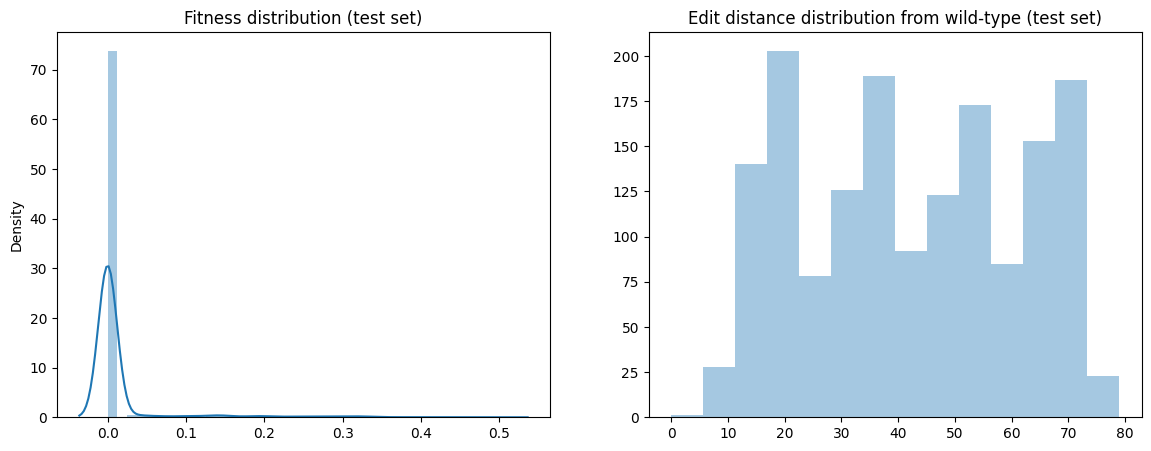

In [29]:
distances = [editdistance.eval(seq, starting_sequence) for seq in test_x]

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].set_title('Fitness distribution (test set)')
sns.distplot(test_y, kde=True, ax=ax[0])
ax[1].set_title('Edit distance distribution from wild-type (test set)')
sns.distplot(distances, kde=False, ax=ax[1])
plt.show()

Now we will examine the extrapolation ability (accuracy with respect to edit distance) of noisy abstract models at different signals strengths.

In [30]:
import scipy.stats

def get_corr_per_distance(seqs, labels, preds):    
    corrs = []
    edit_distances = np.array([editdistance.eval(seq, starting_sequence) for seq in seqs])
    
    for dist in range(1, 11):
        seqs_at_dist = edit_distances == dist
        
        if seqs_at_dist.sum() > 50:
            corrs.append(
                scipy.stats.pearsonr(labels[seqs_at_dist], preds[seqs_at_dist])[0]**2
            )
        else:
            corrs.append(np.nan)
            
    return corrs

In [31]:
corrs_noisy_neighbors = [get_corr_per_distance(test_x, test_y, noisy_model.get_fitness(test_x))
                         for noisy_model in noisy_models]

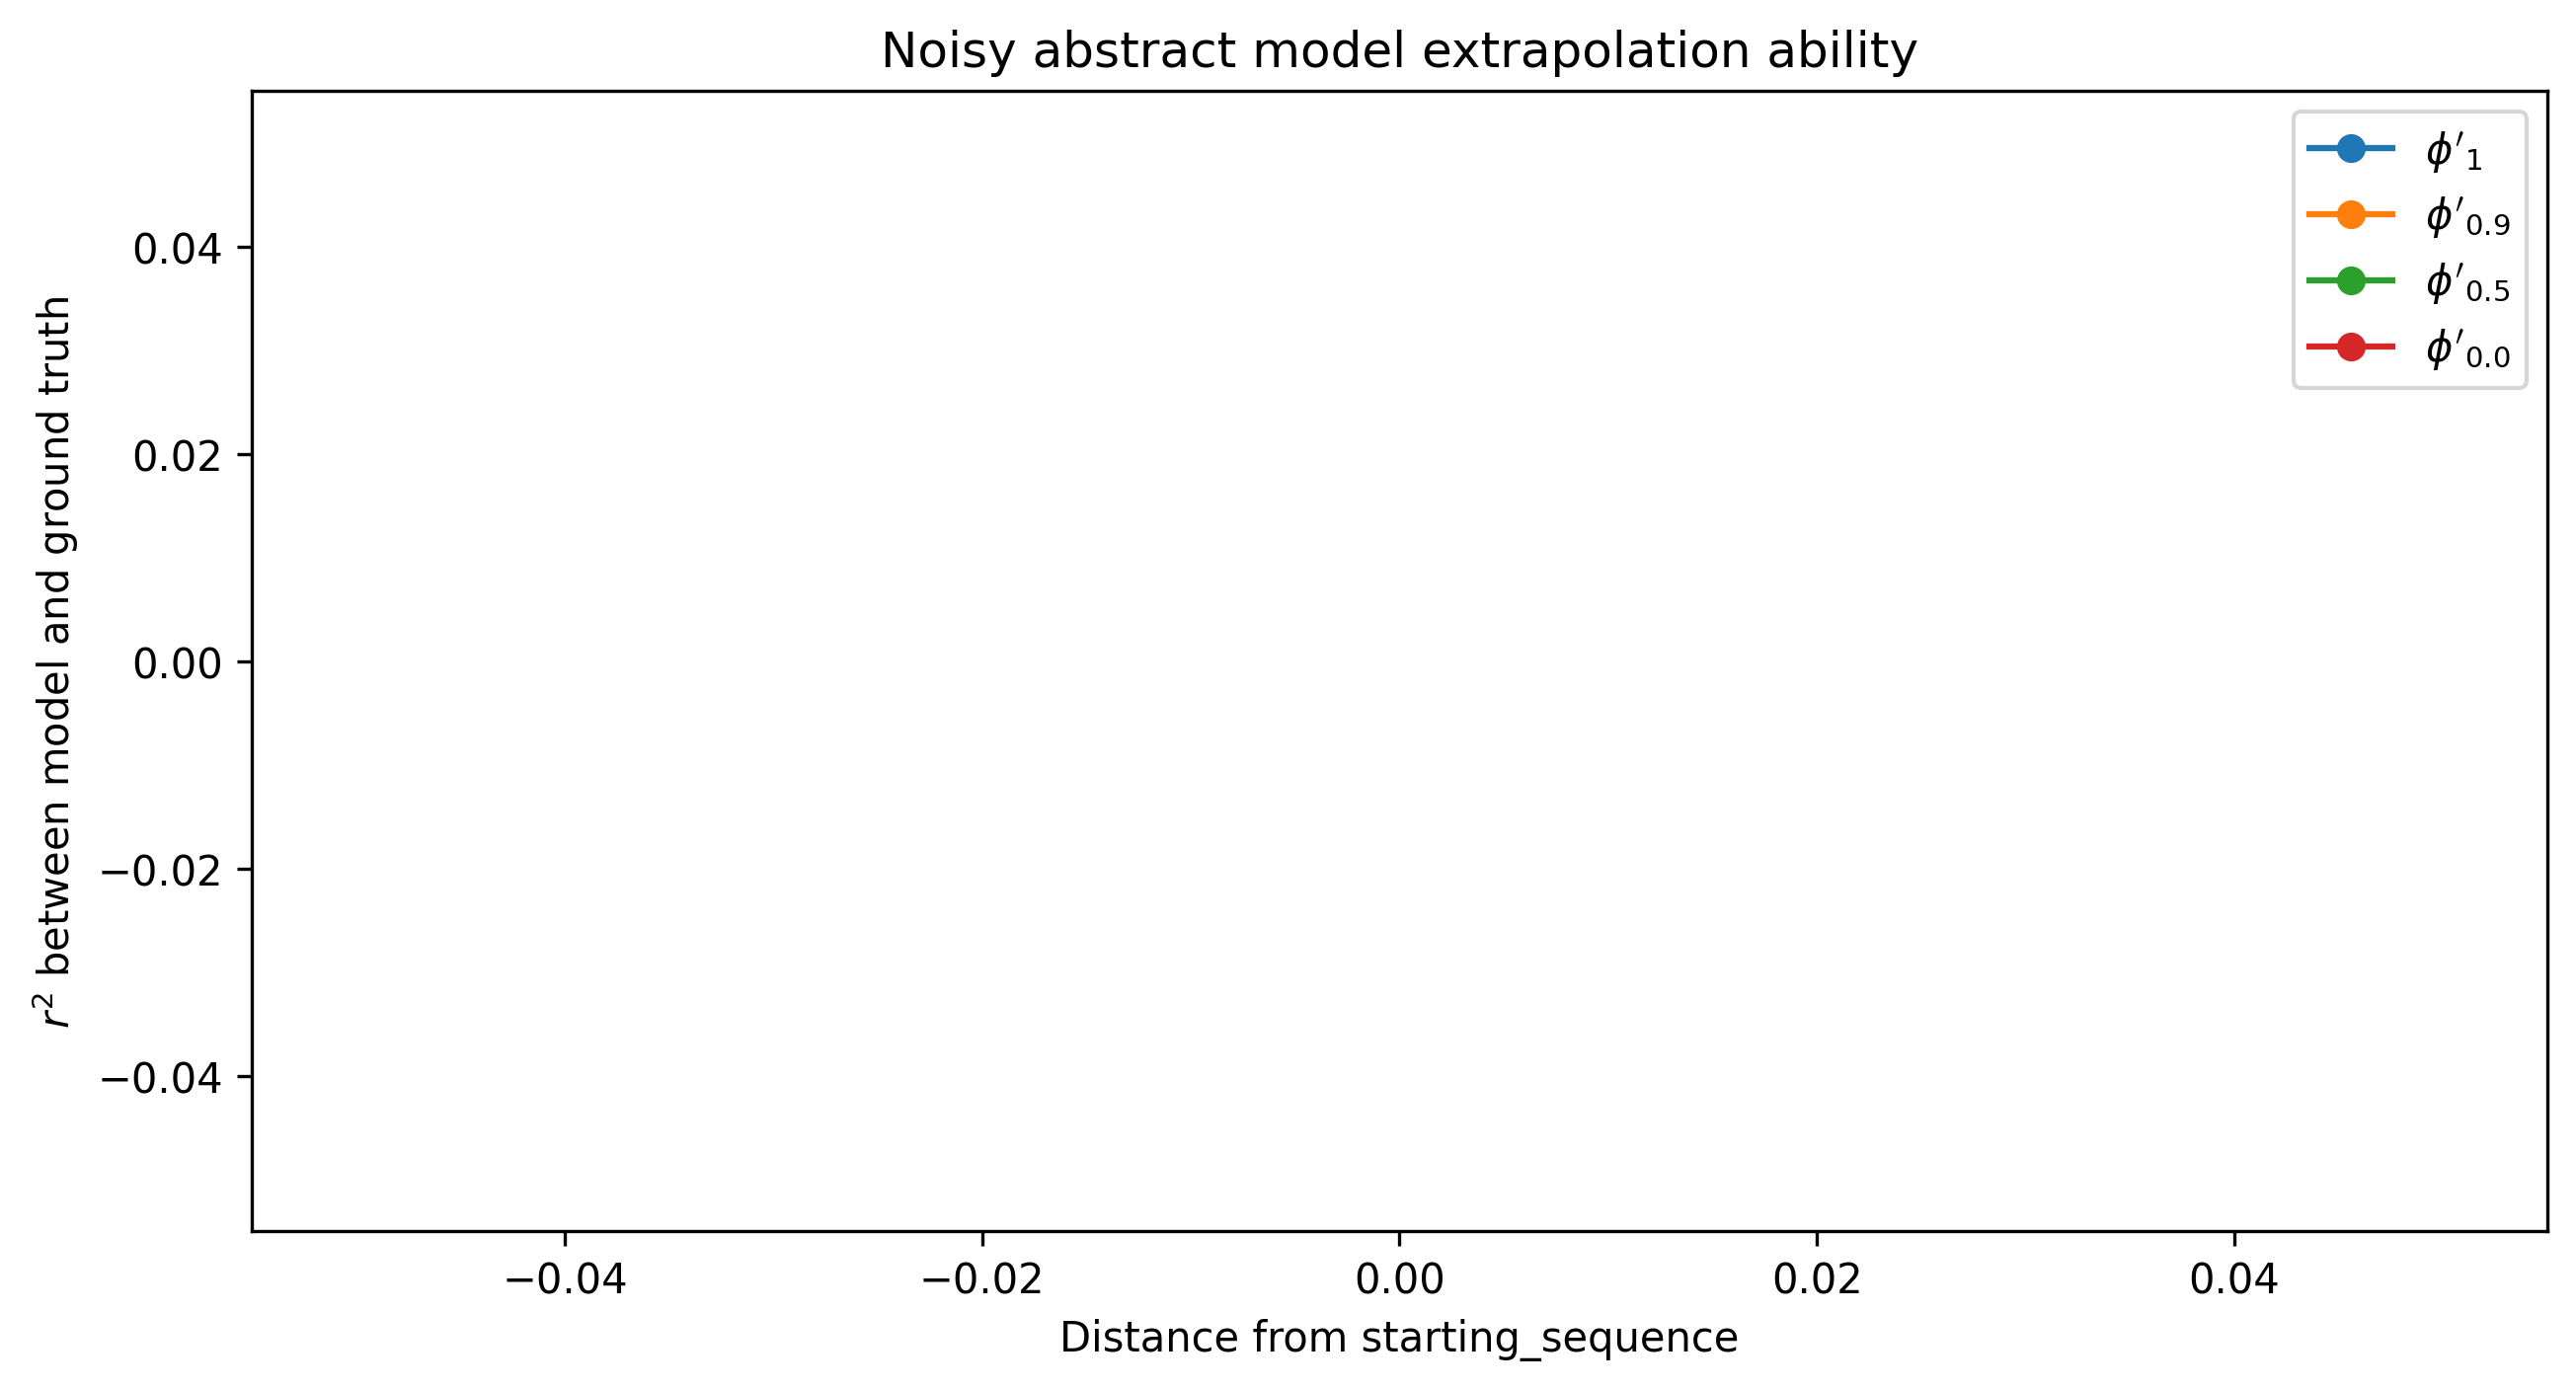

In [32]:
plt.figure(figsize=(10,5), dpi=300)
plt.title('Noisy abstract model extrapolation ability')
plt.plot(range(1,11), corrs_noisy_neighbors[0], 'o-', label="$\phi'_{1}$")
plt.plot(range(1,11), corrs_noisy_neighbors[1], 'o-', label="$\phi'_{0.9}$")
plt.plot(range(1,11), corrs_noisy_neighbors[2], 'o-', label="$\phi'_{0.5}$")
plt.plot(range(1,11), corrs_noisy_neighbors[3], 'o-', label="$\phi'_{0.0}$")
plt.ylabel("$r^2$ between model and ground truth")
plt.xlabel("Distance from starting_sequence")
plt.legend()
plt.show()

### 2.2 Models of landscapes built from data

So far, we have looked at noisy abstract models, are basically corrupted versions of the ground truth landscape. In reality, we don't have immediate access to the ground truth, so we approximate the landscape by training a traditional machine learning model on it. Some basic architectures are provided for convenience.

In [33]:
linear_regression = baselines.models.LinearRegression(alphabet=alphabet)
linear_regression.train(train_x, train_y)

linear_regression_preds = linear_regression.get_fitness(test_x)
corrs_linear = get_corr_per_distance(test_x, test_y, linear_regression_preds)

print(f"Overall correlation: {scipy.stats.pearsonr(linear_regression_preds, test_y)[0]**2}")

Overall correlation: 0.10264275683078845


In [34]:
random_forest = baselines.models.RandomForest(alphabet=alphabet)
random_forest.train(train_x, train_y)

random_forest_preds = random_forest.get_fitness(test_x)
corrs_rf = get_corr_per_distance(test_x, test_y, random_forest_preds)

print(f"Overall correlation: {scipy.stats.pearsonr(random_forest_preds, test_y)[0]**2}")

Overall correlation: 0.2949039978907063


In [35]:
mlp = baselines.models.MLP(len(starting_sequence), hidden_size=100, alphabet=alphabet, loss='MSE')
mlp.train(train_x, train_y)

mlp_preds = mlp.get_fitness(test_x)
corrs_mlp = get_corr_per_distance(test_x, test_y, mlp_preds)

print(f"Overall correlation: {scipy.stats.pearsonr(mlp_preds, test_y)[0]**2}")

2025-01-15 02:05:01.680212: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2025-01-15 02:05:01.751472: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0001:00:00.0 name: NVIDIA A100 80GB PCIe computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 79.14GiB deviceMemoryBandwidth: 1.76TiB/s
2025-01-15 02:05:01.753434: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 1 with properties: 
pciBusID: 0002:00:00.0 name: NVIDIA A100 80GB PCIe computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 79.14GiB deviceMemoryBandwidth: 1.76TiB/s
2025-01-15 02:05:01.755300: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 2 with properties: 
pciBusID: 0003:00:00.0 name: NVIDIA A100 80GB PCIe computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 79.14GiB deviceMemoryBandwidth: 1.76TiB/s
2

Overall correlation: 0.443592181771839


In [36]:
cnn = baselines.models.CNN(len(starting_sequence), num_filters=32, hidden_size=100, alphabet=alphabet, loss='MSE')
cnn.train(train_x, train_y)

cnn_preds = cnn.get_fitness(test_x)
corrs_cnn = get_corr_per_distance(test_x, test_y, cnn_preds)

print(f"Overall correlation: {scipy.stats.pearsonr(cnn_preds, test_y)[0]**2}")

Overall correlation: 0.46661748931429586


We can easily ensemble these models of the landscape as well. 

In [37]:
cnn_ensemble = flexs.Ensemble([
    baselines.models.CNN(len(starting_sequence), alphabet=alphabet, num_filters=32, hidden_size=100, loss='MSE')
    for i in range(3)
])
cnn_ensemble.train(train_x, train_y)

cnn_ensemble_preds = cnn_ensemble.get_fitness(test_x)
corrs_cnn_ensemble = get_corr_per_distance(test_x, test_y, cnn_ensemble_preds)

print(f"Overall correlation: {scipy.stats.pearsonr(cnn_ensemble_preds, test_y)[0]**2}")

Overall correlation: 0.543565714727627


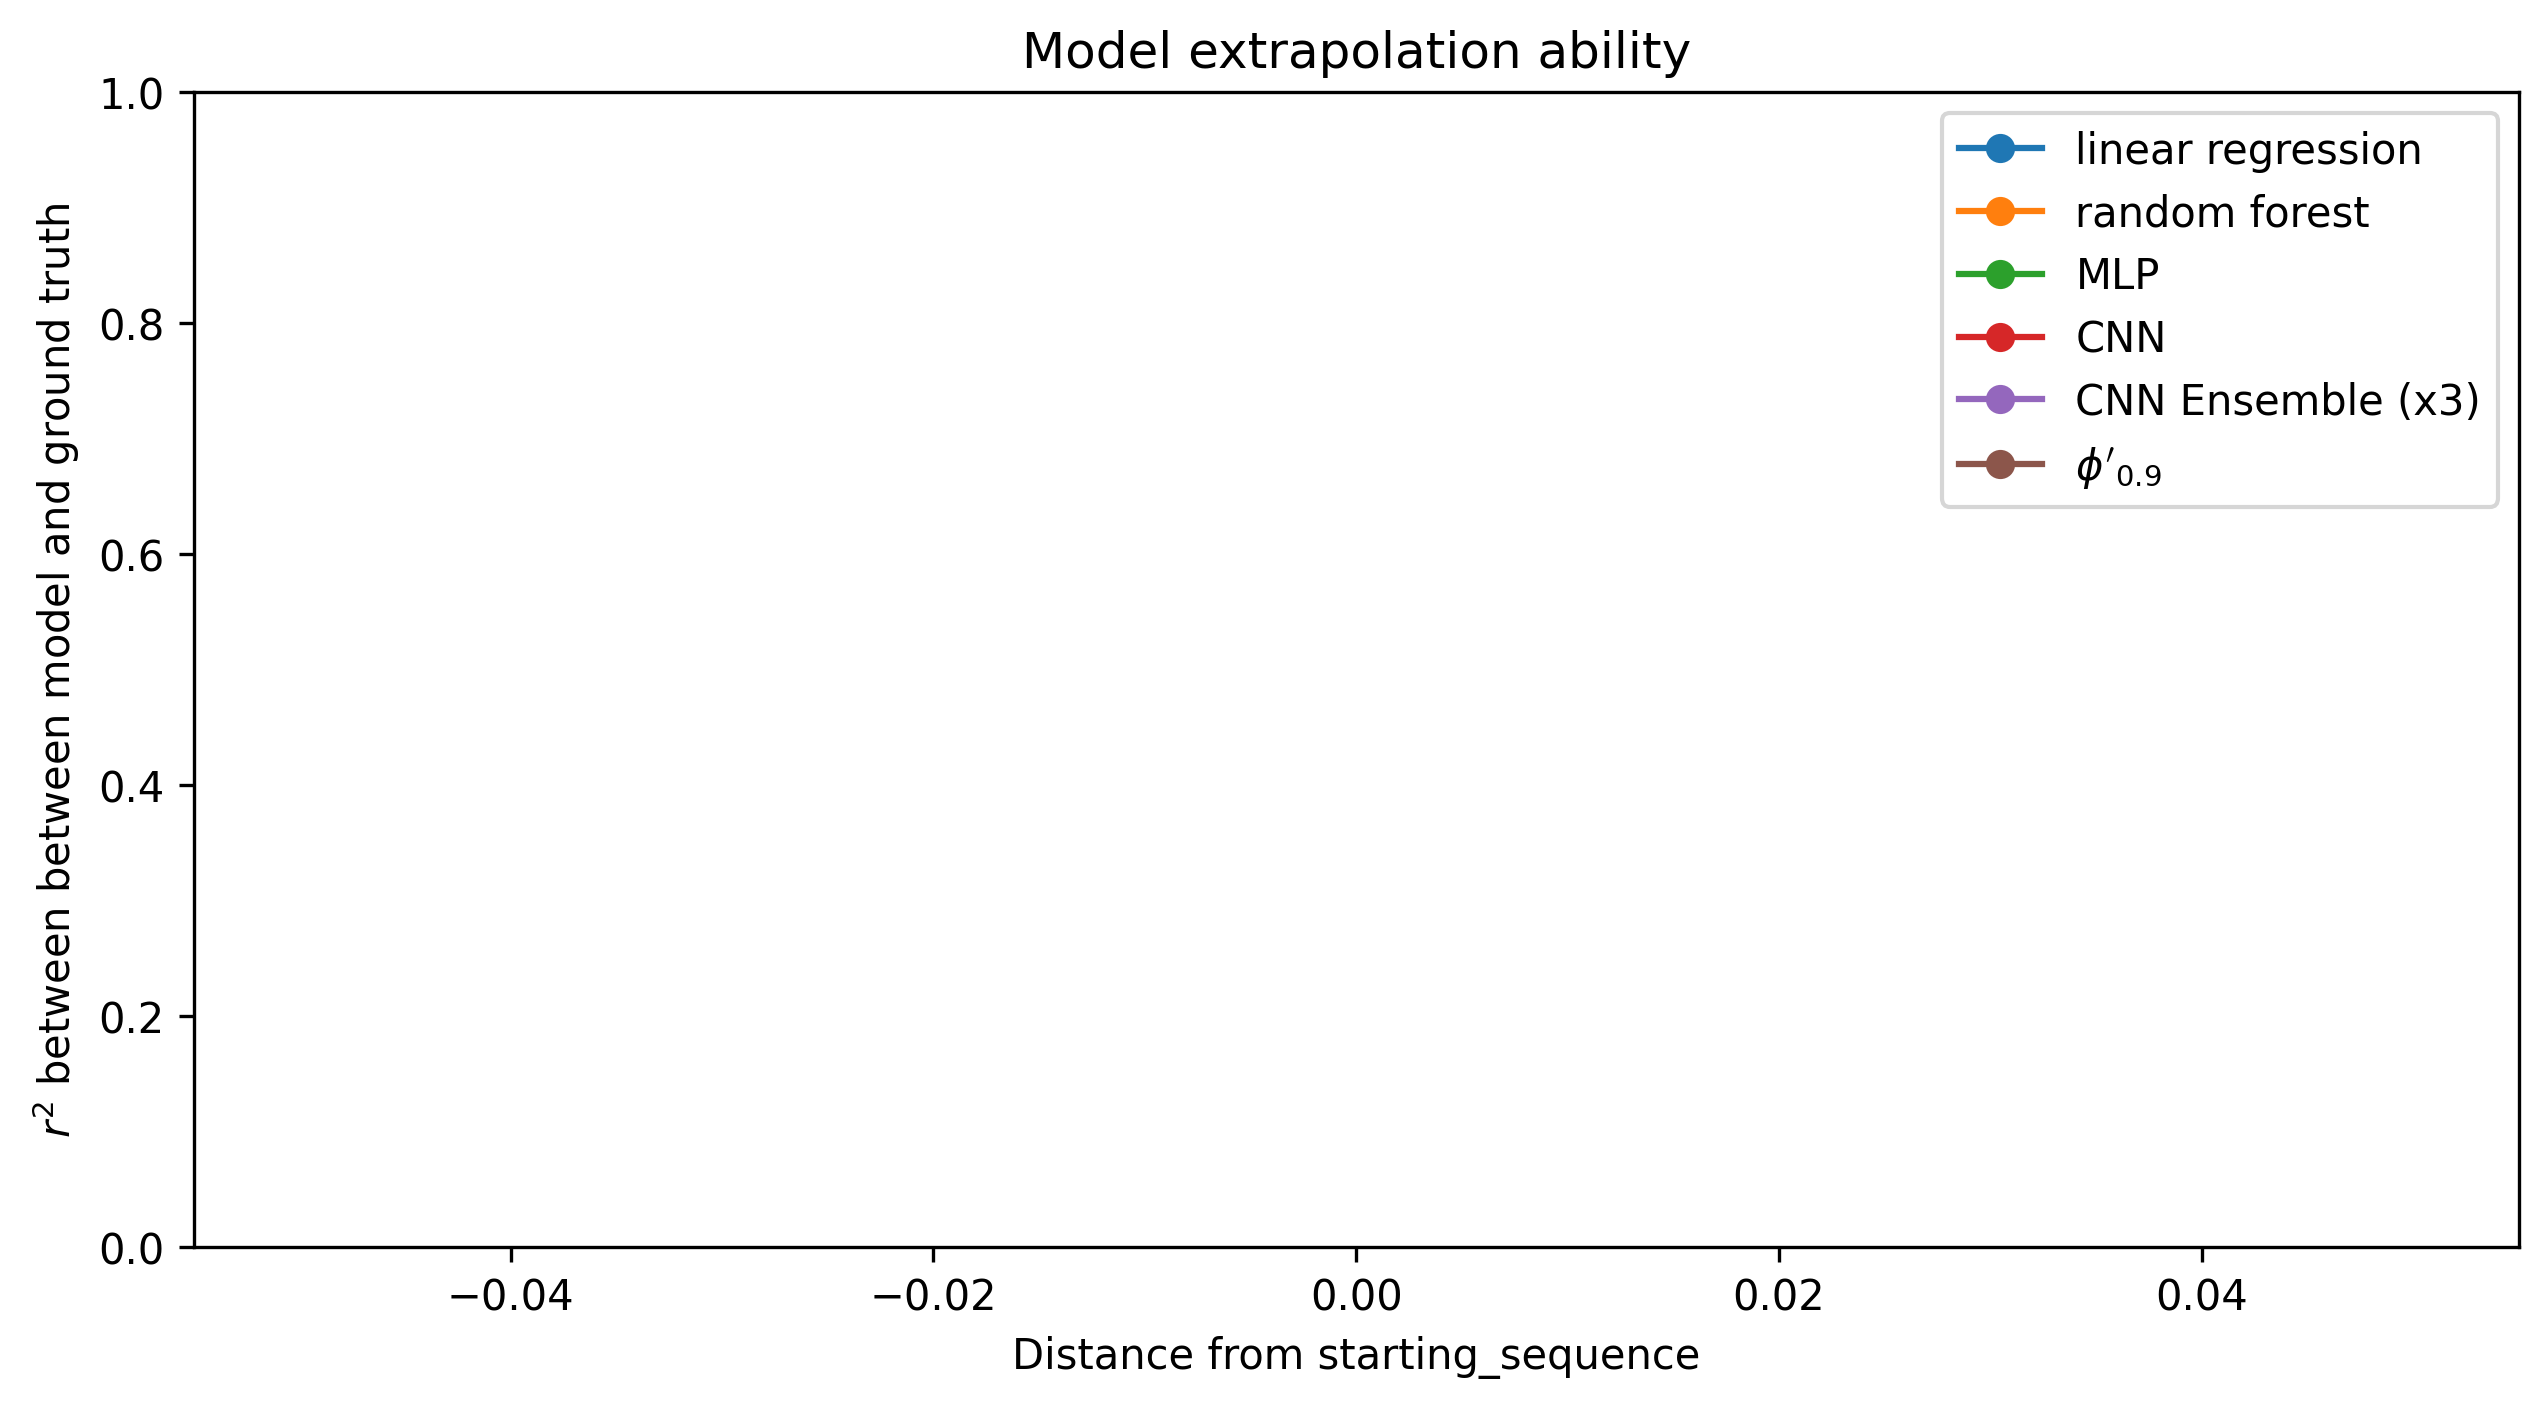

In [38]:
plt.figure(figsize=(10,5), dpi=300)
plt.title('Model extrapolation ability')
plt.plot(range(1,11), corrs_linear, 'o-', label="linear regression")
plt.plot(range(1,11), corrs_rf, 'o-', label="random forest")
plt.plot(range(1,11), corrs_mlp, 'o-', label="MLP")
plt.plot(range(1,11), corrs_cnn, 'o-', label="CNN")
plt.plot(range(1, 11), corrs_cnn_ensemble, 'o-', label="CNN Ensemble (x3)")
plt.plot(range(1,11), corrs_noisy_neighbors[1], 'o-', label="$\phi'_{0.9}$")
plt.ylabel("$r^2$ between between model and ground truth")
plt.xlabel("Distance from starting_sequence")
plt.legend()
plt.ylim(0, 1)
plt.show()

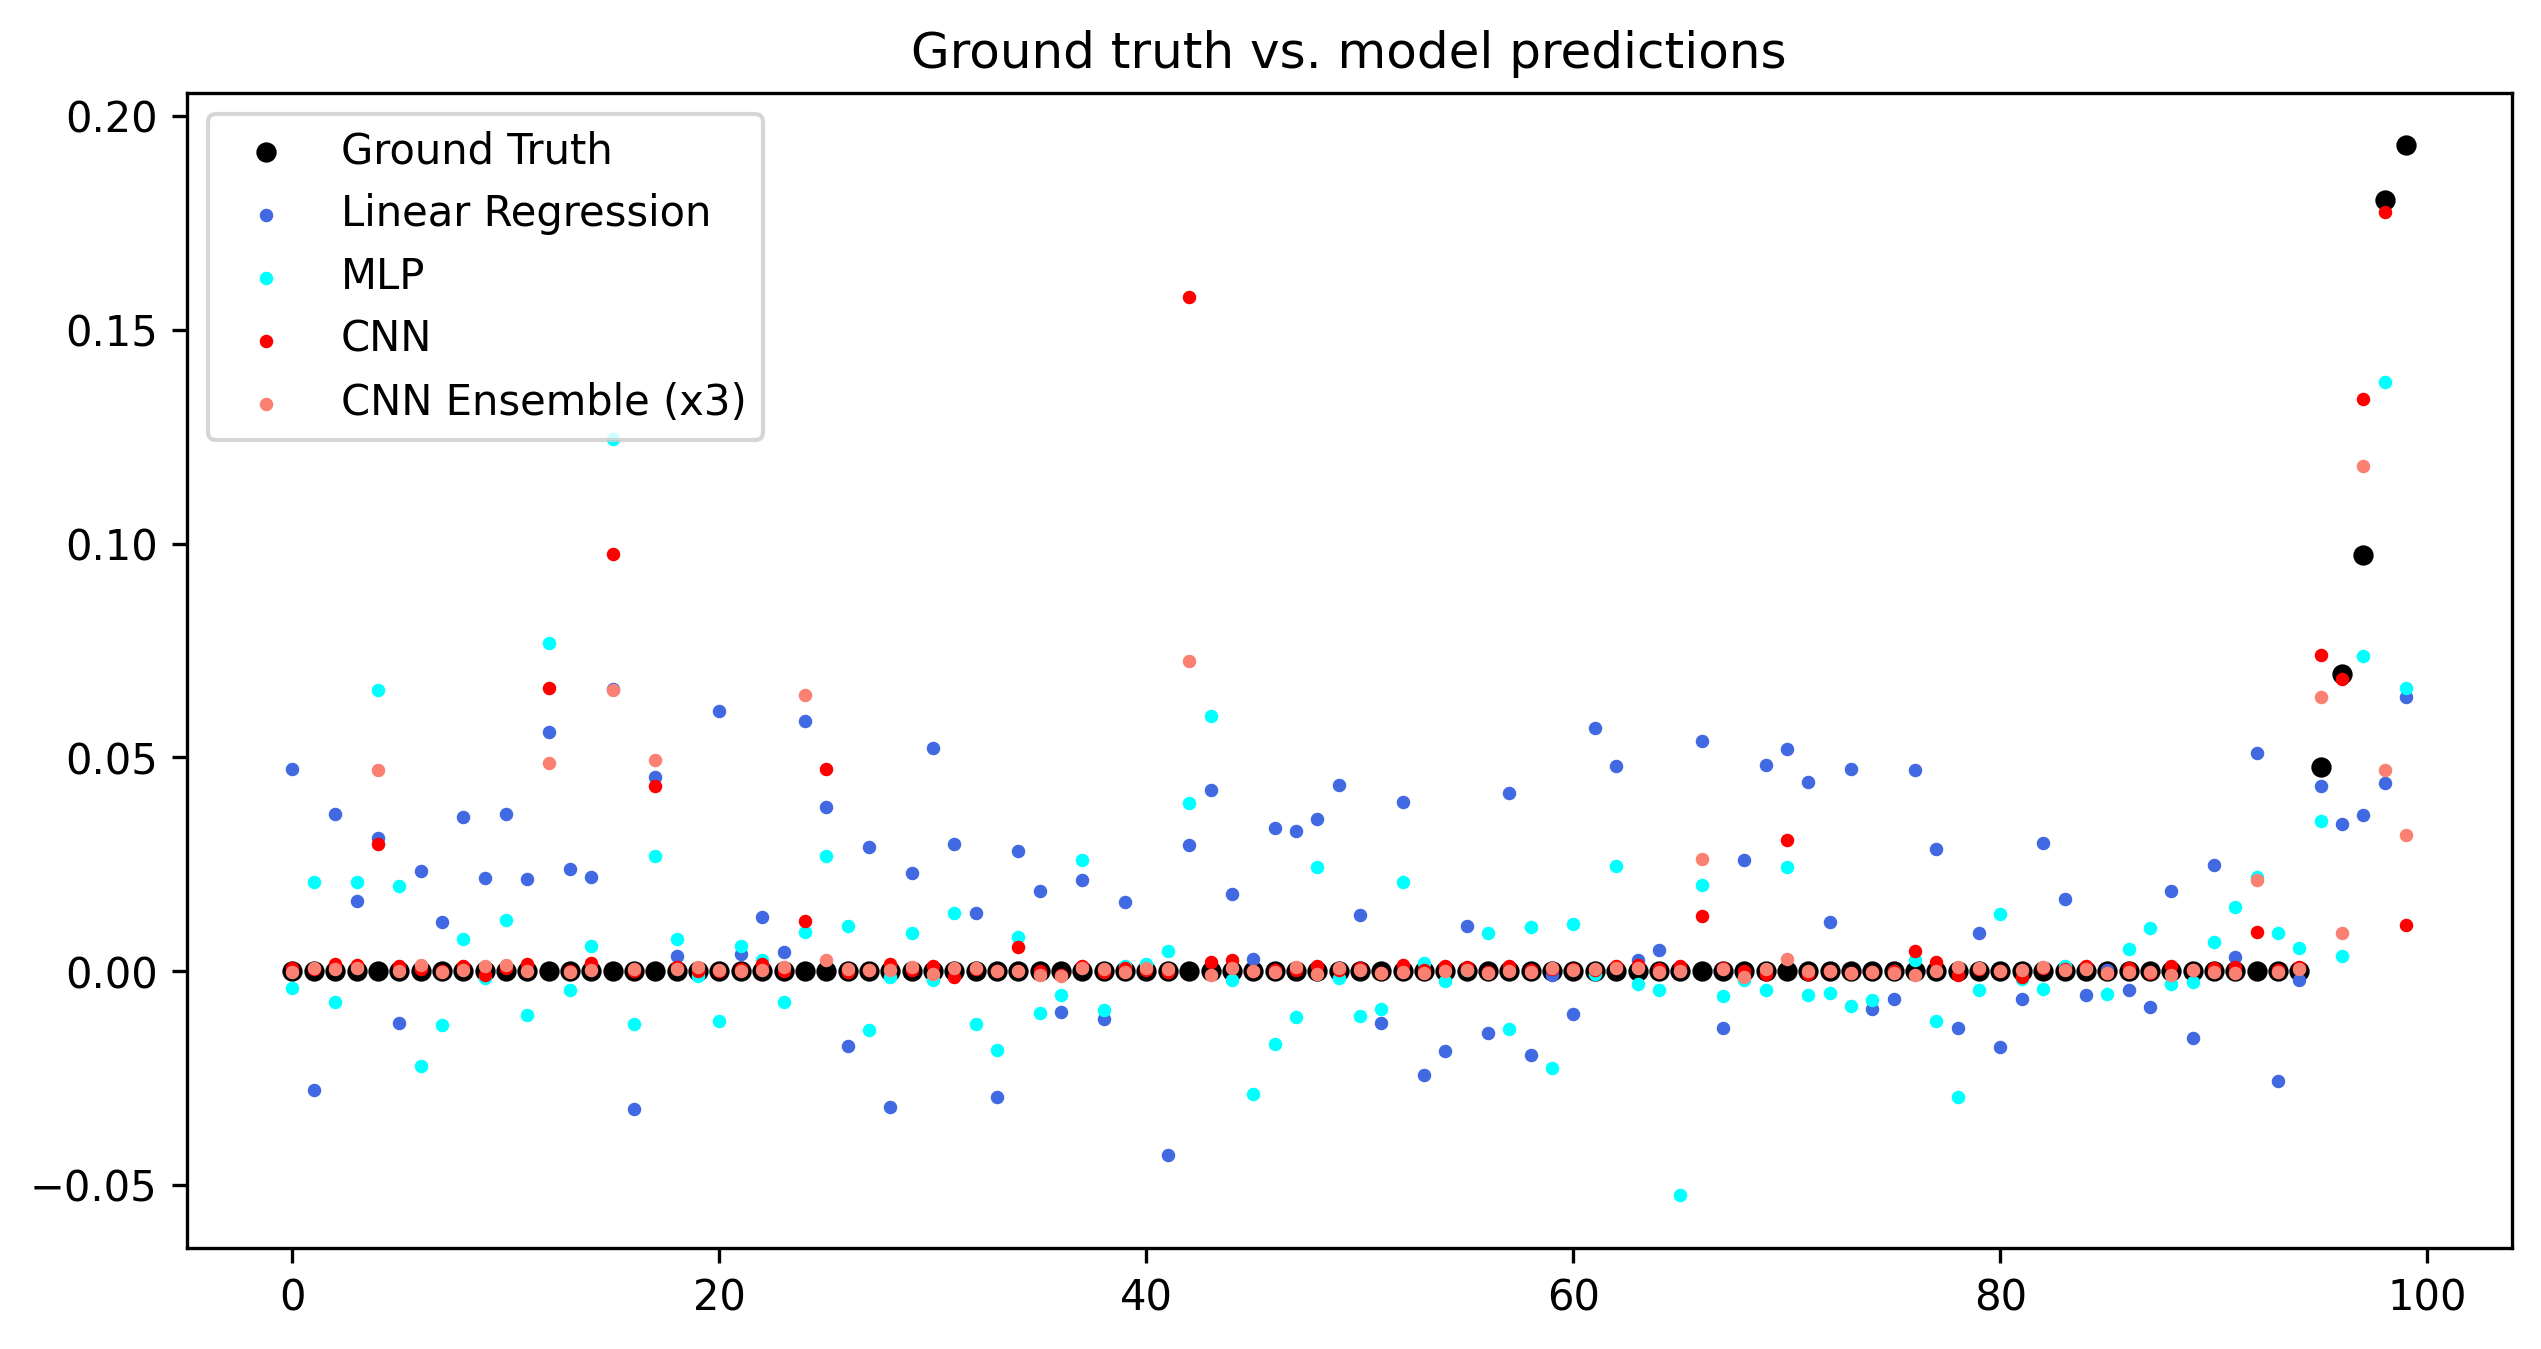

In [39]:
sort_order = np.argsort(test_y[:100])

plt.figure(figsize=(10,5), dpi=300)
plt.title('Ground truth vs. model predictions')
plt.scatter(range(len(sort_order)), test_y[sort_order], c="k", s=15, label="Ground Truth")
plt.scatter(range(len(sort_order)), linear_regression_preds[sort_order], c="royalblue", s=5, label="Linear Regression")
plt.scatter(range(len(sort_order)), mlp_preds[sort_order], c="cyan", s=5, label="MLP")
plt.scatter(range(len(sort_order)), cnn_preds[sort_order], c="red", s=5, label="CNN")
plt.scatter(range(len(sort_order)), cnn_ensemble_preds[sort_order], c="salmon", s=5, label="CNN Ensemble (x3)")

plt.legend()
plt.show()

Now that we have models, we can use them with an exploration algorithm to search the landscape. 

## 3. Exploring the landscape with a model <a class="anchor" id="section-three"></a>

All exploration algorithms in this package inherit from a base `Explorer` which performs some house-keeping tasks. To implement a new explorer, just implement the `propose_sequences` method, which suggest new sequences at each round.

Start with a simple explorer that does random search.

In [40]:
cnn = baselines.models.CNN(len(starting_sequence), alphabet=alphabet,
                         num_filters=32, hidden_size=100, loss='MSE')

random_explorer = baselines.explorers.Random(
    cnn,
    rounds=10,
    mu=1,
    starting_sequence=starting_sequence,
    sequences_batch_size=100,
    model_queries_per_batch=500,
    alphabet=alphabet
)

- `sequences_batch_size` denotes the experimental batch size per round
- `model_queries_per_batch` is the number of computational queries to the model that is allowed per round. 
- `alphabet` is the alphabet that is permissive on the current landscape.

The `run` method returns a dataframe with the sequences and some other important information.

In [41]:
random_sequences, metadata = random_explorer.run(landscape)
random_sequences

round: 0, top: 0.5, time: 0.000327s


round: 1, top: 0.5156202656124529, time: 0.556807s
round: 2, top: 0.51619970407986, time: 0.303521s
round: 3, top: 0.51619970407986, time: 0.396698s
round: 4, top: 0.5187392480198952, time: 0.583090s
round: 5, top: 0.5187392480198952, time: 0.643541s
round: 6, top: 0.5187392480198952, time: 0.765254s
round: 7, top: 0.5187392480198952, time: 0.956847s
round: 8, top: 0.5187392480198952, time: 1.037844s
round: 9, top: 0.5187392480198952, time: 1.189326s
round: 10, top: 0.5187392480198952, time: 1.274061s


sequence  model_score  \
0   PSGTTTQSRLQFSQAGASDIRDQSRNWLPGPCYRQQRVSKTSADNN...          NaN   
0   PSGTTTQSRLQFSQAGASDIRDQSRNWLPGPCKRQQRVSKTSADNN...     0.390483   
1   PSGTTTQSRLQFSQAGASDIRDQSRNWLPGPCYRQQRVSKTSADNN...     0.409964   
2   PSGTTTQSRLQPSQAGASDIRDQSRNWLPGPCYRQQRVSKTSADNN...     0.412542   
3   PSGTTTQSRLQFSQAGASDIREQSRNWLPGPCYRQQRVSKTSADNN...     0.398197   
..                                                ...          ...   
95  PSQTTTQSRLQFSQAGASRIRDQSRNWLPGPCYRQQRTSKTSADNN...     0.337509   
96  PWNTTTQSRLQFSQAGASDIRFQSRTWLPGPCYRQQRVSYTSADKN...     0.345585   
97  PSGTTTQSRLQFSQARASDIRDQSRNWLPGPCYRQQIVSKTSADNN...     0.403536   
98  PSGTTTWSRLQFSQAGASDIRDQSRNWLSGPCYRQQRVSKTSADNN...     0.362478   
99  PSGTTTQSRLQKSNAGASDIRDQSRNWLPGPCYRQQRVSKTSADNN...     0.339527   

    true_score  round  model_cost  measurement_cost  
0     0.500000      0           0                 1  
0     0.297984      1         501               101  
1     0.502171      1         501               101  
2     0.484071      1         501               101  
3     0.495230      1         501               101  
..         ...    ...         ...               ...  
95    0.378927     10        5010              1001  
96    0.369592     10        5010              1001  
97    0.393436     10        5010              1001  
98    0.442344     10        5010              1001  
99    0.368195     10        5010              1001  

[1001 rows x 6 columns]

We will compare performance among several explorers over 10 rounds with a sequences_batch_size of 100 and model_queries_per_batch size of 1000.

In [42]:
cnn = baselines.models.CNN(len(starting_sequence), alphabet=alphabet,
                         num_filters=32, hidden_size=100, loss='MSE')

adalead_explorer = baselines.explorers.Adalead(
    cnn,
    rounds=10,
    starting_sequence=starting_sequence,
    sequences_batch_size=100,
    model_queries_per_batch=500,
    alphabet=alphabet
)

In [43]:
adalead_sequences, metadata = adalead_explorer.run(landscape)

round: 0, top: 0.5, time: 0.000354s


round: 1, top: 0.5169904577508754, time: 1.844522s
round: 2, top: 0.5257749111612431, time: 1.269604s
round: 3, top: 0.5323455084454413, time: 1.422355s
round: 4, top: 0.5352751255961304, time: 1.681780s
round: 5, top: 0.5446410701974362, time: 1.898448s
round: 6, top: 0.546861632747085, time: 1.684523s
round: 7, top: 0.5501086002623279, time: 2.397804s
round: 8, top: 0.5618405667993963, time: 2.095218s
round: 9, top: 0.5718521402616789, time: 2.350262s
round: 10, top: 0.5783603219013139, time: 2.290246s


In [44]:
cnn = baselines.models.CNN(len(starting_sequence), alphabet=alphabet,
                         num_filters=32, hidden_size=100, loss='MSE')

genetic_explorer = baselines.explorers.GeneticAlgorithm(
    cnn,
    
    population_size=20,
    parent_selection_strategy='wright-fisher', # wright-fisher model decides who gets to 'mate'
    beta=0.01,
    children_proportion=0.2,

    rounds=10,
    starting_sequence=starting_sequence,
    sequences_batch_size=100,
    model_queries_per_batch=500,
    alphabet=alphabet
)

In [45]:
genetic_algo_sequences, metadata = genetic_explorer.run(landscape)

round: 0, top: 0.5, time: 0.000306s
round: 1, top: 0.5155876142248742, time: 5.496548s
round: 2, top: 0.5210896336942508, time: 5.600684s
round: 3, top: 0.5295332765772631, time: 5.116090s
round: 4, top: 0.5406042803640536, time: 5.333067s
round: 5, top: 0.5606558475413496, time: 5.074745s
round: 6, top: 0.5806215508359788, time: 5.426800s
round: 7, top: 0.5910091257844637, time: 5.566289s
round: 8, top: 0.5969720693289667, time: 5.605969s
round: 9, top: 0.610937810956911, time: 5.878845s
round: 10, top: 0.610937810956911, time: 6.236684s


In [46]:
cnn = baselines.models.CNN(len(starting_sequence), alphabet=alphabet,
                         num_filters=32, hidden_size=100, loss='MSE')

cmaes_explorer = baselines.explorers.CMAES(
    flexs.LandscapeAsModel(landscape),
    population_size=10,
    max_iter=200,
    rounds=10,
    starting_sequence=starting_sequence,
    sequences_batch_size=100,
    model_queries_per_batch=500,
    alphabet=alphabet
)

In [42]:
cmaes_sequences, metadata = cmaes_explorer.run(landscape)

round: 0, top: 0.5, time: 0.000353s


round: 1, top: 0.5, time: 24.198340s
round: 2, top: 0.5, time: 23.674027s
round: 3, top: 0.5, time: 22.625519s
round: 4, top: 0.5, time: 22.859471s
round: 5, top: 0.5, time: 22.702725s
round: 6, top: 0.5, time: 23.368178s
round: 7, top: 0.5, time: 22.751672s
round: 8, top: 0.5, time: 23.489743s
round: 9, top: 0.5, time: 23.648081s
round: 10, top: 0.5, time: 23.358030s


In [9]:
dynappo_explorer = baselines.explorers.DynaPPO(  # DynaPPO has its own default ensemble model, so don't use CNN
    landscape=landscape,
    env_batch_size=10,
    num_model_rounds=10,
    rounds=10,
    starting_sequence=starting_sequence,
    sequences_batch_size=100,
    model_queries_per_batch=500,
    alphabet=alphabet,
    # log_file=f'efficiency/dynappo/aav/test.csv',
)

NameError: name 'baselines' is not defined

In [10]:
dynappo_sequences, metadata = dynappo_explorer.run(landscape)

NameError: name 'dynappo_explorer' is not defined

In [11]:
cnn = baselines.models.CNN(len(starting_sequence), alphabet=alphabet,
                         num_filters=32, hidden_size=100, loss='MSE')

vae = baselines.explorers.VAE(len(starting_sequence), alphabet=alphabet, epochs=10, verbose=False)

cbas_explorer = baselines.explorers.CbAS(
    model=cnn,
    generator=vae,
    cycle_batch_size=100,
    rounds=10,
    starting_sequence=starting_sequence,
    sequences_batch_size=100,
    model_queries_per_batch=2000,
    alphabet=alphabet,
)

NameError: name 'baselines' is not defined

In [40]:
cbas_sequences, metadata = cbas_explorer.run(landscape)

round: 0, top: 0.5437468768175177, time: 0.000351s


/home/v-zhaozhiyu/miniconda3/envs/FLEXS/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


round: 1, top: 0.7222496462872485, time: 0.410732s


/home/v-zhaozhiyu/miniconda3/envs/FLEXS/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


round: 2, top: 0.7222496462872485, time: 230.919735s


/home/v-zhaozhiyu/miniconda3/envs/FLEXS/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


round: 3, top: 0.7222496462872485, time: 217.249968s


/home/v-zhaozhiyu/miniconda3/envs/FLEXS/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


round: 4, top: 0.7222496462872485, time: 201.478411s


/home/v-zhaozhiyu/miniconda3/envs/FLEXS/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


round: 5, top: 0.7222496462872485, time: 196.659091s


/home/v-zhaozhiyu/miniconda3/envs/FLEXS/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


round: 6, top: 0.7222496462872485, time: 181.643547s


/home/v-zhaozhiyu/miniconda3/envs/FLEXS/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


round: 7, top: 0.7222496462872485, time: 193.844836s


/home/v-zhaozhiyu/miniconda3/envs/FLEXS/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


round: 8, top: 0.7222496462872485, time: 192.487268s


/home/v-zhaozhiyu/miniconda3/envs/FLEXS/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


round: 9, top: 0.7222496462872485, time: 226.735749s


/home/v-zhaozhiyu/miniconda3/envs/FLEXS/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


round: 10, top: 0.7222496462872485, time: 217.628683s


In [41]:
cnn = baselines.models.CNN(len(starting_sequence), alphabet=alphabet,
                         num_filters=32, hidden_size=100, loss='MSE')

# This is `EVO_BO` in the paper, an evolutionary algorithm using
# ensembled models (when provided) to estimate uncertainty
bo_explorer = baselines.explorers.BO(
    model=cnn,
    rounds=10,
    starting_sequence=starting_sequence,
    sequences_batch_size=100,
    model_queries_per_batch=1000,
    alphabet=alphabet,
)

In [42]:
bo_sequences, metadata = bo_explorer.run(landscape)

round: 0, top: 0.5437468768175177, time: 0.000404s


round: 1, top: 0.6343713912067976, time: 3.638608s


/home/v-zhaozhiyu/miniconda3/envs/FLEXS/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


round: 2, top: 0.6673257172196391, time: 3.566197s


/home/v-zhaozhiyu/miniconda3/envs/FLEXS/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


round: 3, top: 0.6673257172196391, time: 3.618620s


/home/v-zhaozhiyu/miniconda3/envs/FLEXS/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


round: 4, top: 0.6673257172196391, time: 3.886210s


/home/v-zhaozhiyu/miniconda3/envs/FLEXS/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


round: 5, top: 0.6673257172196391, time: 4.061220s


/home/v-zhaozhiyu/miniconda3/envs/FLEXS/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


round: 6, top: 0.7332344740044028, time: 4.063809s


/home/v-zhaozhiyu/miniconda3/envs/FLEXS/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


round: 7, top: 0.7332344740044028, time: 4.541374s


/home/v-zhaozhiyu/miniconda3/envs/FLEXS/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


round: 8, top: 0.7332344740044028, time: 4.414172s


/home/v-zhaozhiyu/miniconda3/envs/FLEXS/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


round: 9, top: 0.8375899182810447, time: 4.704300s


/home/v-zhaozhiyu/miniconda3/envs/FLEXS/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


round: 10, top: 0.8375899182810447, time: 4.634628s


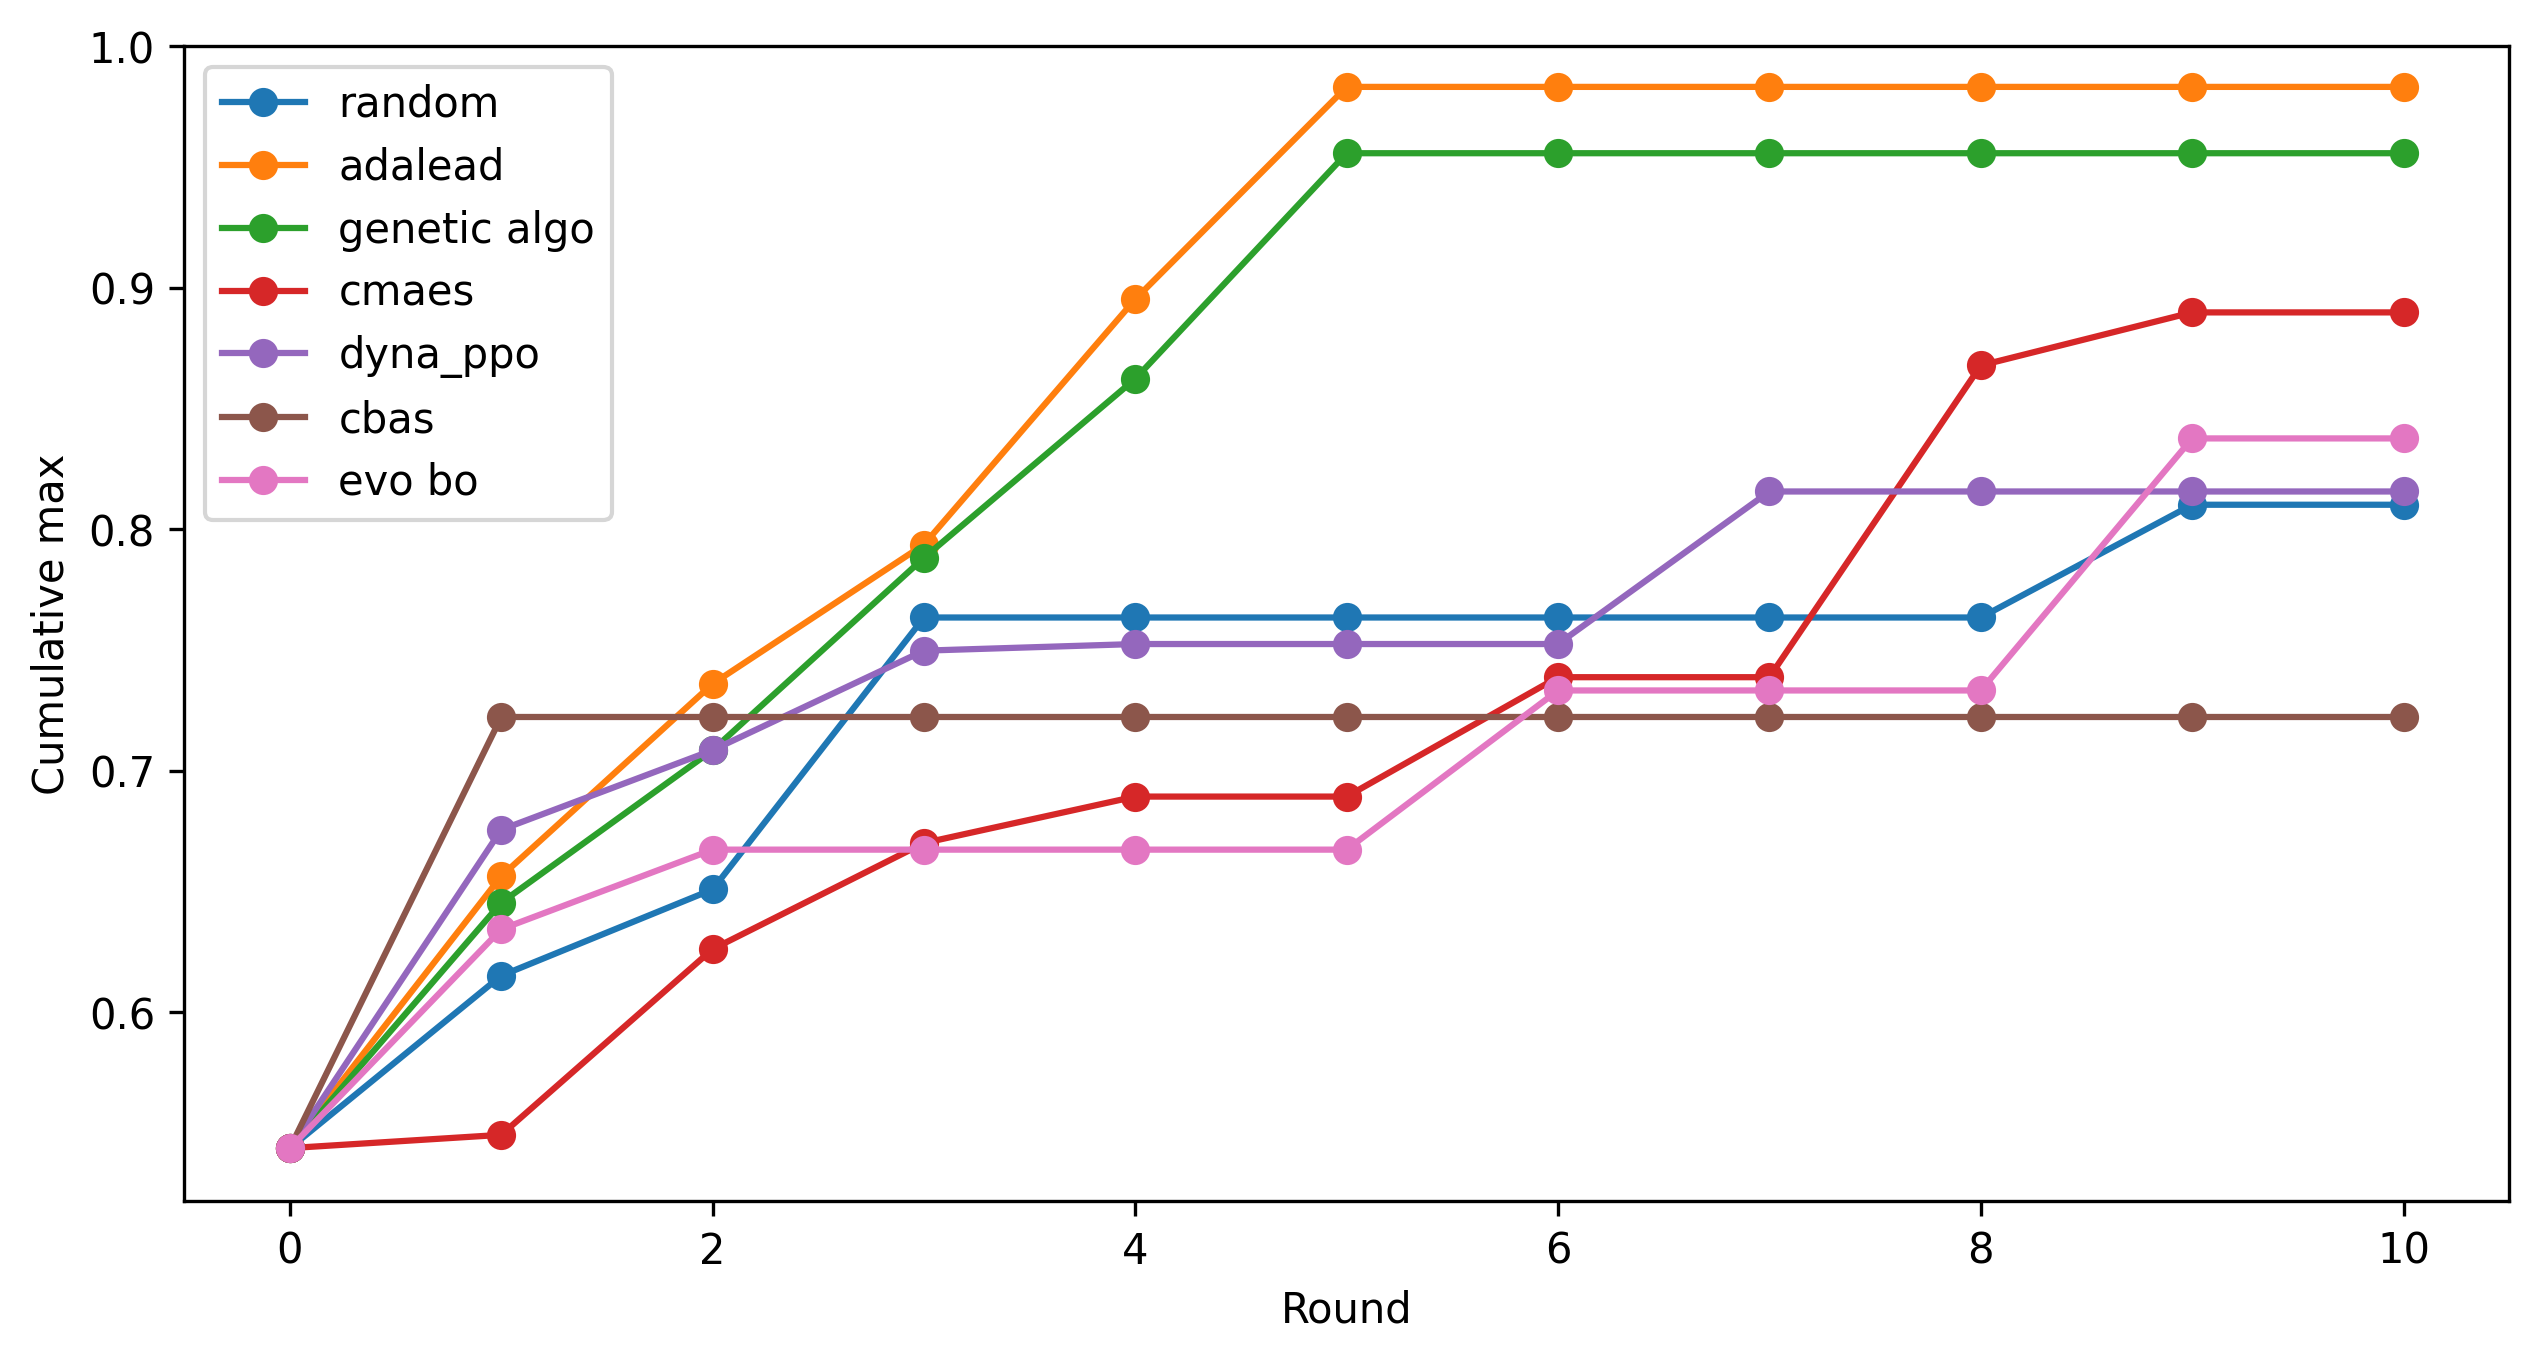

In [43]:
def cumulative_max_per_round(sequences):
    num_rounds = sequences['round'].max() + 1
    max_per_round = [sequences['true_score'][sequences['round'] == r].max()
                     for r in range(num_rounds)]

    return np.maximum.accumulate(max_per_round)

plt.figure(figsize=(10,5), dpi=300)
plt.plot(range(11), cumulative_max_per_round(random_sequences), 'o-', label="random")
plt.plot(range(11), cumulative_max_per_round(adalead_sequences), 'o-', label="adalead")
plt.plot(range(11), cumulative_max_per_round(genetic_algo_sequences), 'o-', label="genetic algo")
plt.plot(range(11), cumulative_max_per_round(cmaes_sequences), 'o-', label="cmaes")
plt.plot(range(11), cumulative_max_per_round(dynappo_sequences), 'o-', label="dyna_ppo")
plt.plot(range(11), cumulative_max_per_round(cbas_sequences), 'o-', label="cbas")
plt.plot(range(11), cumulative_max_per_round(bo_sequences), 'o-', label="evo bo")
plt.ylabel("Cumulative max")
plt.xlabel("Round")
plt.legend()
plt.ylim(None, 1)
plt.show()

## 4. Evaluating an exploration algorithm <a class="anchor" id="section-four"></a>


The `flexs.evaluate` module can be used run tests aimed at different properties of the explorer. 

Tests include:
- `robustness`: shows how explorer performance changes with model quality (noisy abstract models at different signal strengths).
- `efficiency`: shows how explorer performance changes when more computational evals are allowed
- `adaptivity`: shows how the explorer is sensitive to the number of batches it is allowed to sample

In most cases, you want to set the `log_dir` argument on the explorer to write output to a .csv file to analyze later.

Here we will test out Adalead's robustness to varying model quality.

In [44]:
def make_explorer(model, signal_strength):
    return baselines.explorers.Adalead(
            model,
            rounds=5,
            mu=1,
            starting_sequence=starting_sequence,
            sequences_batch_size=100,
            model_queries_per_batch=1000,
            alphabet=alphabet,
            log_file=f'robustness/adalead/{signal_strength}.csv'
        )

results = flexs.evaluate.robustness(landscape, make_explorer, signal_strengths=[0, 0.5, 0.75, 0.9, 1])

Evaluating for robustness with model accuracy; signal_strength: 0
round: 0, top: 0.5437468768175177, time: 0.002137s


round: 1, top: 0.6892953202744071, time: 1.364401s
round: 2, top: 0.815620367605817, time: 1.666660s
round: 3, top: 0.9337067941493612, time: 1.882280s
round: 4, top: 0.9419453625576865, time: 1.944841s
round: 5, top: 0.9419453625576865, time: 1.814438s
Evaluating for robustness with model accuracy; signal_strength: 0.5
round: 0, top: 0.5437468768175177, time: 0.000814s
round: 1, top: 0.7222496462872485, time: 1.387515s
round: 2, top: 0.7826659892134351, time: 1.487364s
round: 3, top: 0.889767692798906, time: 1.778497s
round: 4, top: 0.889767692798906, time: 2.628289s
round: 5, top: 0.889767692798906, time: 1.541506s
Evaluating for robustness with model accuracy; signal_strength: 0.75
round: 0, top: 0.5437468768175177, time: 0.000772s
round: 1, top: 0.7634425930879556, time: 1.434463s
round: 2, top: 0.8430823321396218, time: 1.500300s
round: 3, top: 0.8430823321396218, time: 1.700247s
round: 4, top: 0.8650518828148493, time: 1.551615s
round: 5, top: 0.889767692798906, time: 1.620358s
E

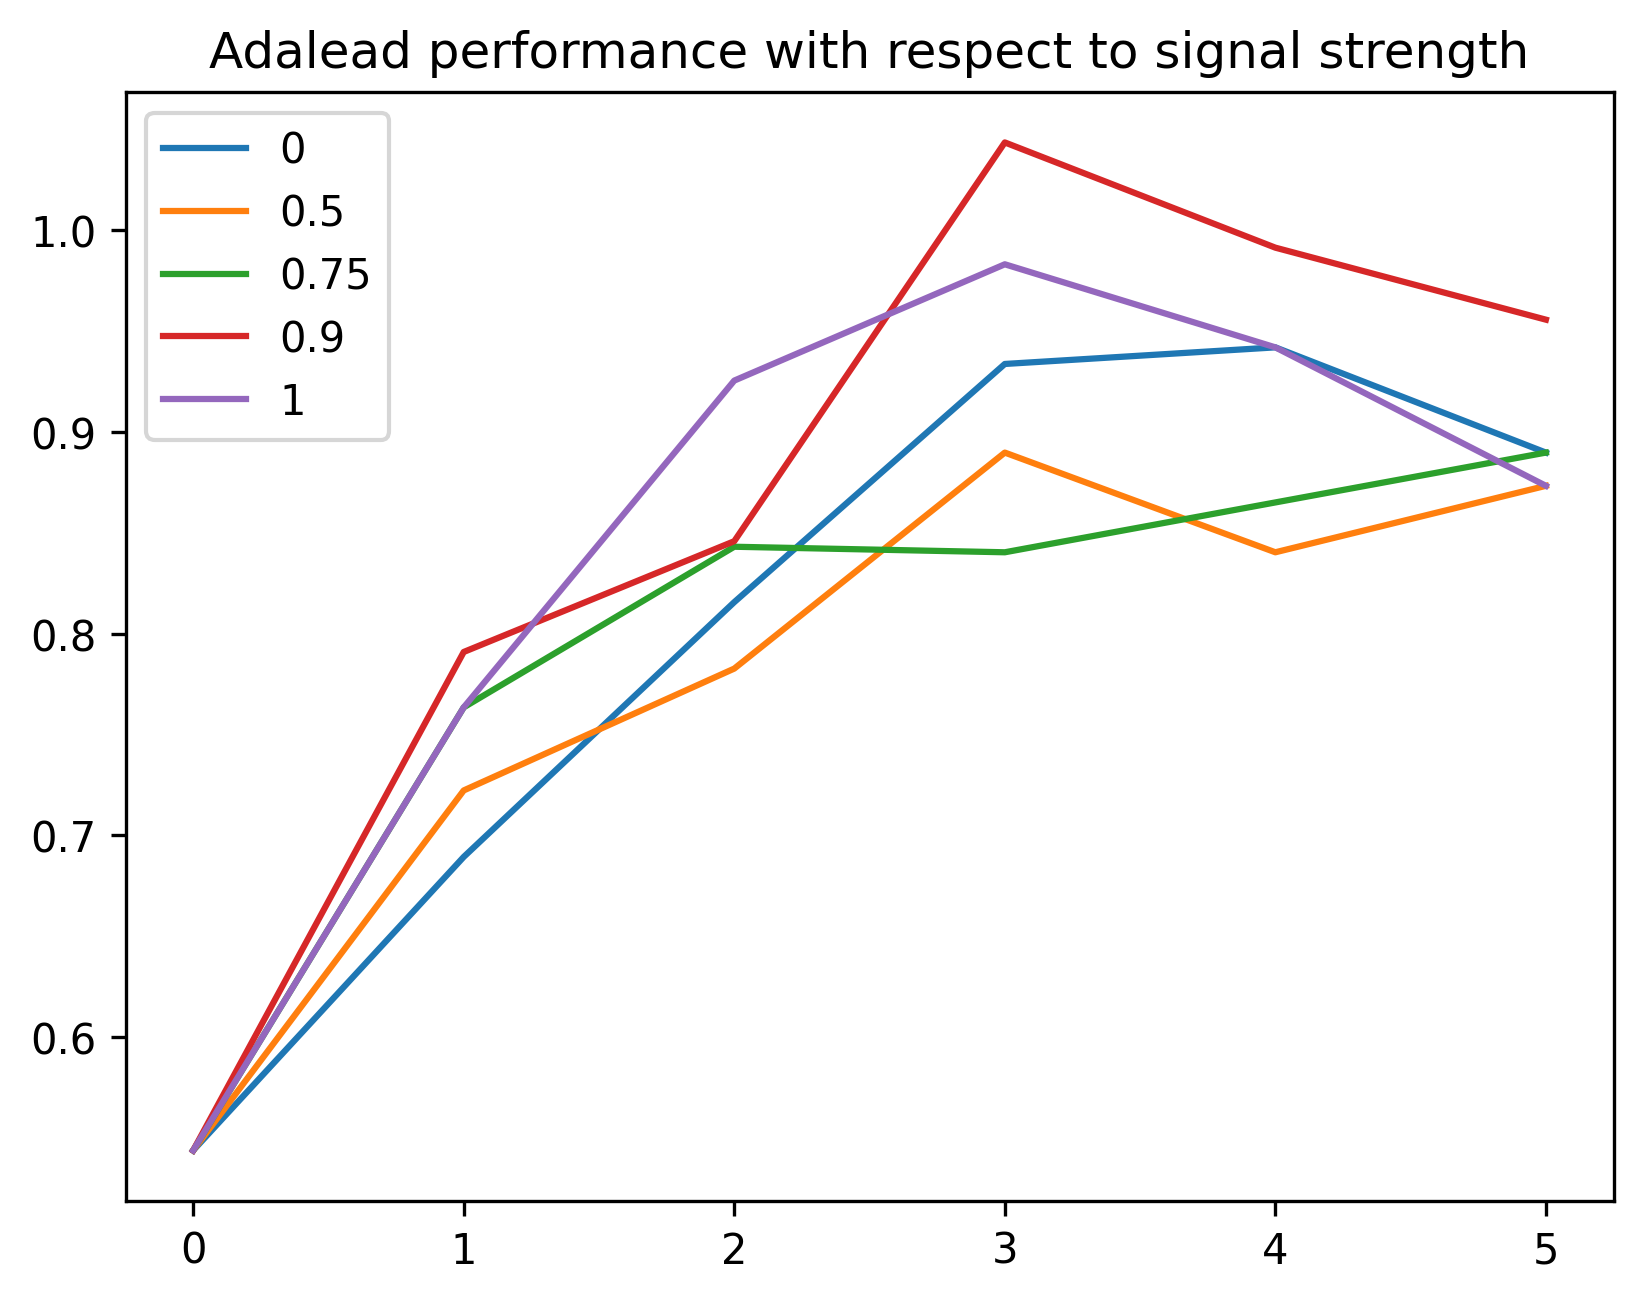

In [46]:
plt.figure(dpi=300)
plt.title('Adalead performance with respect to signal strength')

# The output file contains metadata on the first line
for signal_strength in [0, 0.5, 0.75, 0.9, 1]:
    with open(f'robustness/adalead/{signal_strength}.csv') as f:
        metadata = json.loads(next(f))
        data = pd.read_csv(f)
    
    rounds = data['round'].unique()
    
    plt.plot(rounds, [data[data['round'] == r]['true_score'].max() for r in rounds], label=signal_strength)

plt.legend()

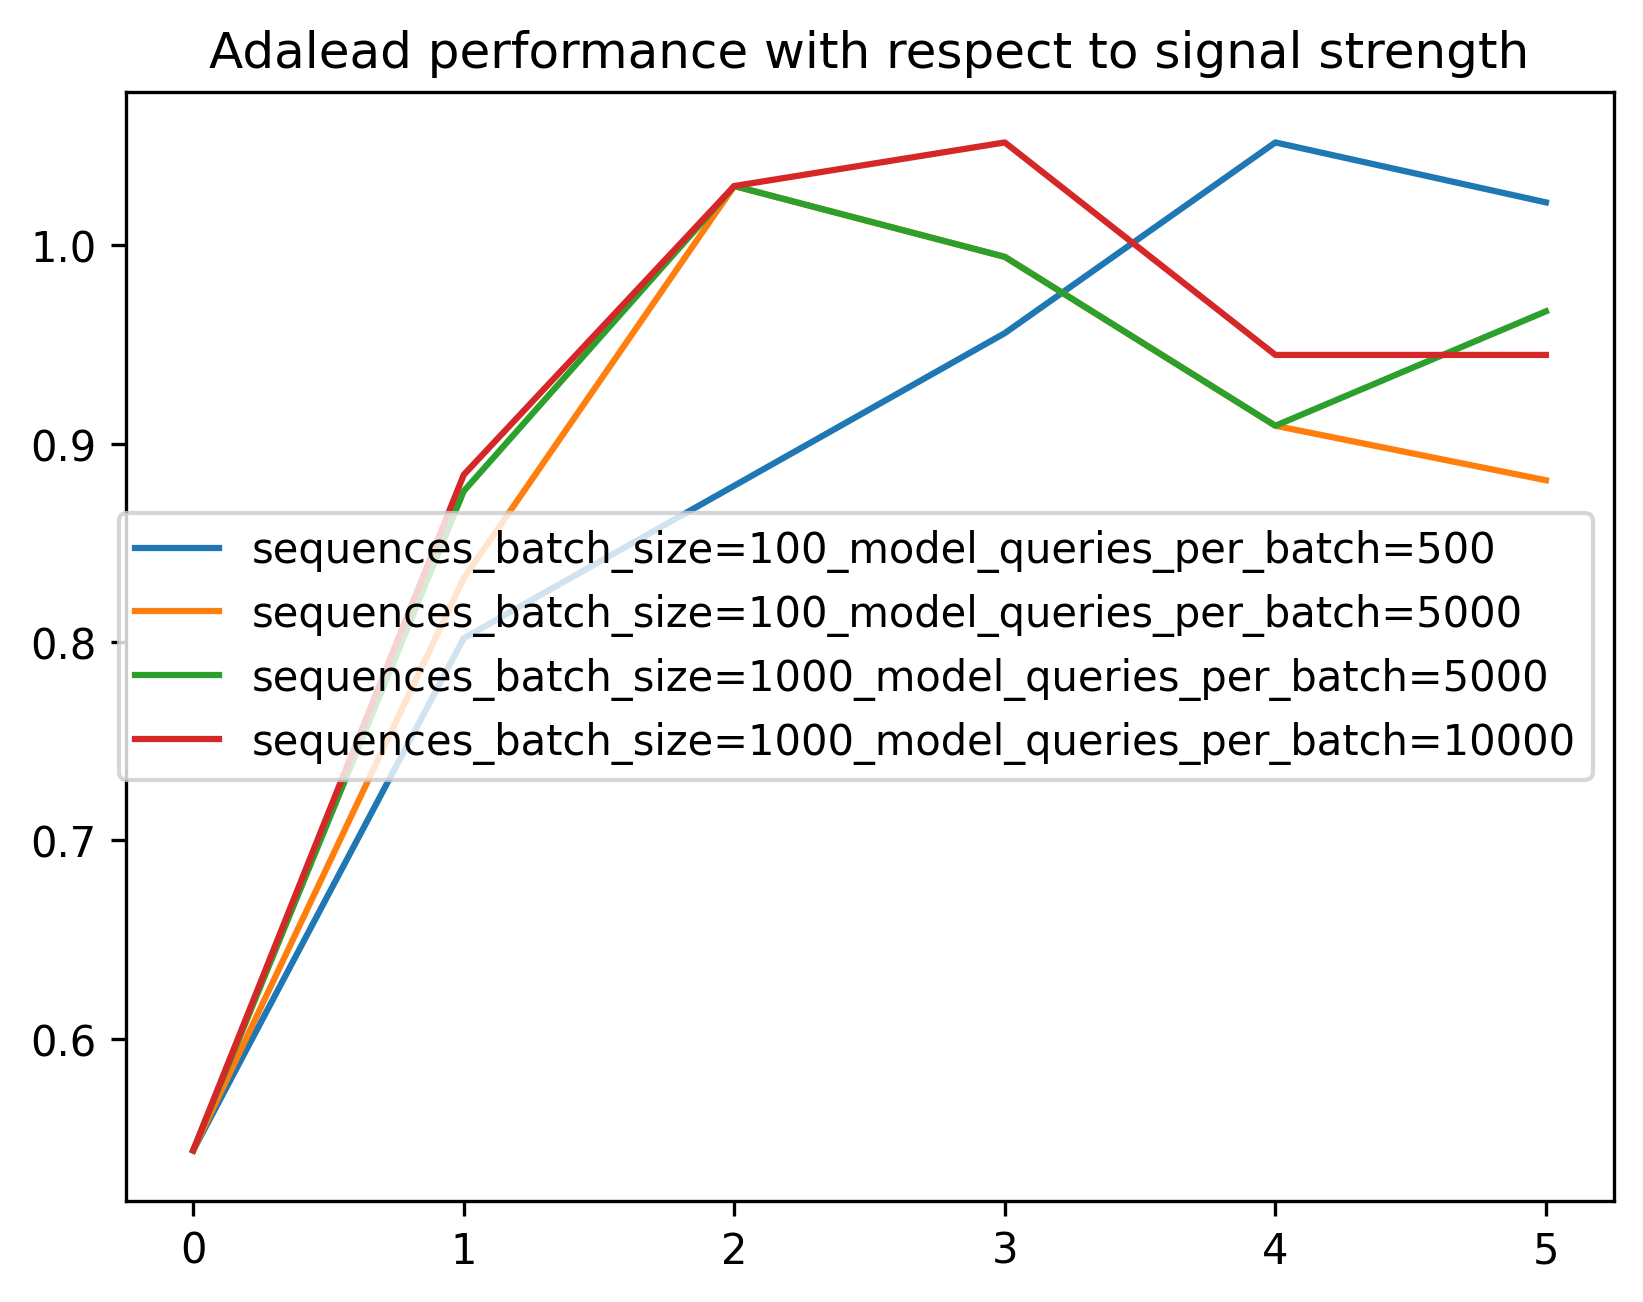

In [18]:
import matplotlib.pyplot as plt
plt.figure(dpi=300)
plt.title('Adalead performance with respect to signal strength')


for sequences_batch_size, model_queries_per_batch in [(100, 500), (100, 5000),(1000, 5000),(1000, 10000)]:
    with open(f'/home/v-zhaozhiyu/code/FLEXS/efficiency/adalead/{sequences_batch_size}_{model_queries_per_batch}.csv') as f:
        metadata = json.loads(next(f))
        data = pd.read_csv(f)

    rounds = data['round'].unique()

    plt.plot(rounds, [data[data['round'] == r]['true_score'].max() for r in rounds], label=f'sequences_batch_size={sequences_batch_size}_model_queries_per_batch={model_queries_per_batch}')

plt.legend()

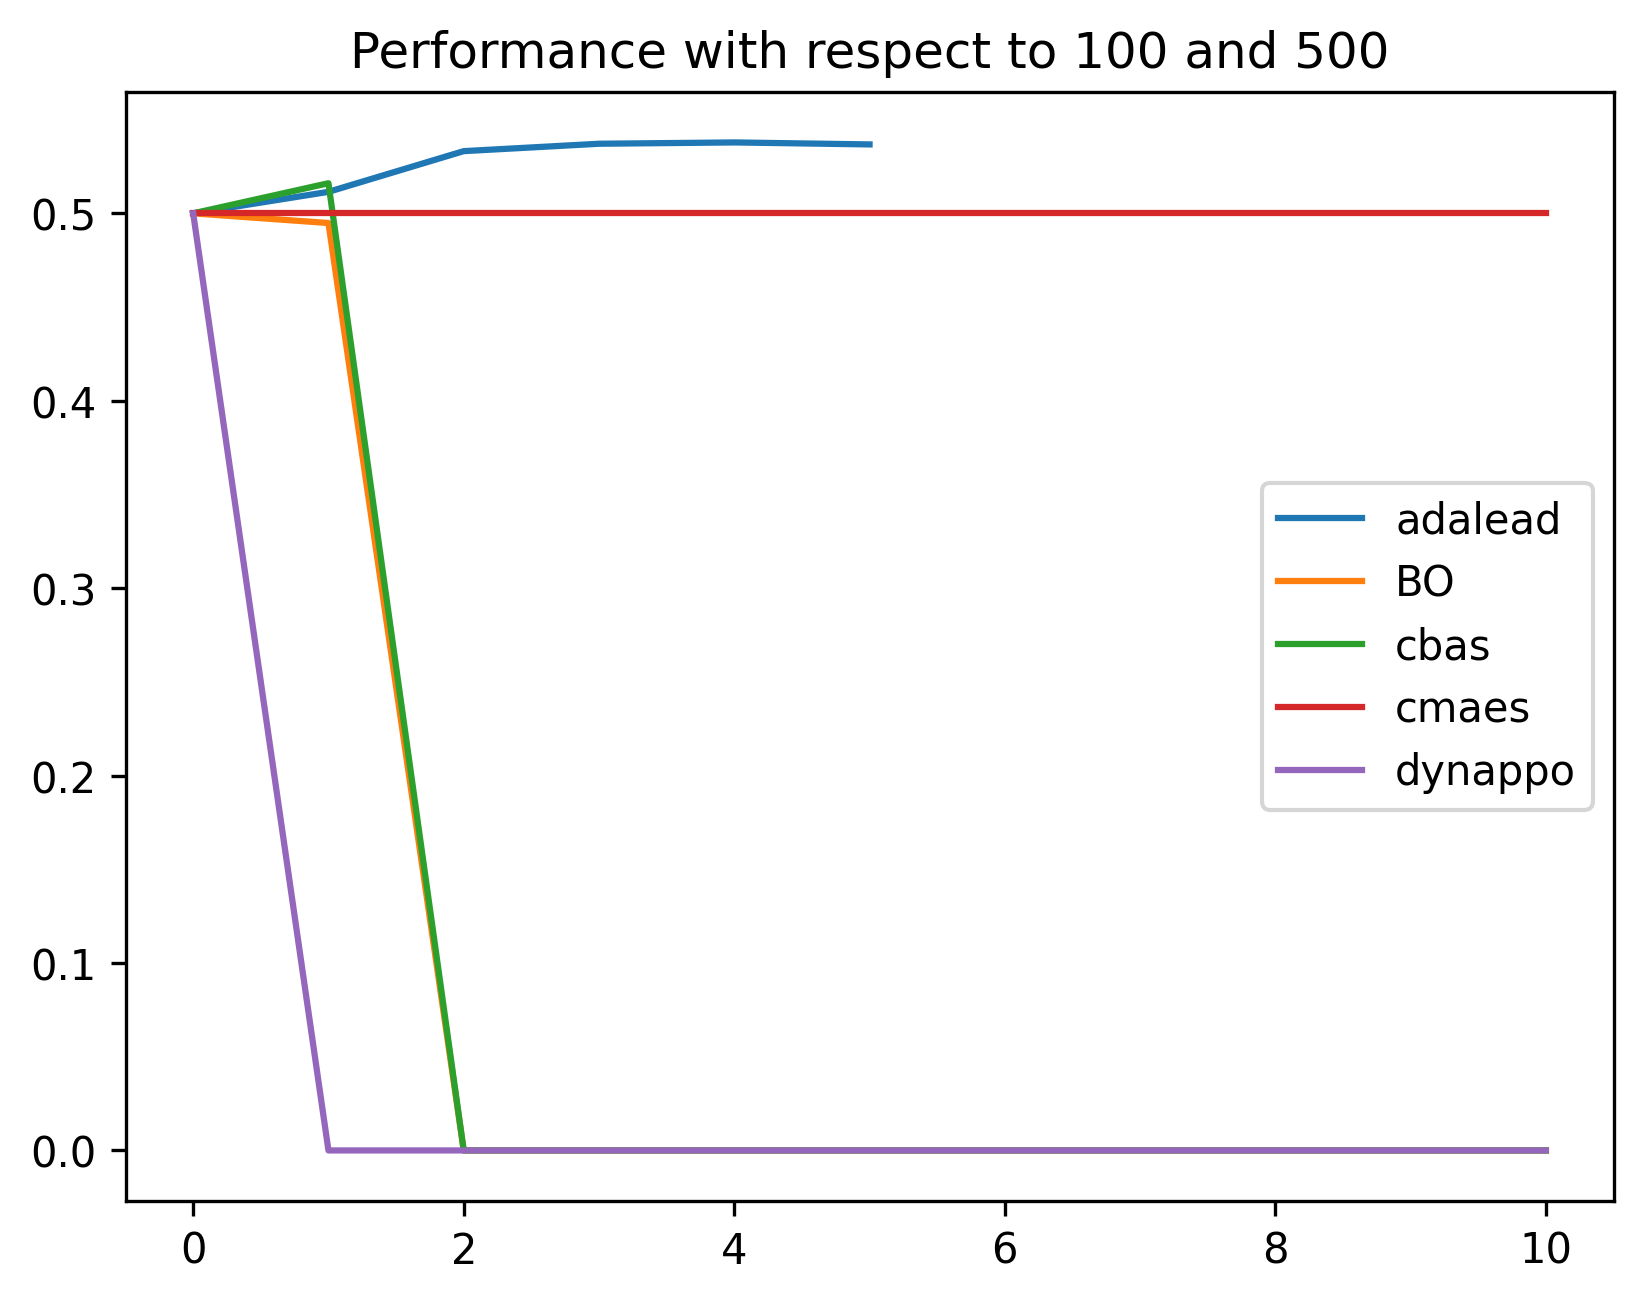

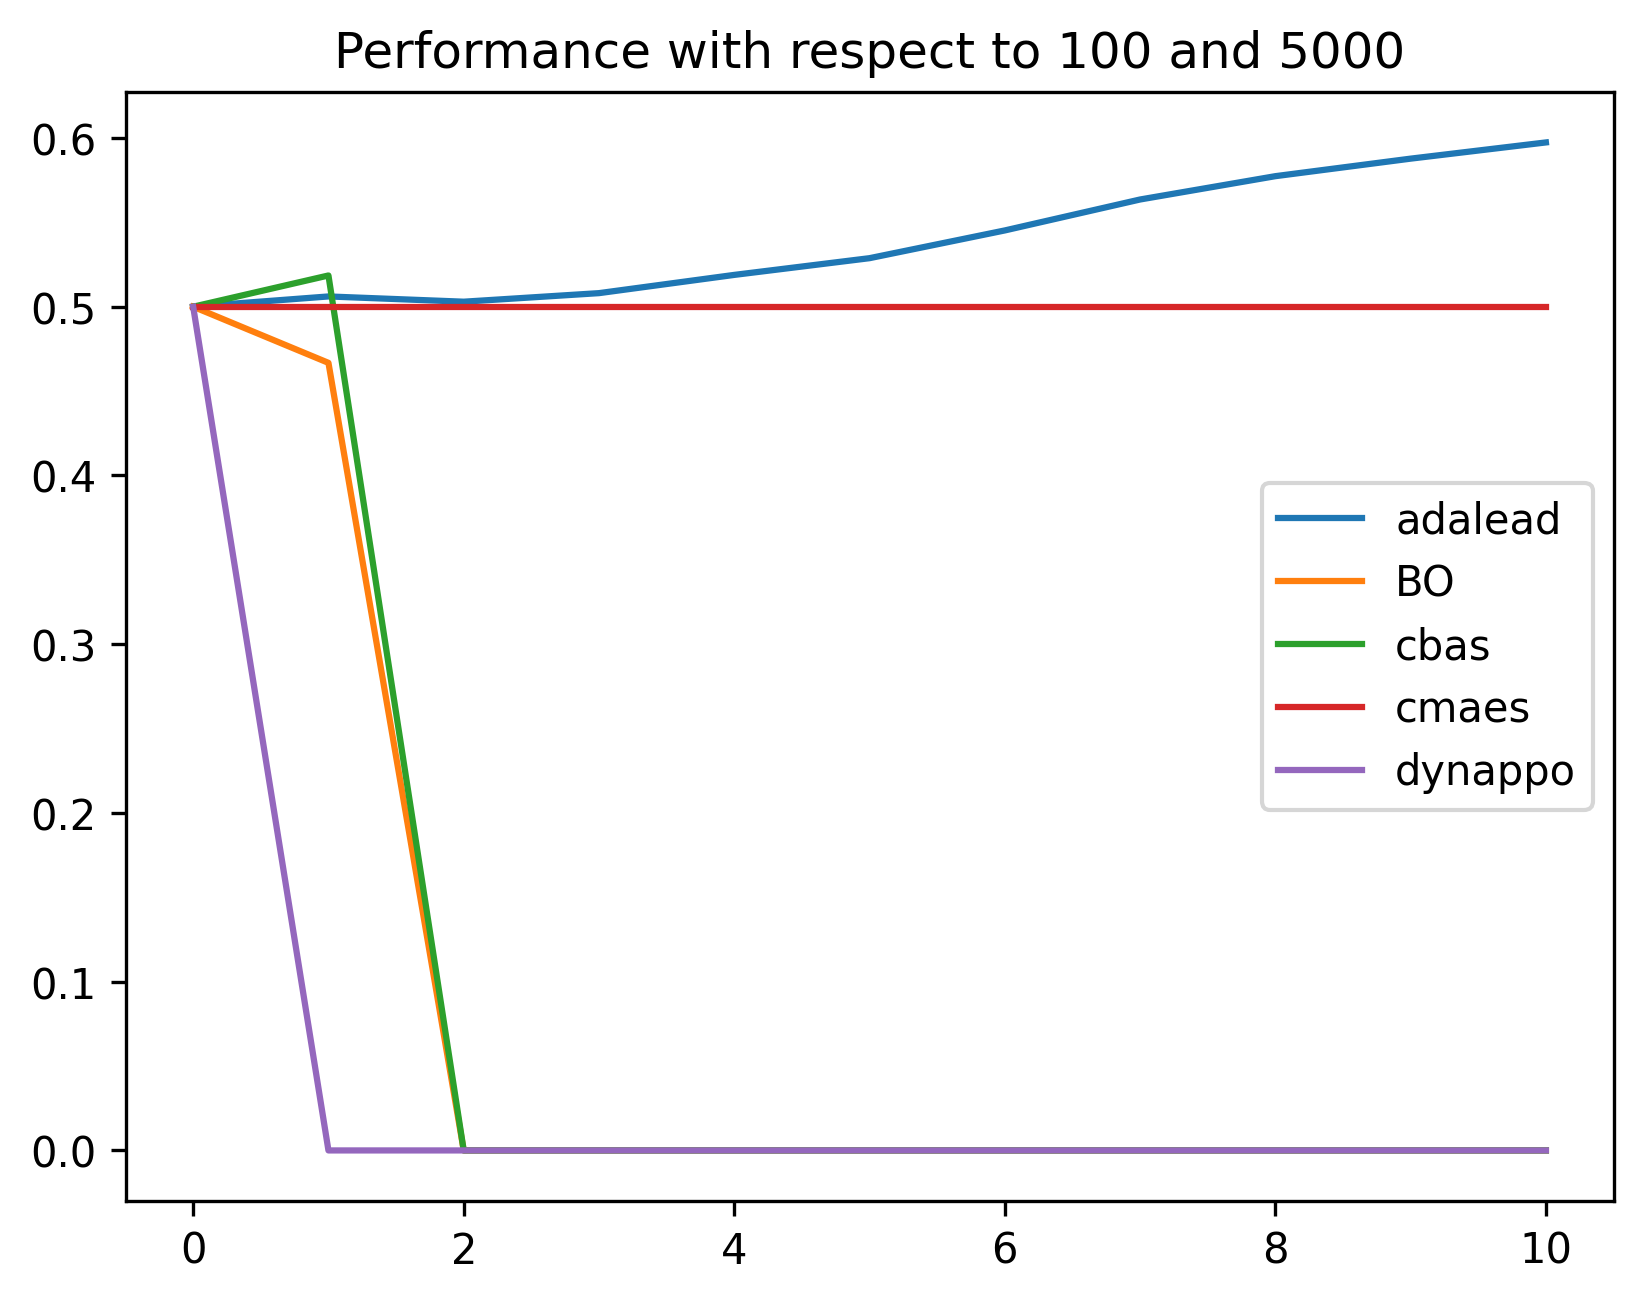

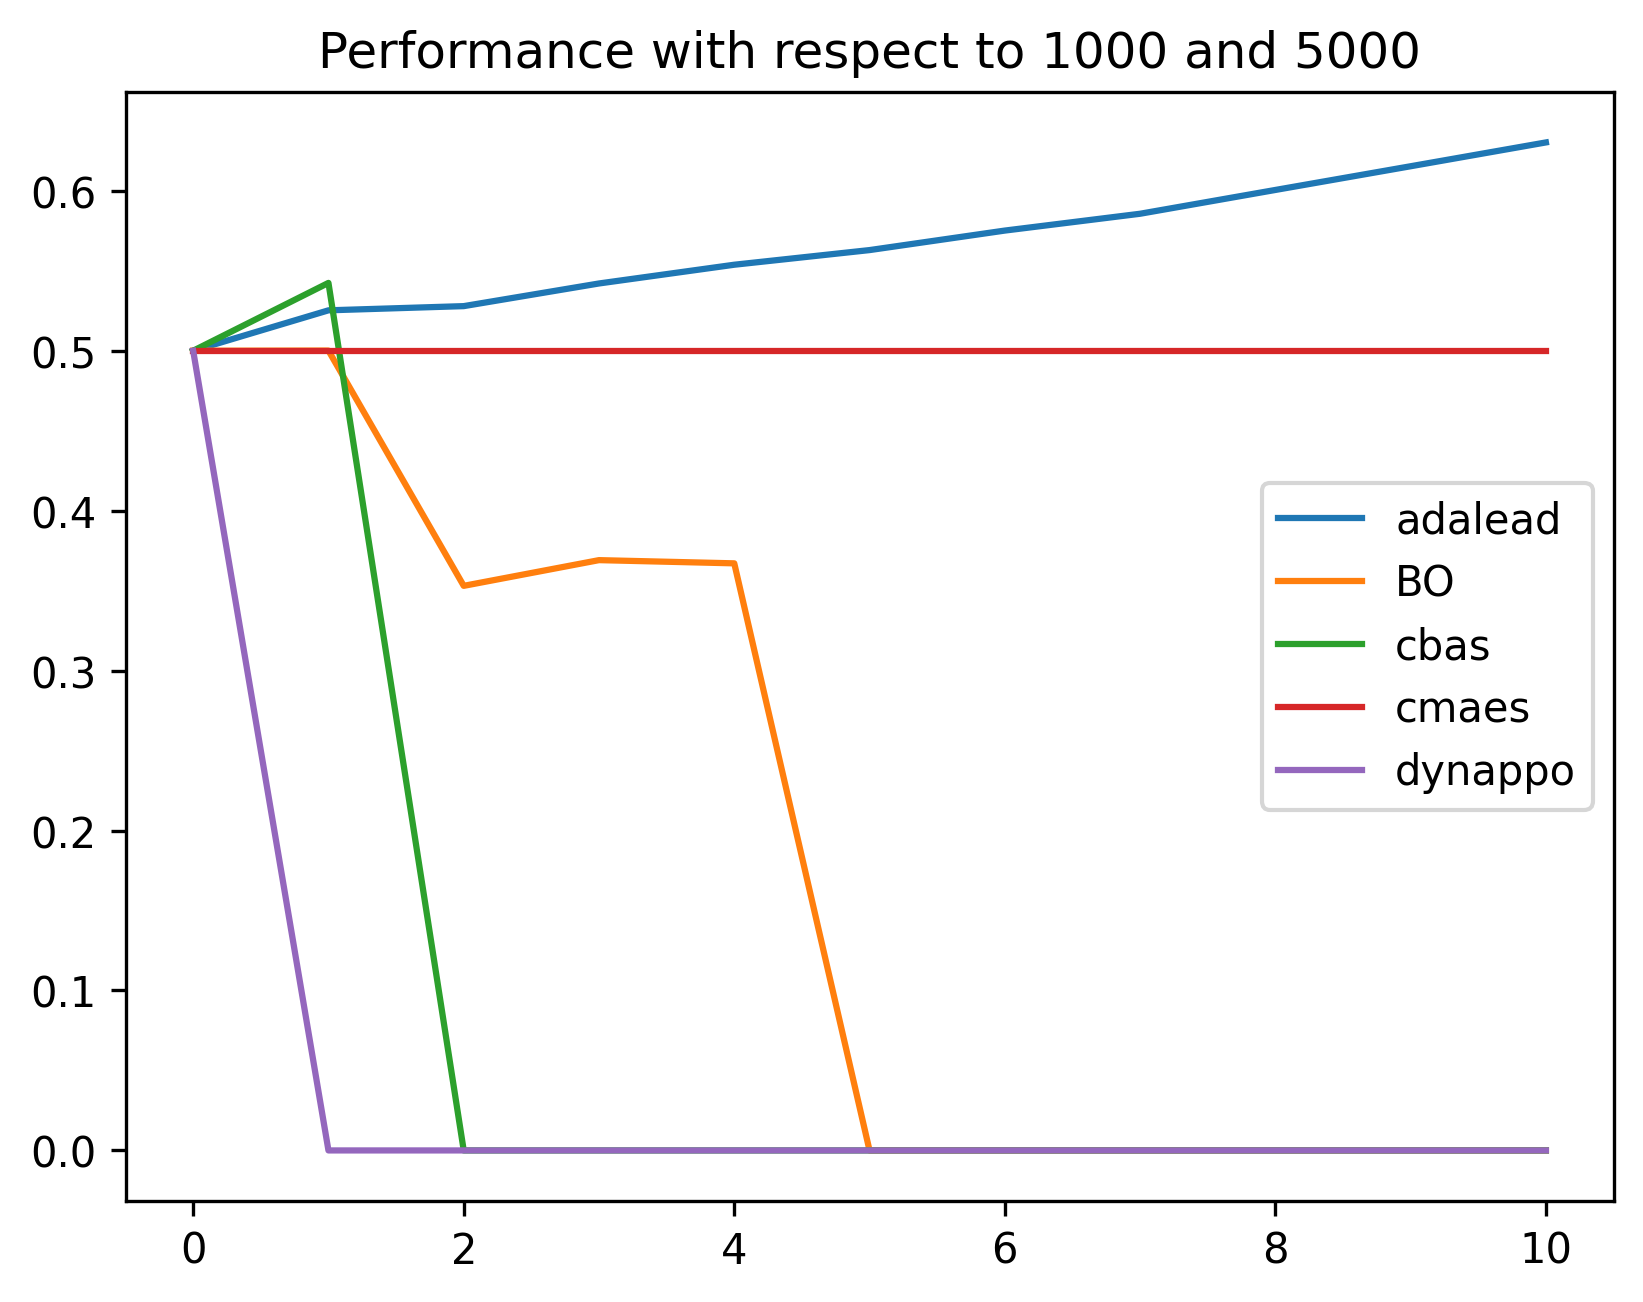

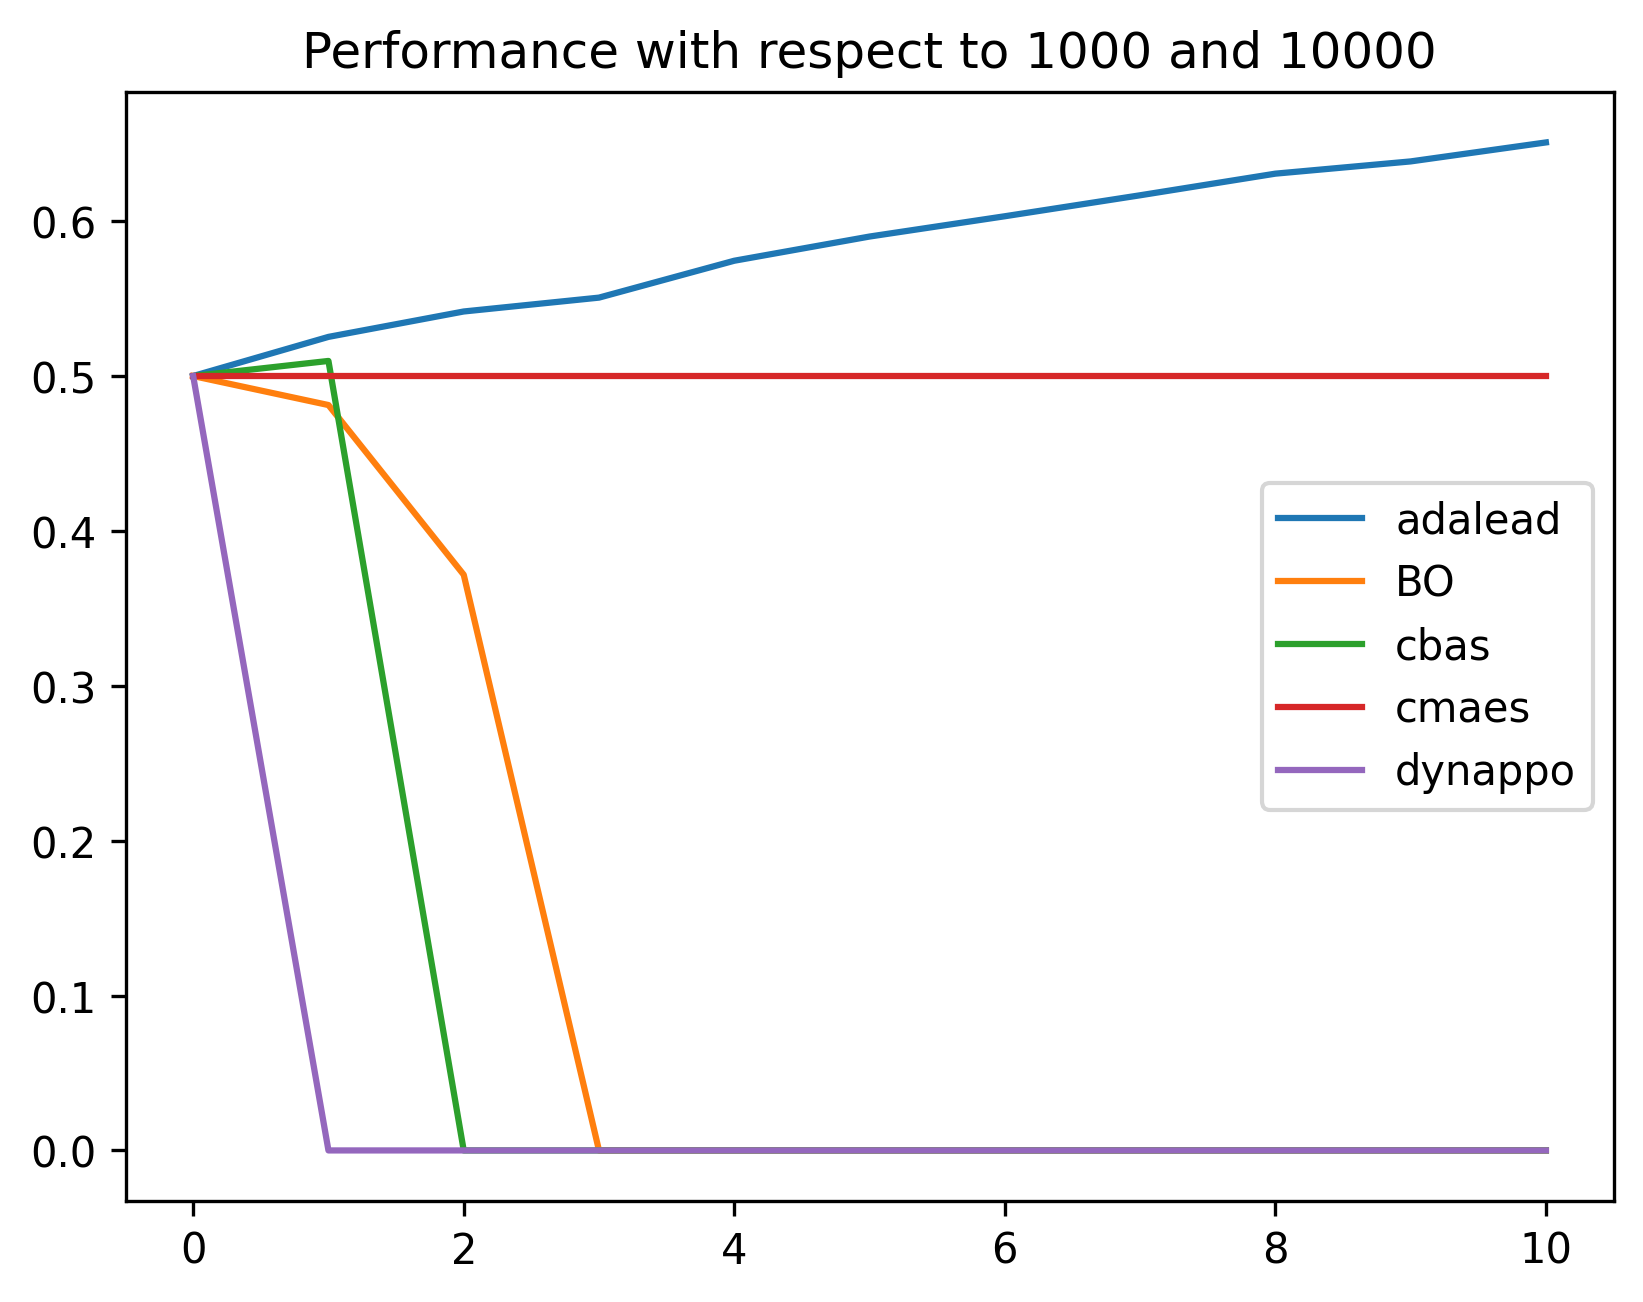

In [9]:
import matplotlib.pyplot as plt
import json
import pandas as pd


for sequences_batch_size, model_queries_per_batch in [(100, 500), (100, 5000),(1000, 5000),(1000, 10000)]:
    plt.figure(dpi=300)
    plt.title(f'Performance with respect to {sequences_batch_size} and {model_queries_per_batch}')
    for method in ['adalead', 'BO', 'cbas', 'cmaes', 'dynappo']:
        with open(f'/home/v-zhaozhiyu/code/FLEXS/efficiency/{method}/aav/{sequences_batch_size}_{model_queries_per_batch}.csv') as f:
            metadata = json.loads(next(f))
            data = pd.read_csv(f)

            rounds = data['round'].unique()

        plt.plot(rounds, [data[data['round'] == r]['true_score'].max() for r in rounds], label=f'{method}')

    plt.legend()

FileNotFoundError: [Errno 2] No such file or directory: '/home/v-zhaozhiyu/code/FLEXS/efficiency/dirichlet_ppo/rna/1000_5000.csv'

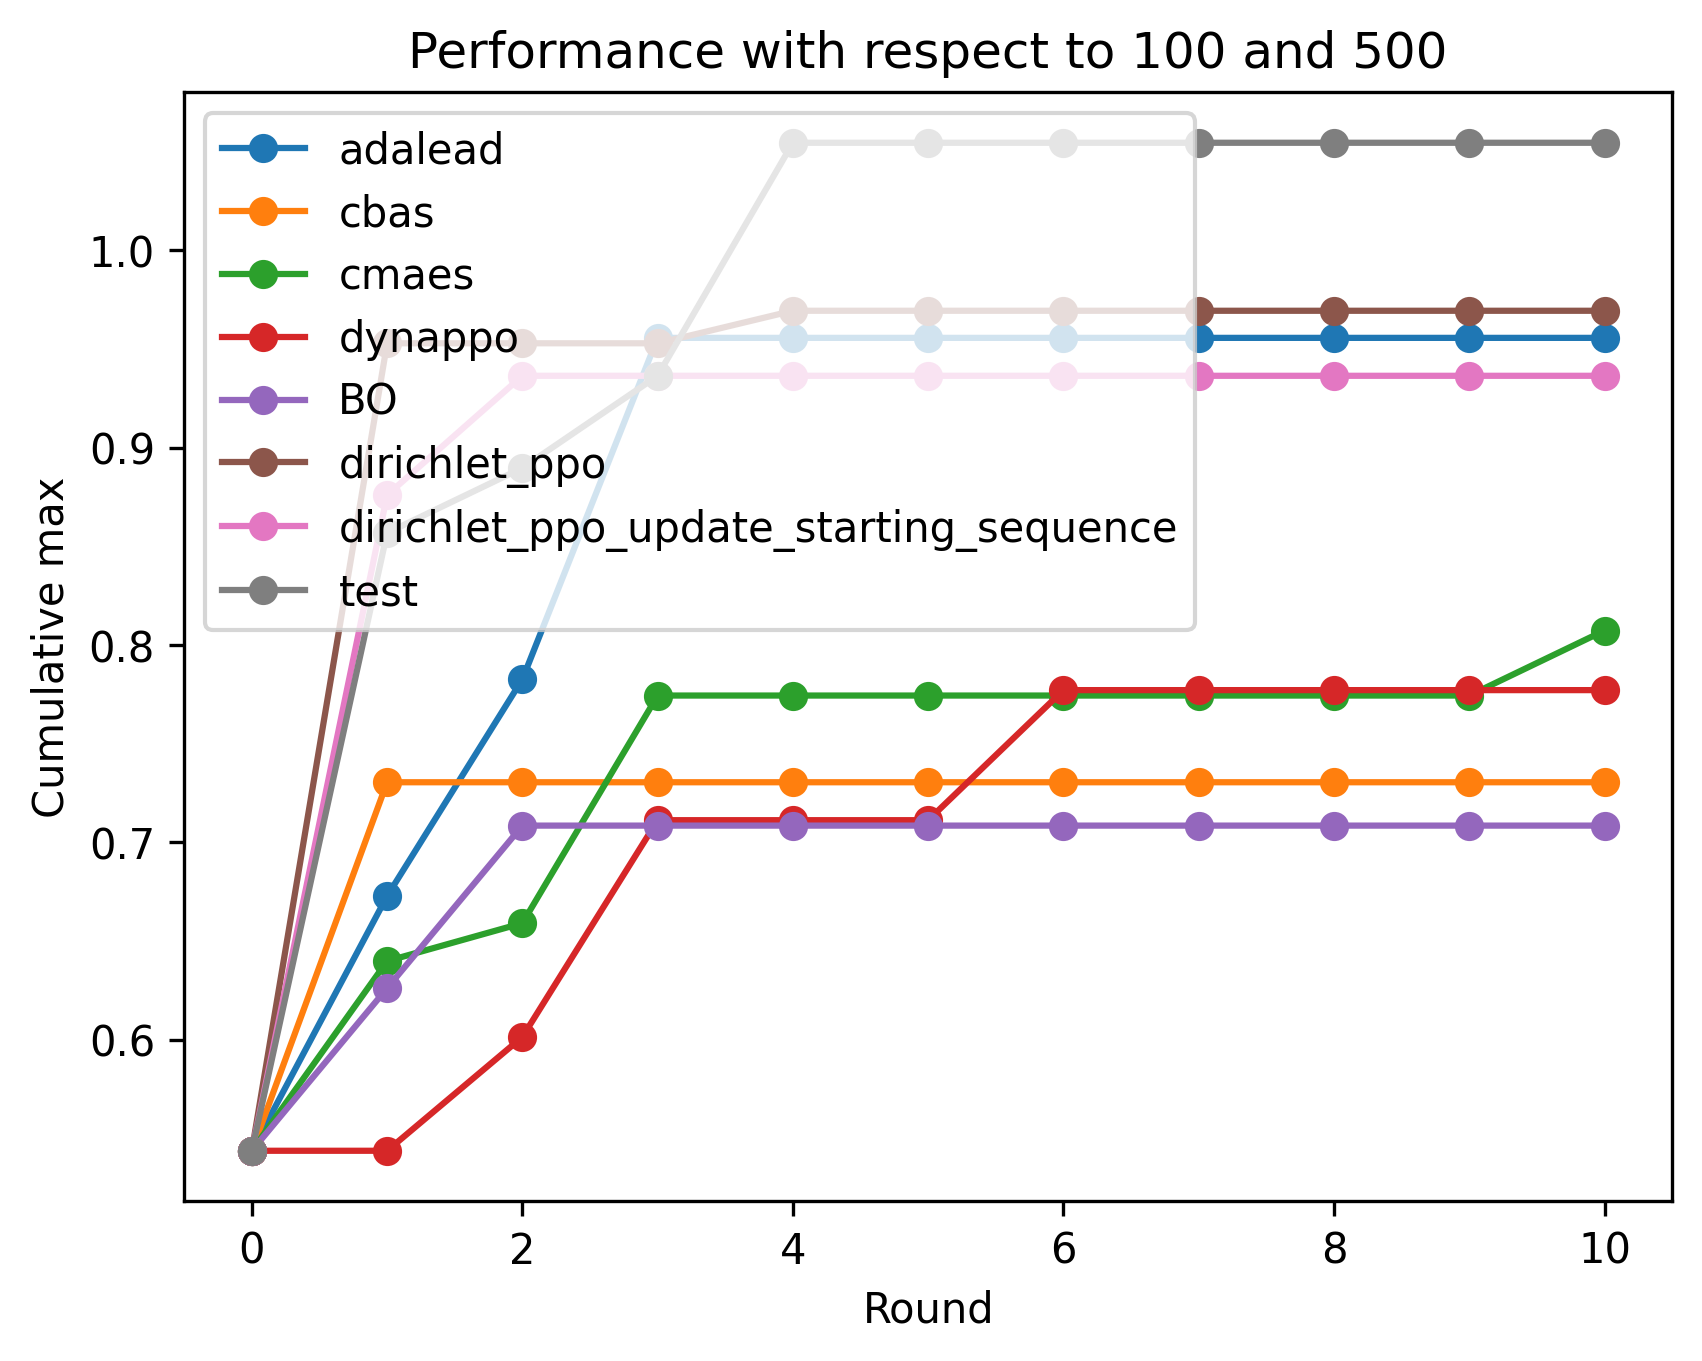

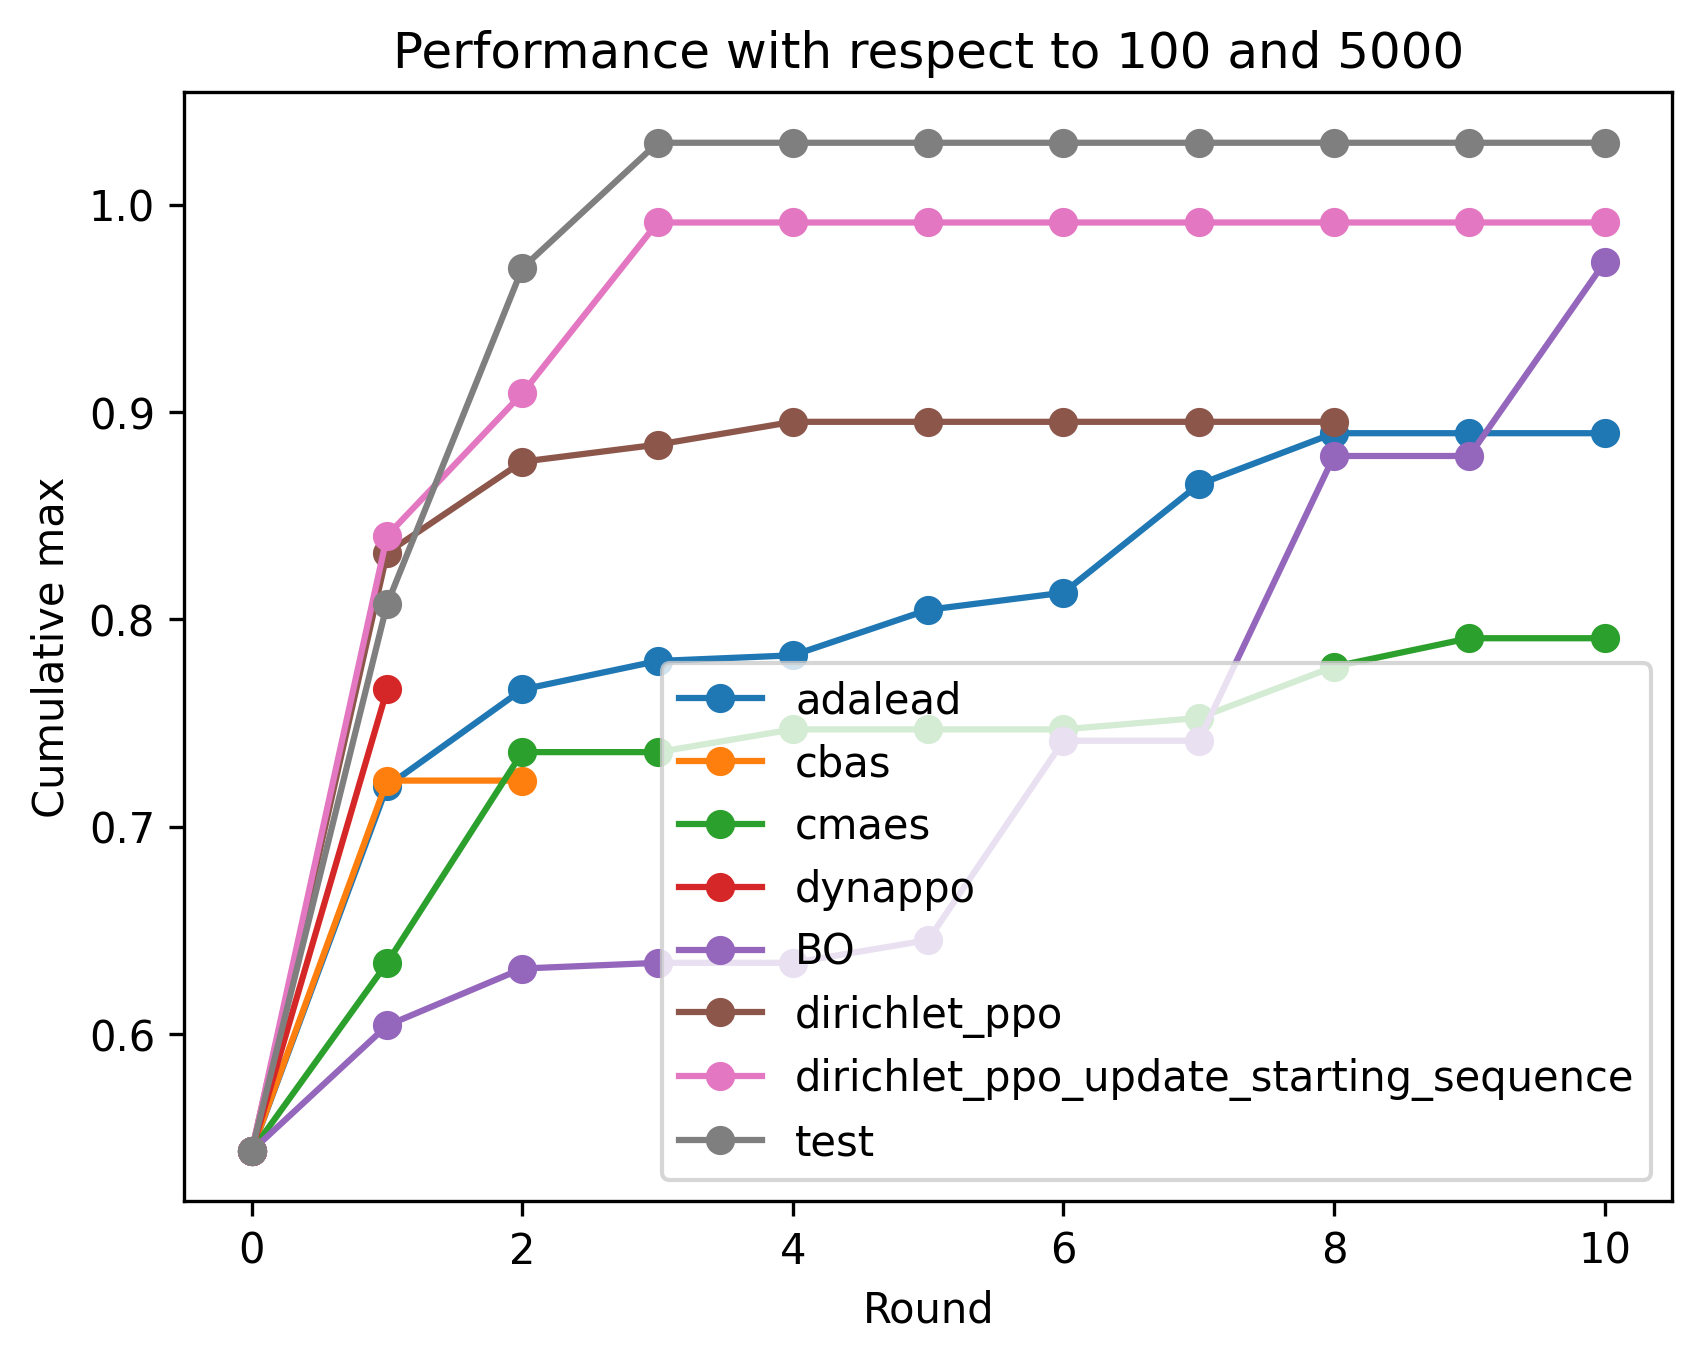

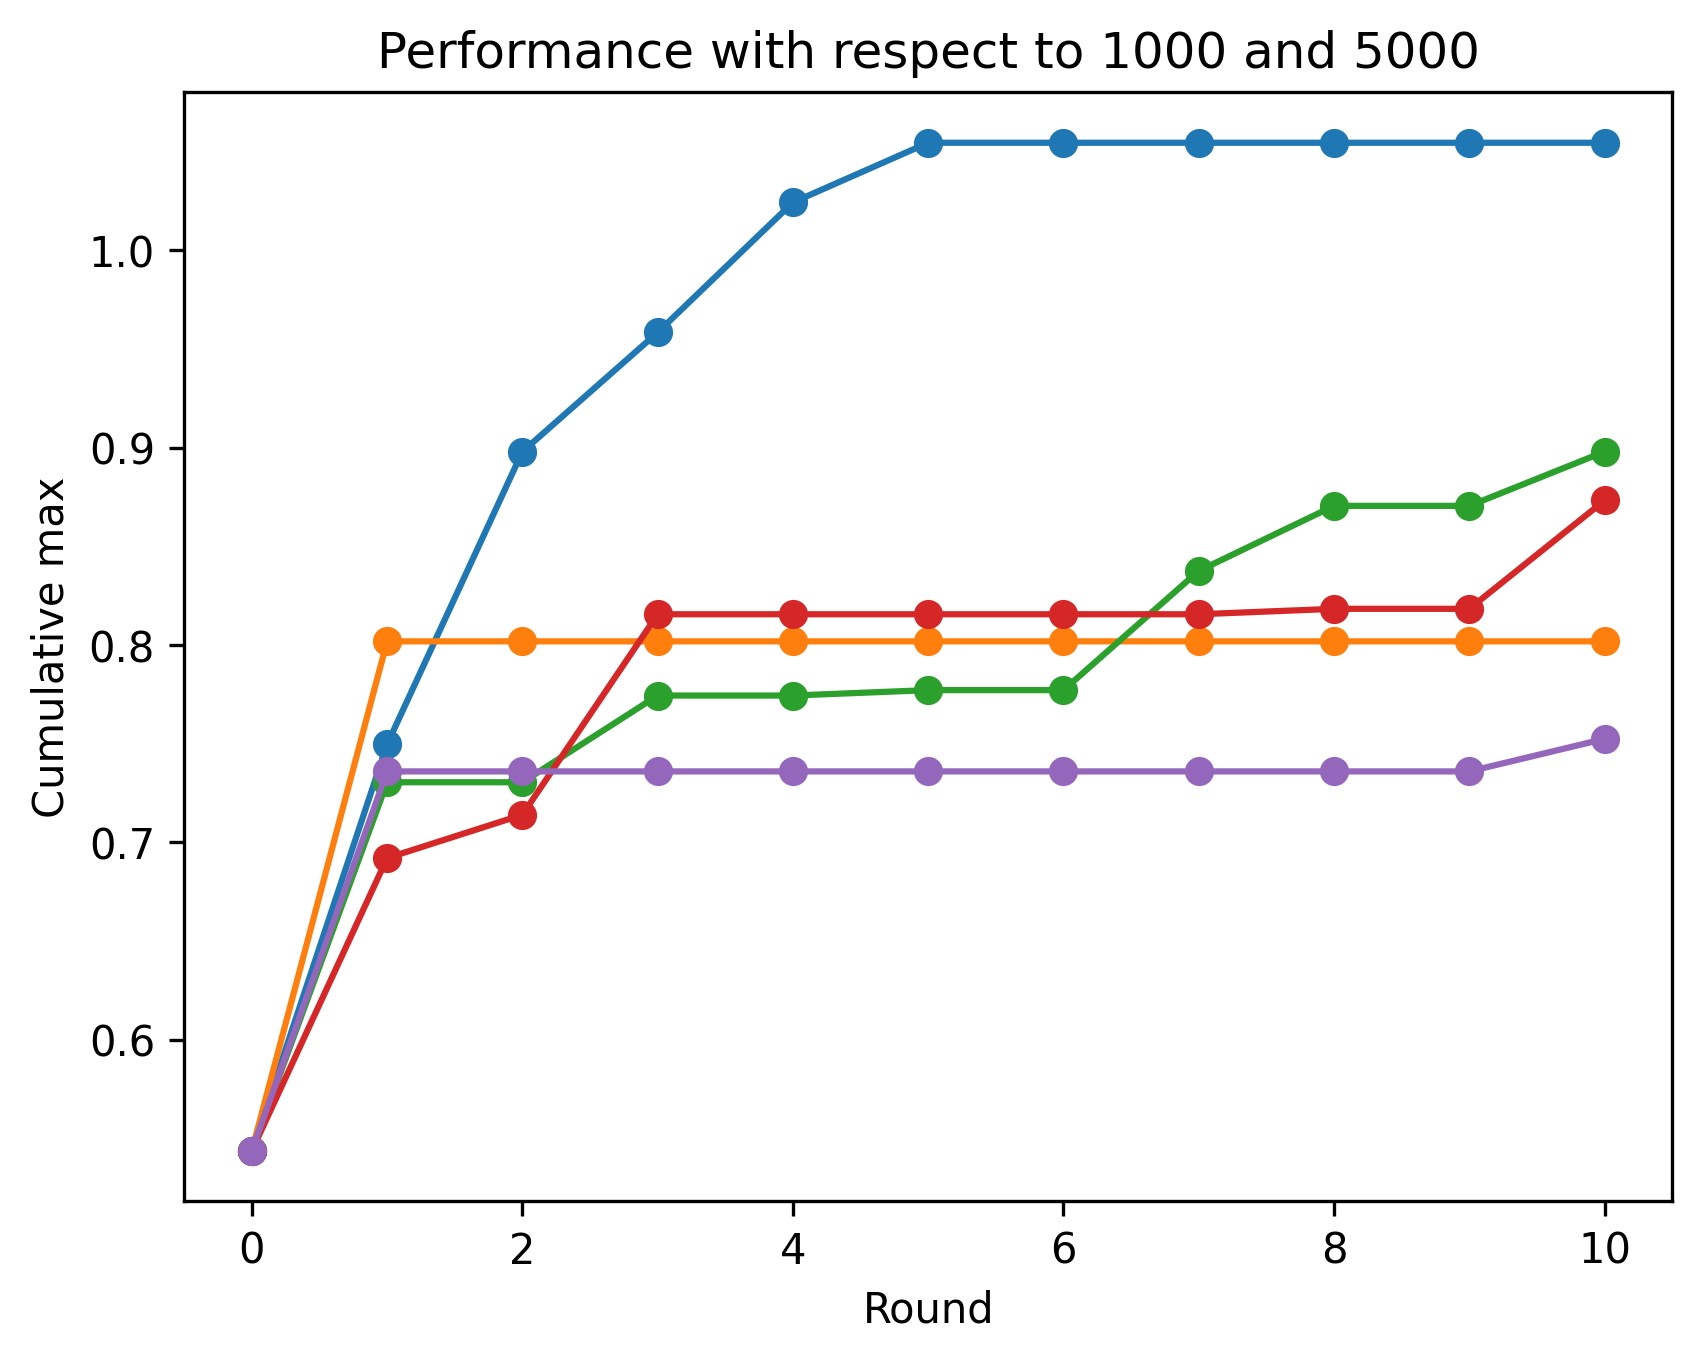

In [2]:
import matplotlib.pyplot as plt
import json
import pandas as pd
import numpy as np


def cumulative_max_per_round(sequences):
    num_rounds = sequences['round'].max() + 1
    max_per_round = [sequences['true_score'][sequences['round'] == r].max()
                     for r in range(num_rounds)]

    return np.maximum.accumulate(max_per_round)


for sequences_batch_size, model_queries_per_batch in [(100, 500), (100, 5000),(1000, 5000)]:
    plt.figure(dpi=300)
    plt.title(f'Performance with respect to {sequences_batch_size} and {model_queries_per_batch}')
    for method in ['adalead', 'cbas', 'cmaes', 'dynappo', 'BO', 'dirichlet_ppo', 'dirichlet_ppo_update_starting_sequence', 'test']:
        with open(f'/home/v-zhaozhiyu/code/FLEXS/efficiency/{method}/rna/{sequences_batch_size}_{model_queries_per_batch}.csv') as f:
            metadata = json.loads(next(f))
            data = pd.read_csv(f)

            rounds = data['round'].unique()
            max_per_round = cumulative_max_per_round(data)

        plt.plot(rounds, max_per_round, '-o', label=f'{method}')
        plt.ylabel("Cumulative max")
        plt.xlabel("Round")

    plt.legend()

FileNotFoundError: [Errno 2] No such file or directory: '/home/v-zhaozhiyu/code/FLEXS/efficiency/dirichlet_ppo/tf/1000_5000.csv'

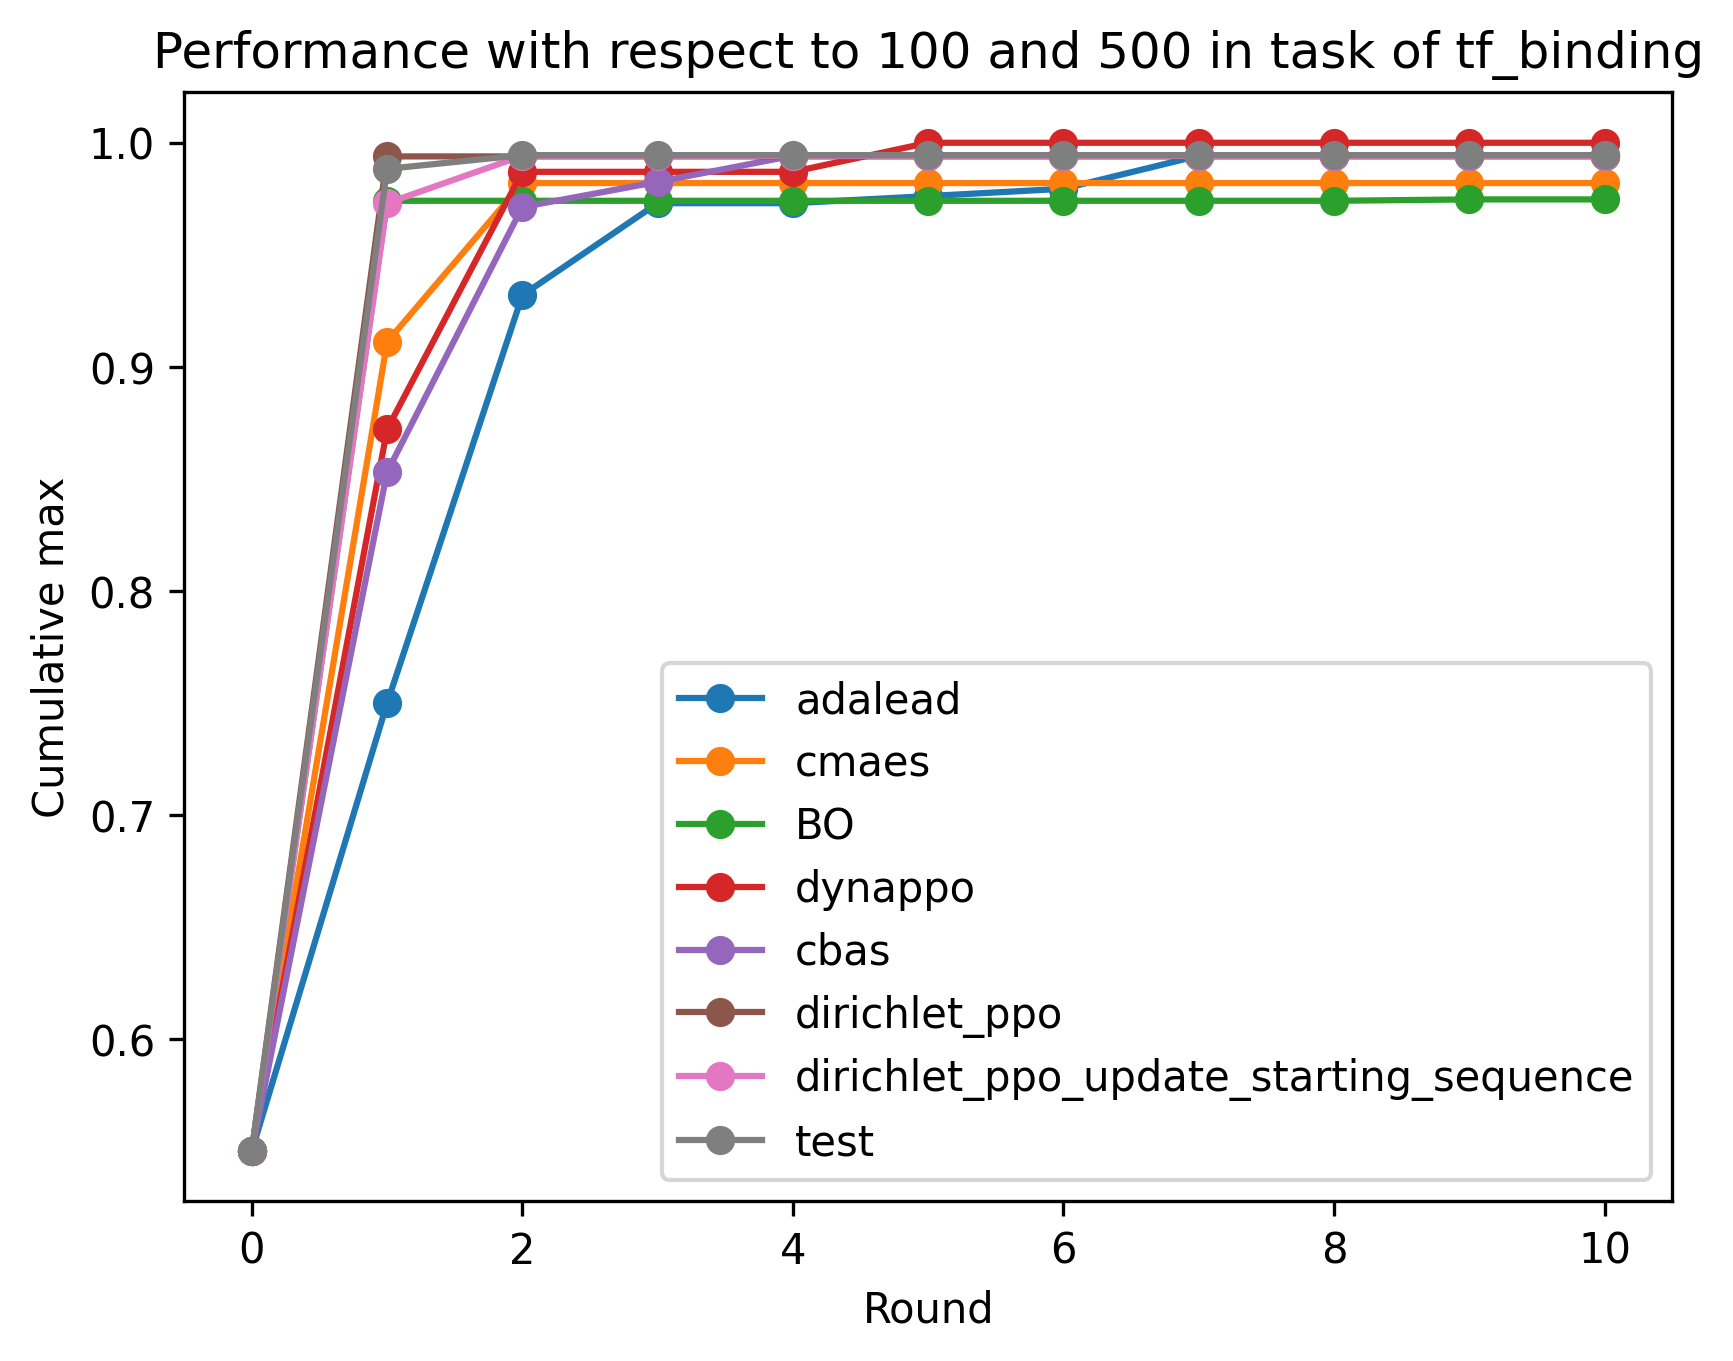

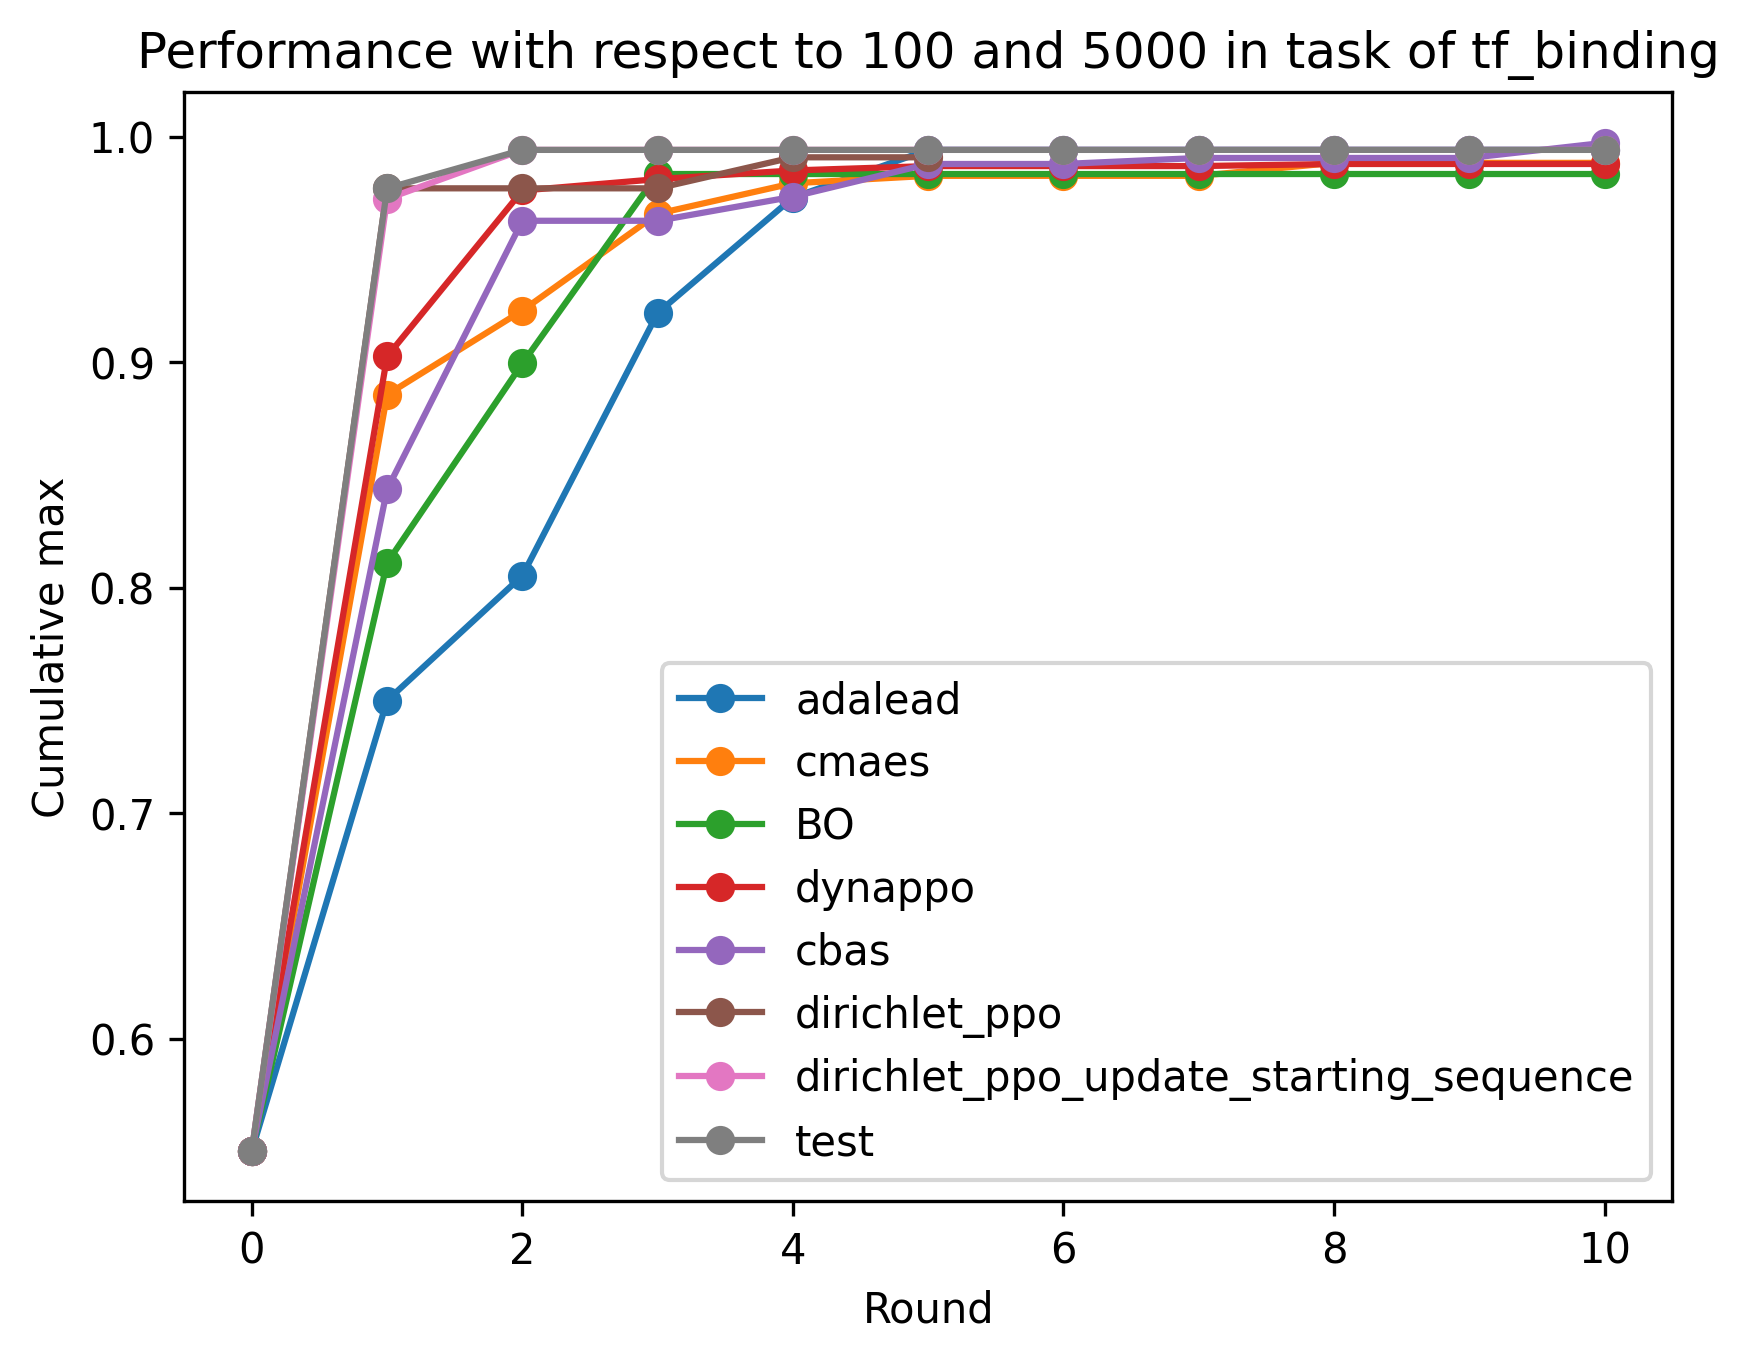

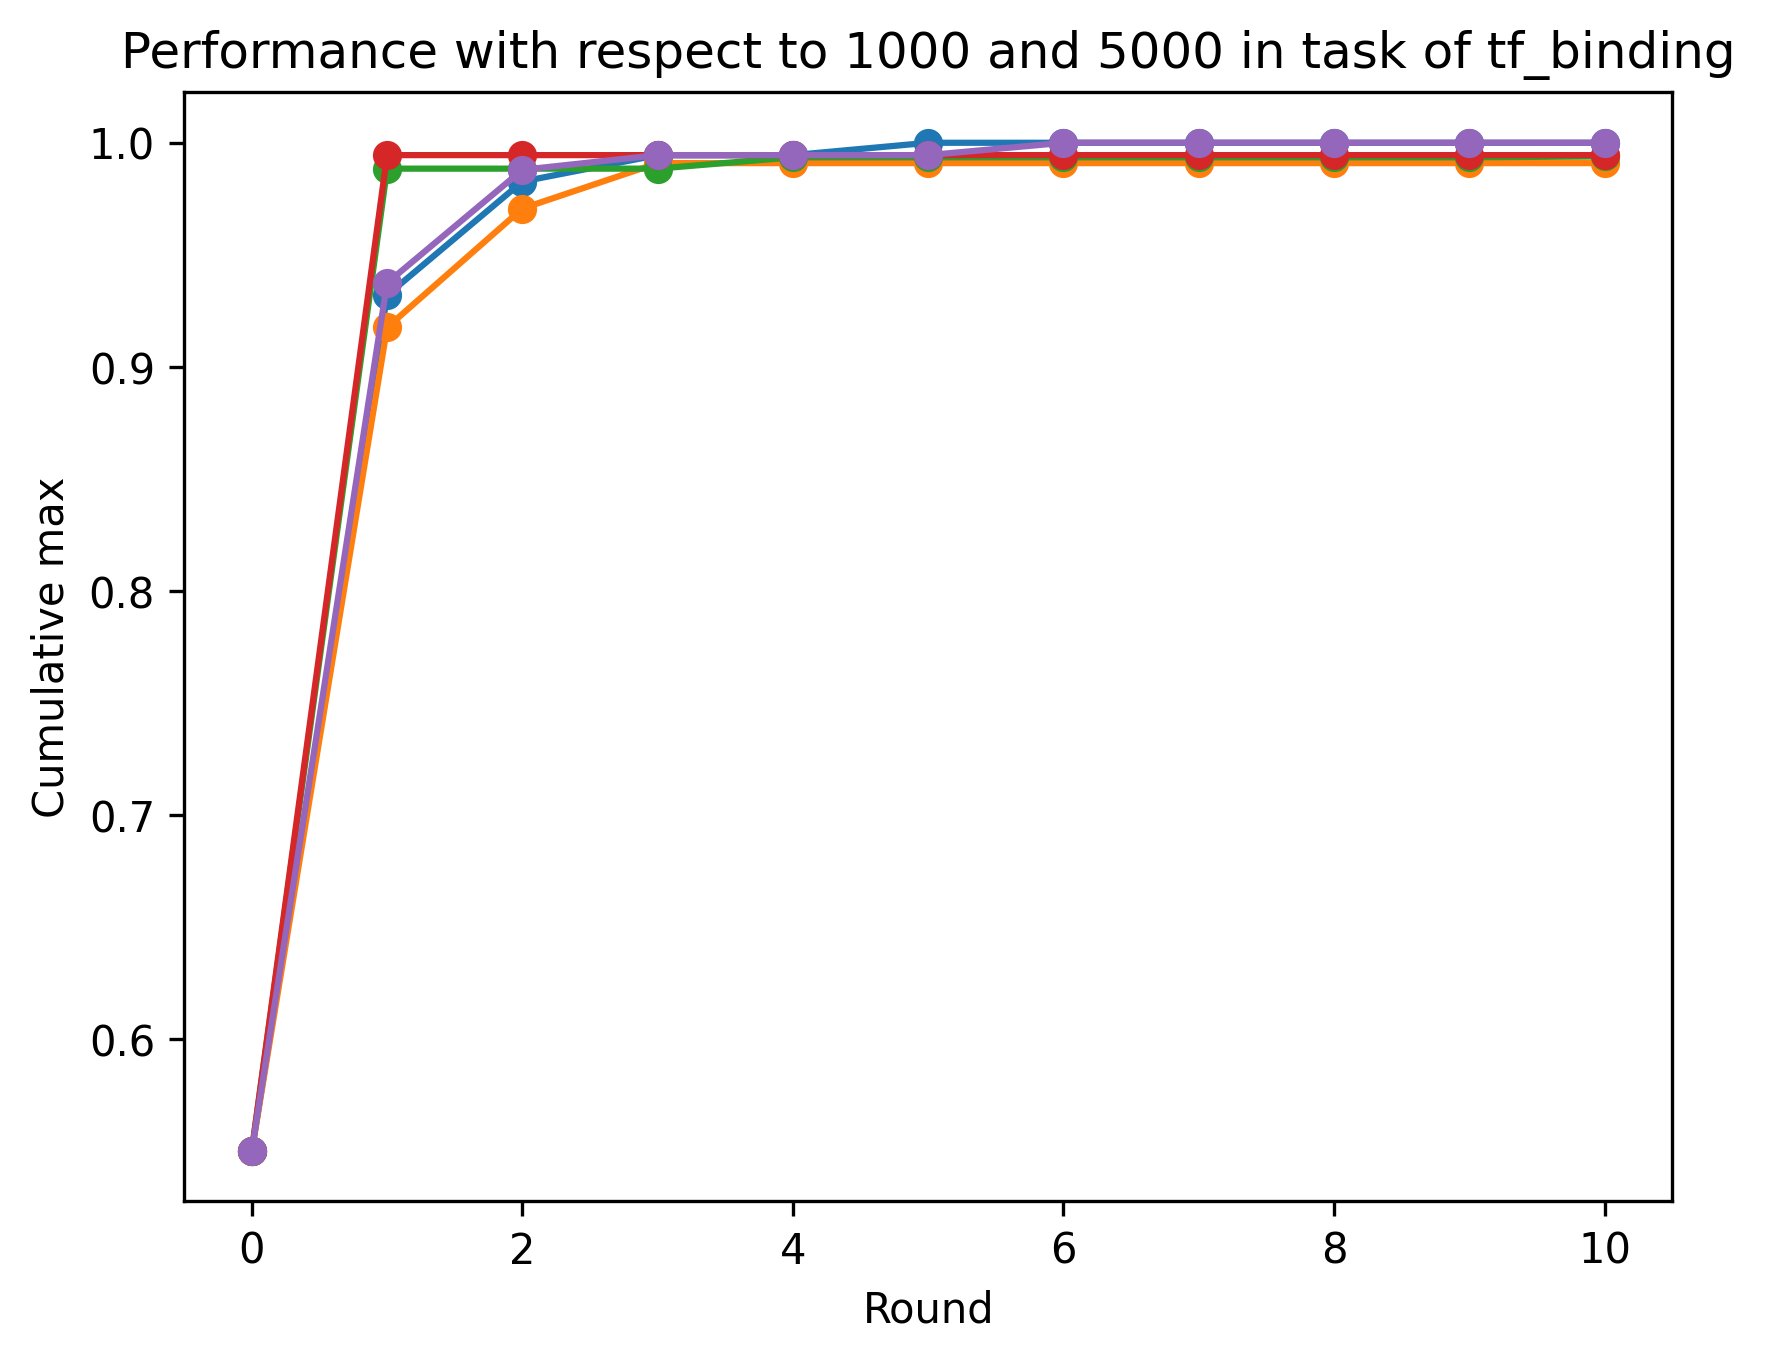

In [3]:
import matplotlib.pyplot as plt
import json
import pandas as pd
import numpy as np


def cumulative_max_per_round(sequences):
    num_rounds = sequences['round'].max() + 1
    max_per_round = [sequences['true_score'][sequences['round'] == r].max()
                     for r in range(num_rounds)]

    return np.maximum.accumulate(max_per_round)


for sequences_batch_size, model_queries_per_batch in [(100, 500), (100, 5000),(1000, 5000)]:
    plt.figure(dpi=300)
    plt.title(f'Performance with respect to {sequences_batch_size} and {model_queries_per_batch} in task of tf_binding')
    for method in ['adalead', 'cmaes', 'BO', 'dynappo', 'cbas', 'dirichlet_ppo', 'dirichlet_ppo_update_starting_sequence', 'test']:
        with open(f'/home/v-zhaozhiyu/code/FLEXS/efficiency/{method}/tf/{sequences_batch_size}_{model_queries_per_batch}.csv') as f:
            metadata = json.loads(next(f))
            data = pd.read_csv(f)

            rounds = data['round'].unique()
            max_per_round = cumulative_max_per_round(data)

        plt.plot(rounds, max_per_round, '-o', label=f'{method}')
        plt.ylabel("Cumulative max")
        plt.xlabel("Round")

    plt.legend()

FileNotFoundError: [Errno 2] No such file or directory: '/home/v-zhaozhiyu/code/FLEXS/efficiency/dirichlet_ppo/rosetta/1000_5000.csv'

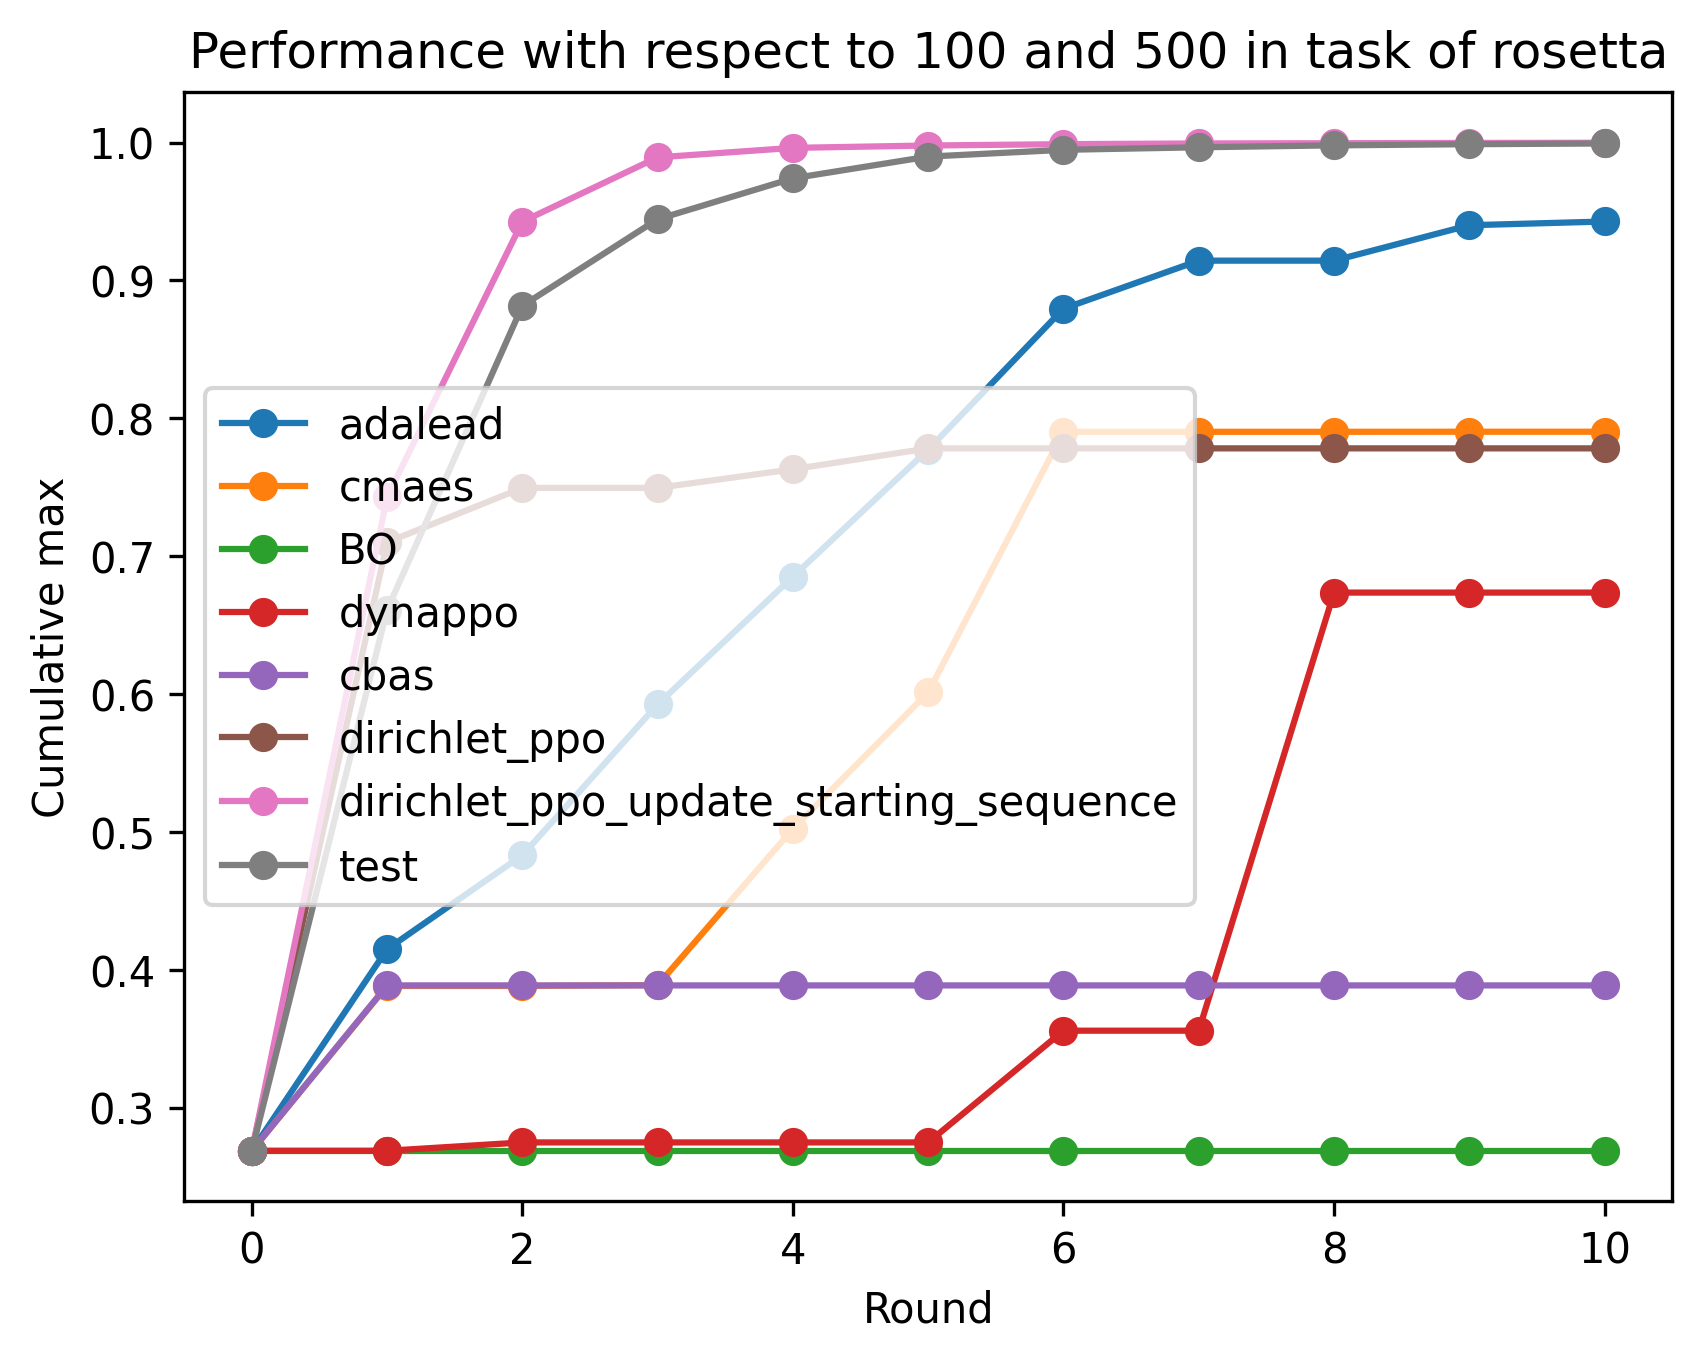

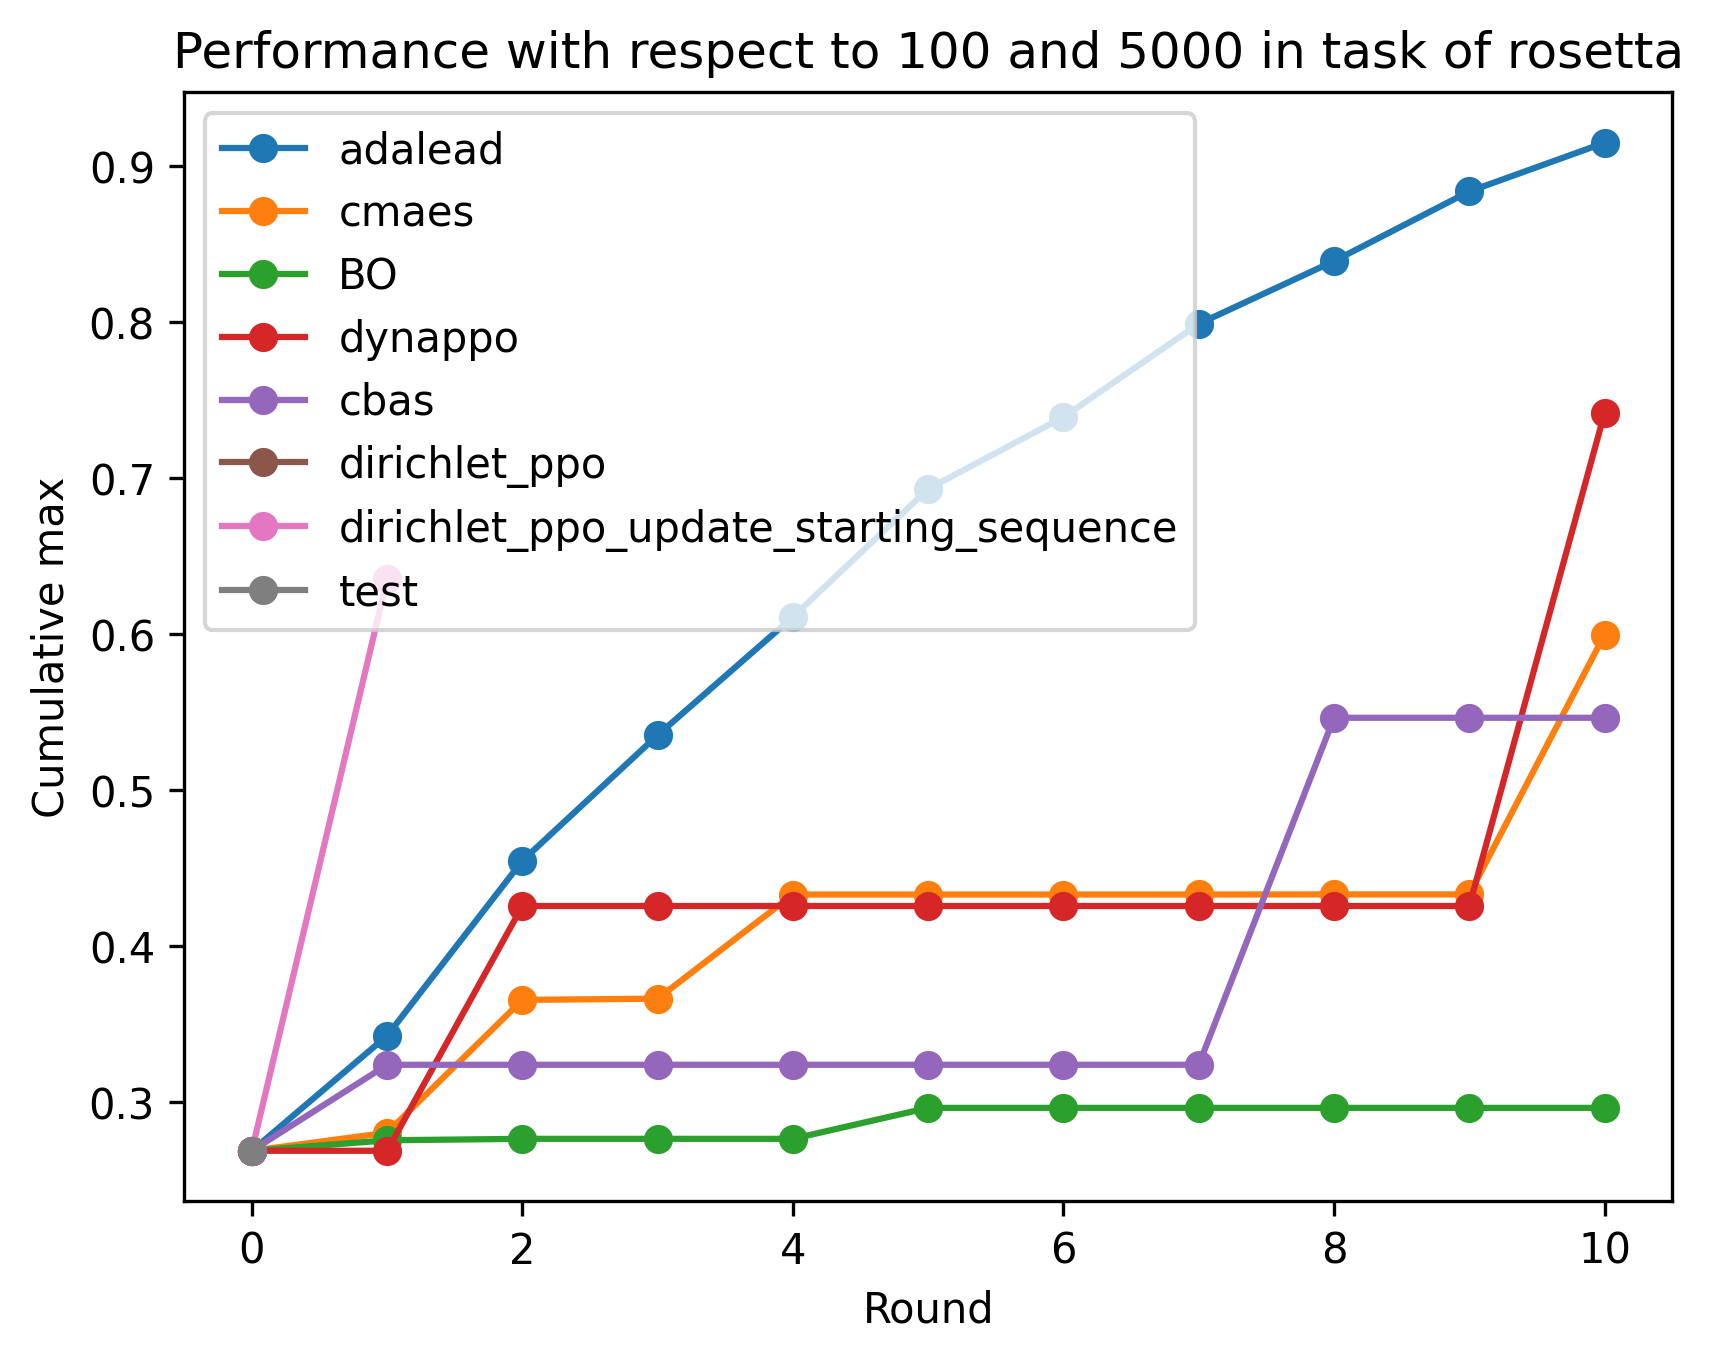

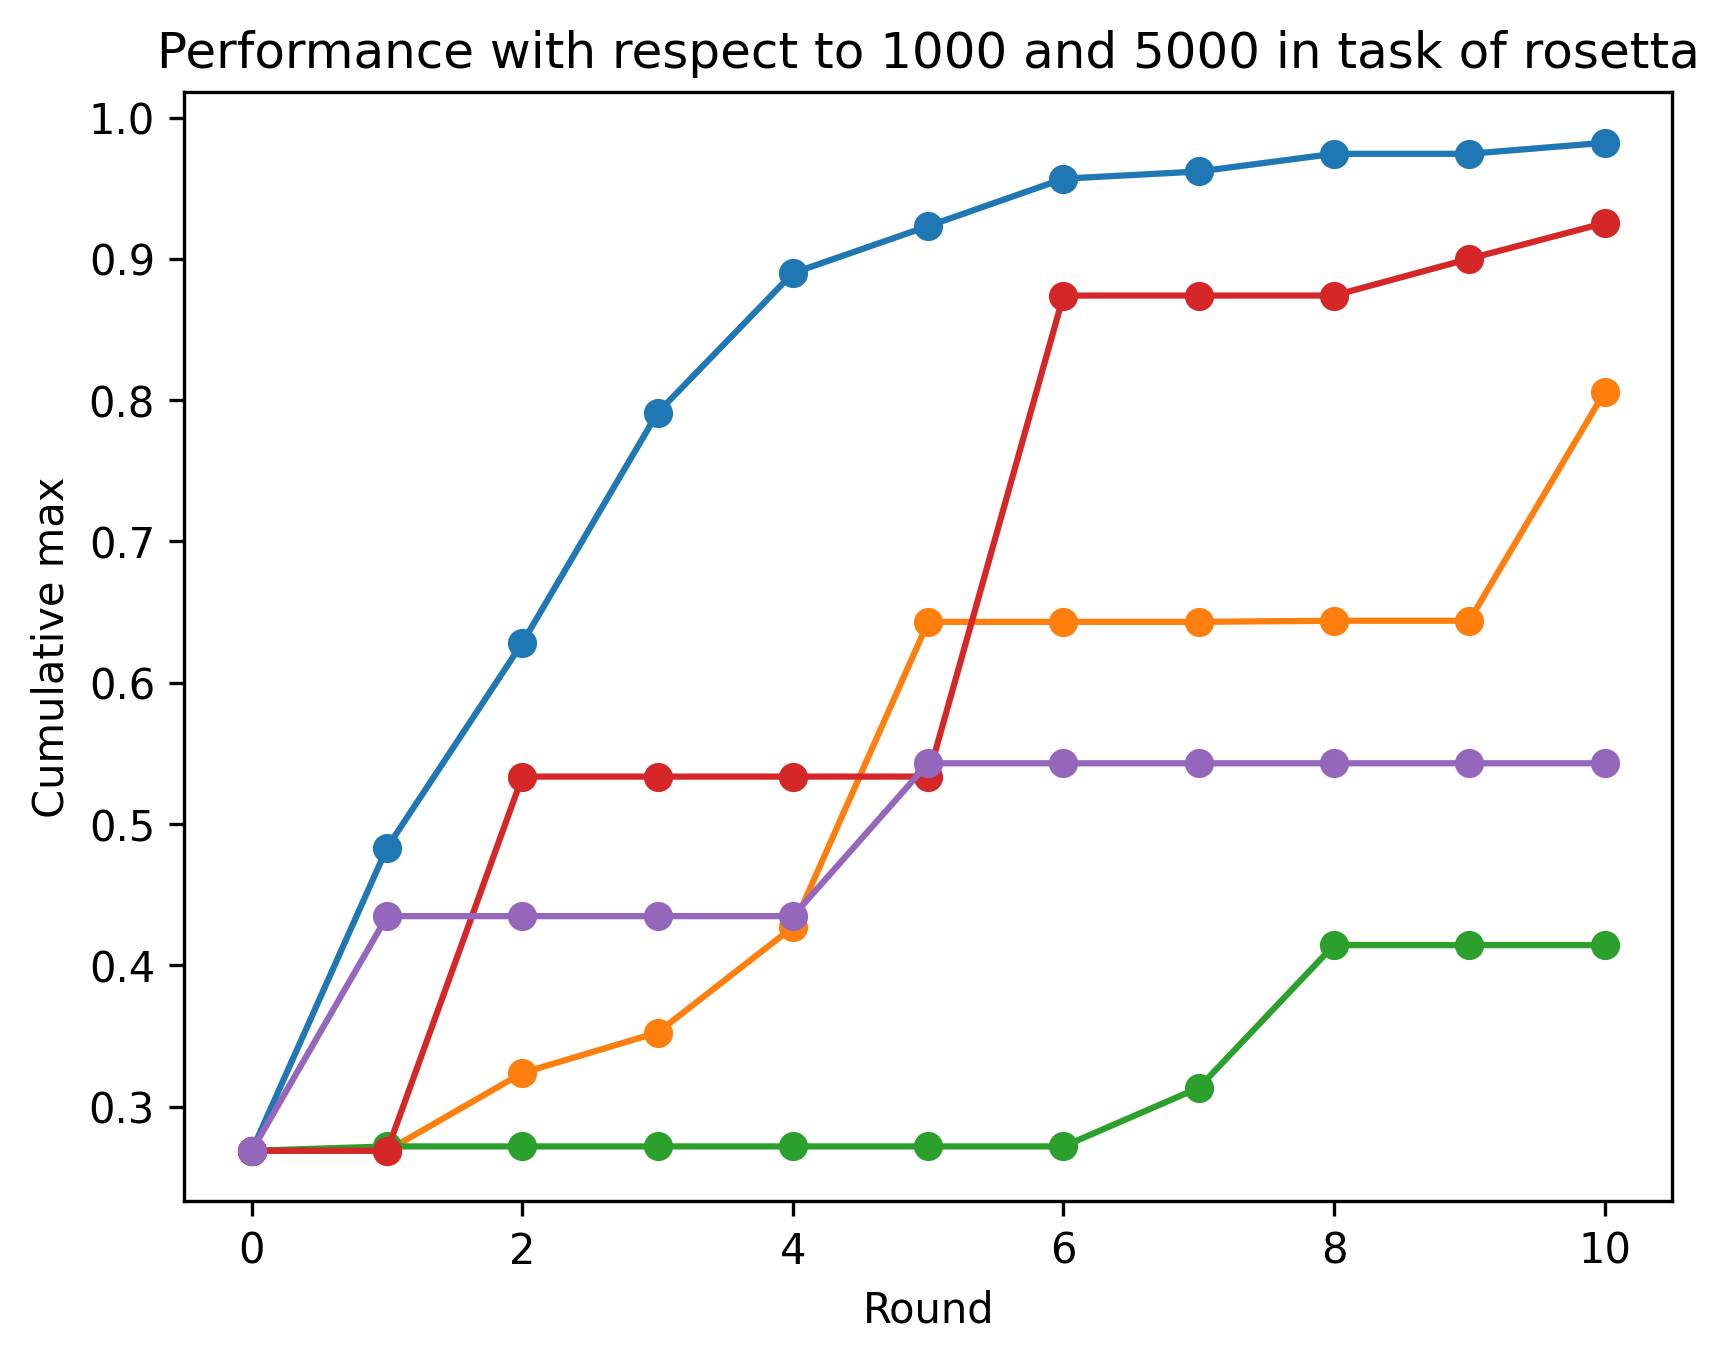

In [9]:
import matplotlib.pyplot as plt
import json
import pandas as pd
import numpy as np


def cumulative_max_per_round(sequences):
    num_rounds = sequences['round'].max() + 1
    max_per_round = [sequences['true_score'][sequences['round'] == r].max()
                     for r in range(num_rounds)]

    return np.maximum.accumulate(max_per_round)


for sequences_batch_size, model_queries_per_batch in [(100, 500), (100, 5000),(1000, 5000)]:
    plt.figure(dpi=300)
    plt.title(f'Performance with respect to {sequences_batch_size} and {model_queries_per_batch} in task of rosetta')
    for method in ['adalead', 'cmaes', 'BO', 'dynappo', 'cbas', 'dirichlet_ppo', 'dirichlet_ppo_update_starting_sequence', 'test']:
        with open(f'/home/v-zhaozhiyu/code/FLEXS/efficiency/{method}/rosetta/{sequences_batch_size}_{model_queries_per_batch}.csv') as f:
            metadata = json.loads(next(f))
            data = pd.read_csv(f)

            rounds = data['round'].unique()
            max_per_round = cumulative_max_per_round(data)

        plt.plot(rounds, max_per_round, '-o', label=f'{method}')
        plt.ylabel("Cumulative max")
        plt.xlabel("Round")

    plt.legend()

FileNotFoundError: [Errno 2] No such file or directory: '/home/v-zhaozhiyu/code/FLEXS/efficiency/dirichlet_ppo/aav/1000_5000.csv'

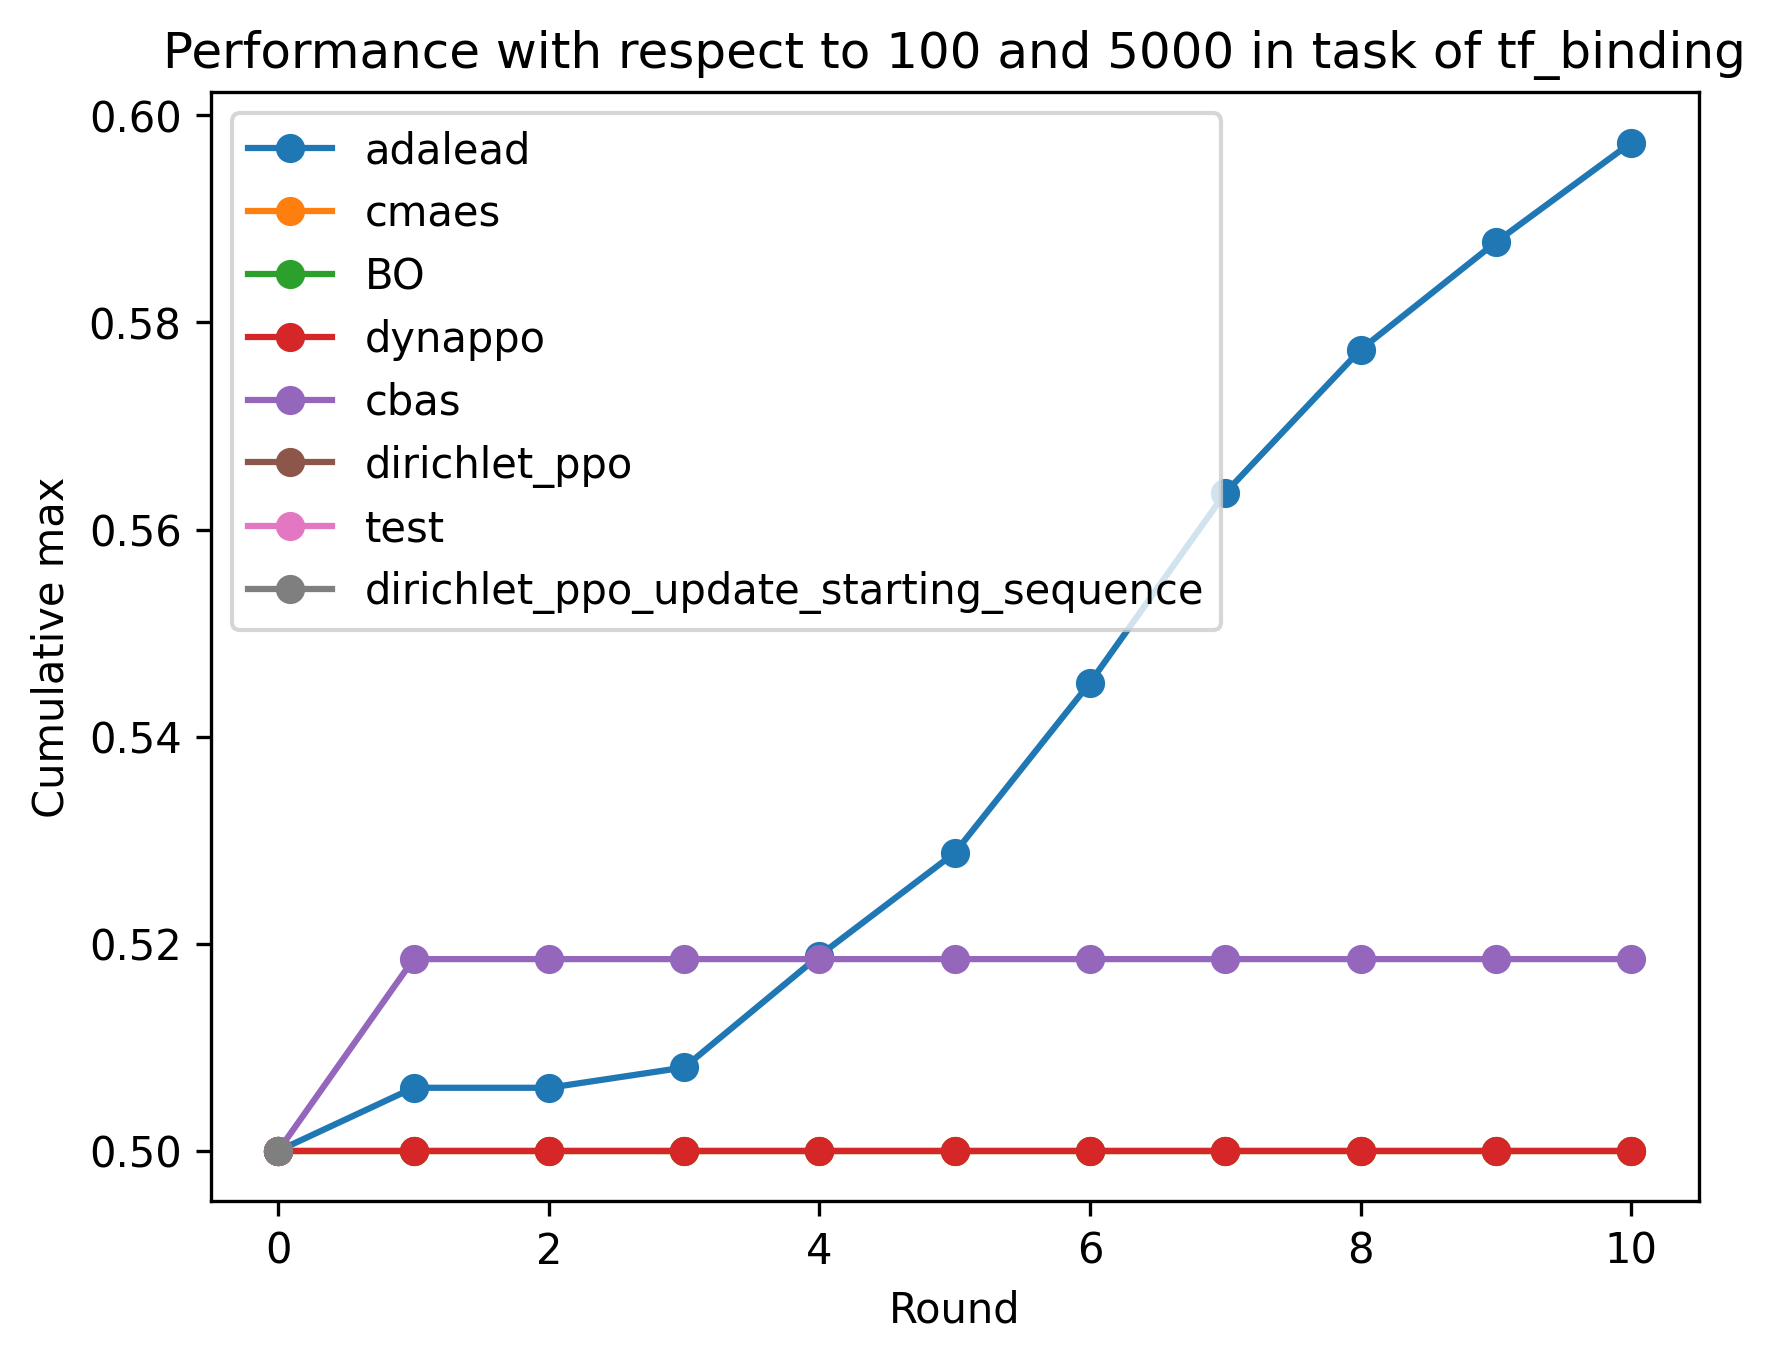

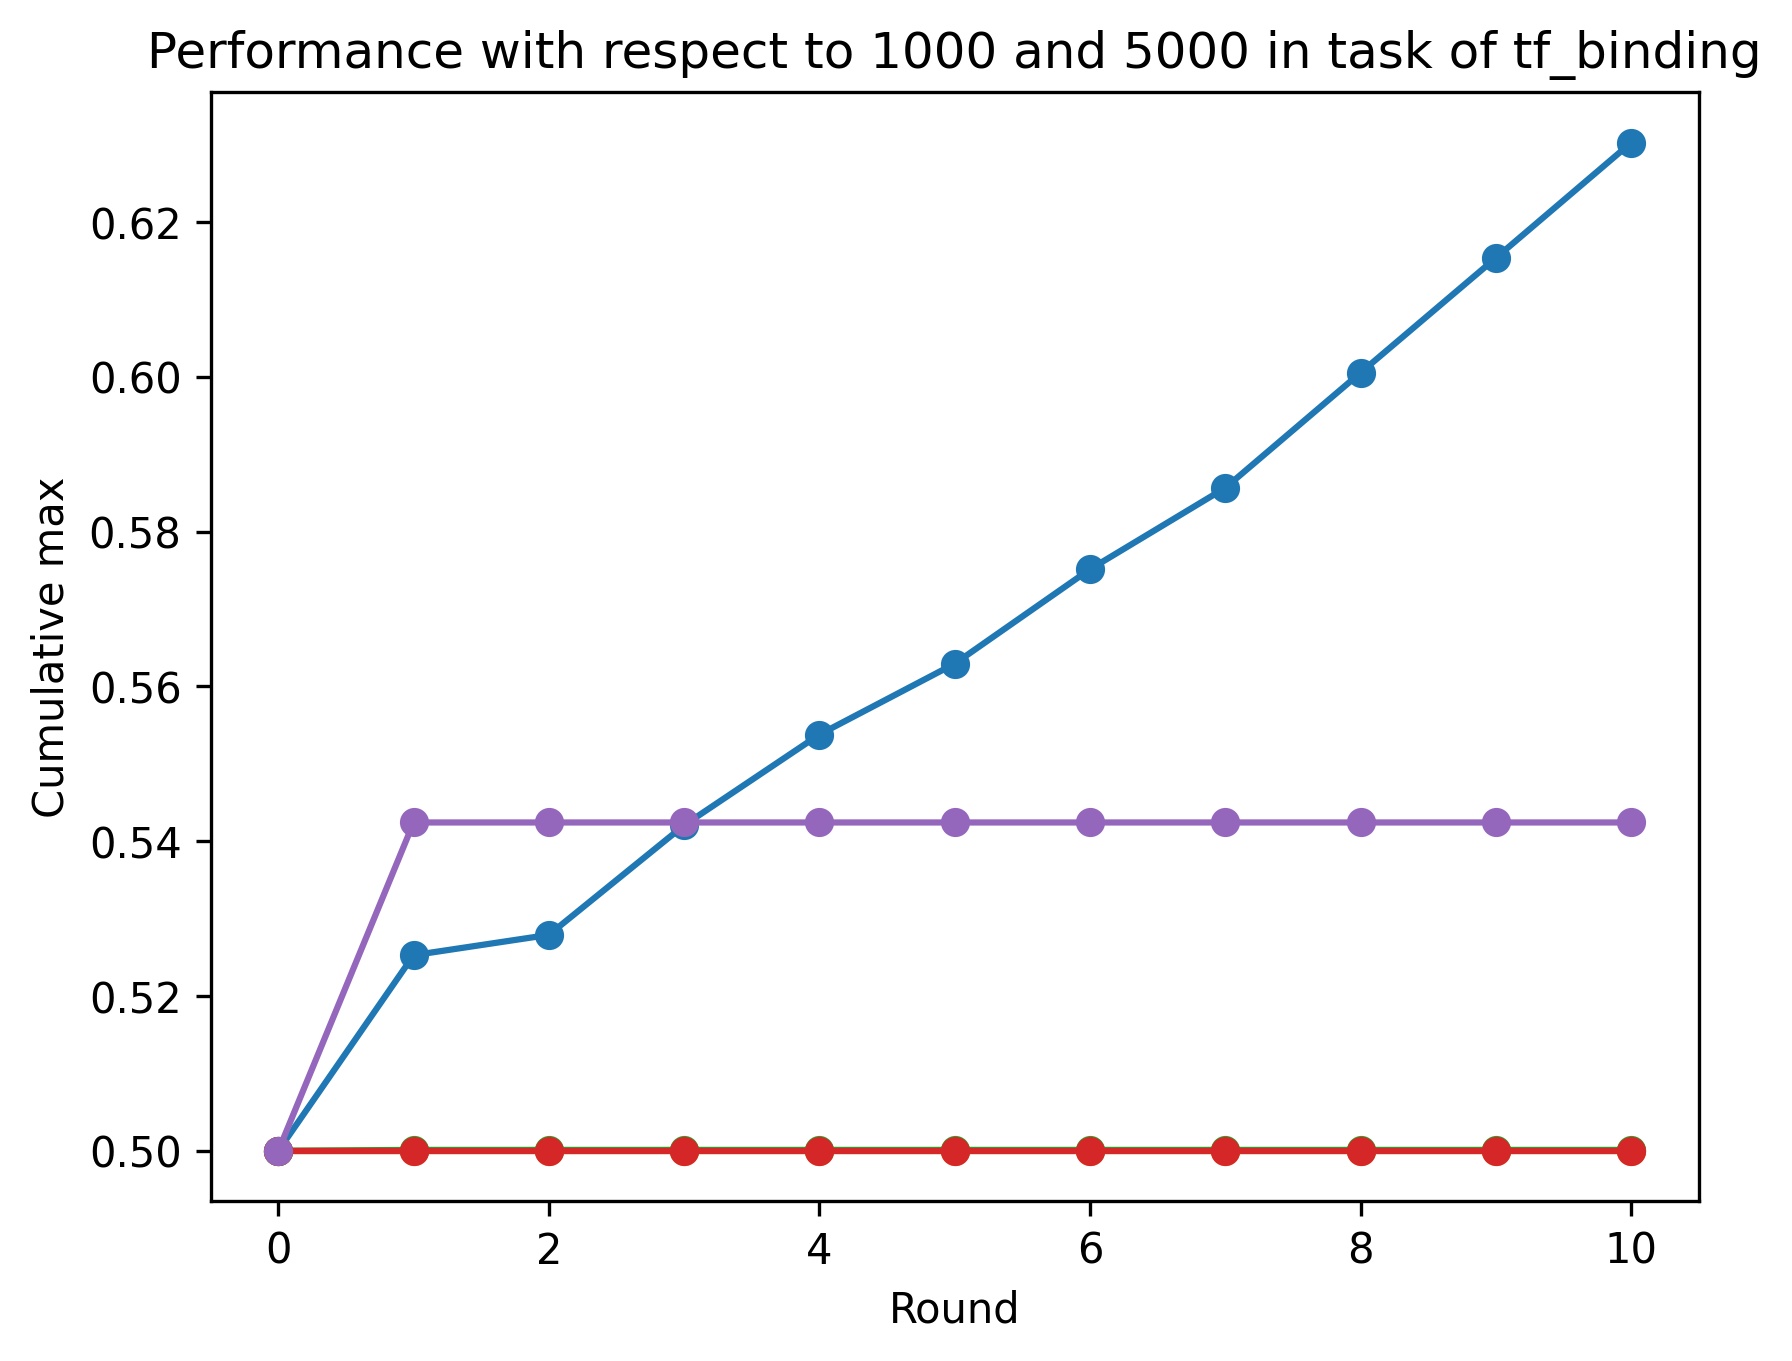

In [7]:
import matplotlib.pyplot as plt
import json
import pandas as pd
import numpy as np


def cumulative_max_per_round(sequences):
    num_rounds = sequences['round'].max() + 1
    max_per_round = [sequences['true_score'][sequences['round'] == r].max()
                     for r in range(num_rounds)]

    return np.maximum.accumulate(max_per_round)


for sequences_batch_size, model_queries_per_batch in [(100, 5000), (1000, 5000)]:
    plt.figure(dpi=300)
    plt.title(f'Performance with respect to {sequences_batch_size} and {model_queries_per_batch} in task of tf_binding')
    for method in ['adalead', 'cmaes', 'BO', 'dynappo', 'cbas', 'dirichlet_ppo', 'test', 'dirichlet_ppo_update_starting_sequence']:

        with open(f'/home/v-zhaozhiyu/code/FLEXS/efficiency/{method}/aav/{sequences_batch_size}_{model_queries_per_batch}.csv') as f:
            metadata = json.loads(next(f))
            data = pd.read_csv(f)

            rounds = data['round'].unique()
            max_per_round = cumulative_max_per_round(data)

        plt.plot(rounds, max_per_round, '-o', label=f'{method}')
        plt.ylabel("Cumulative max")
        plt.xlabel("Round")

    plt.legend()

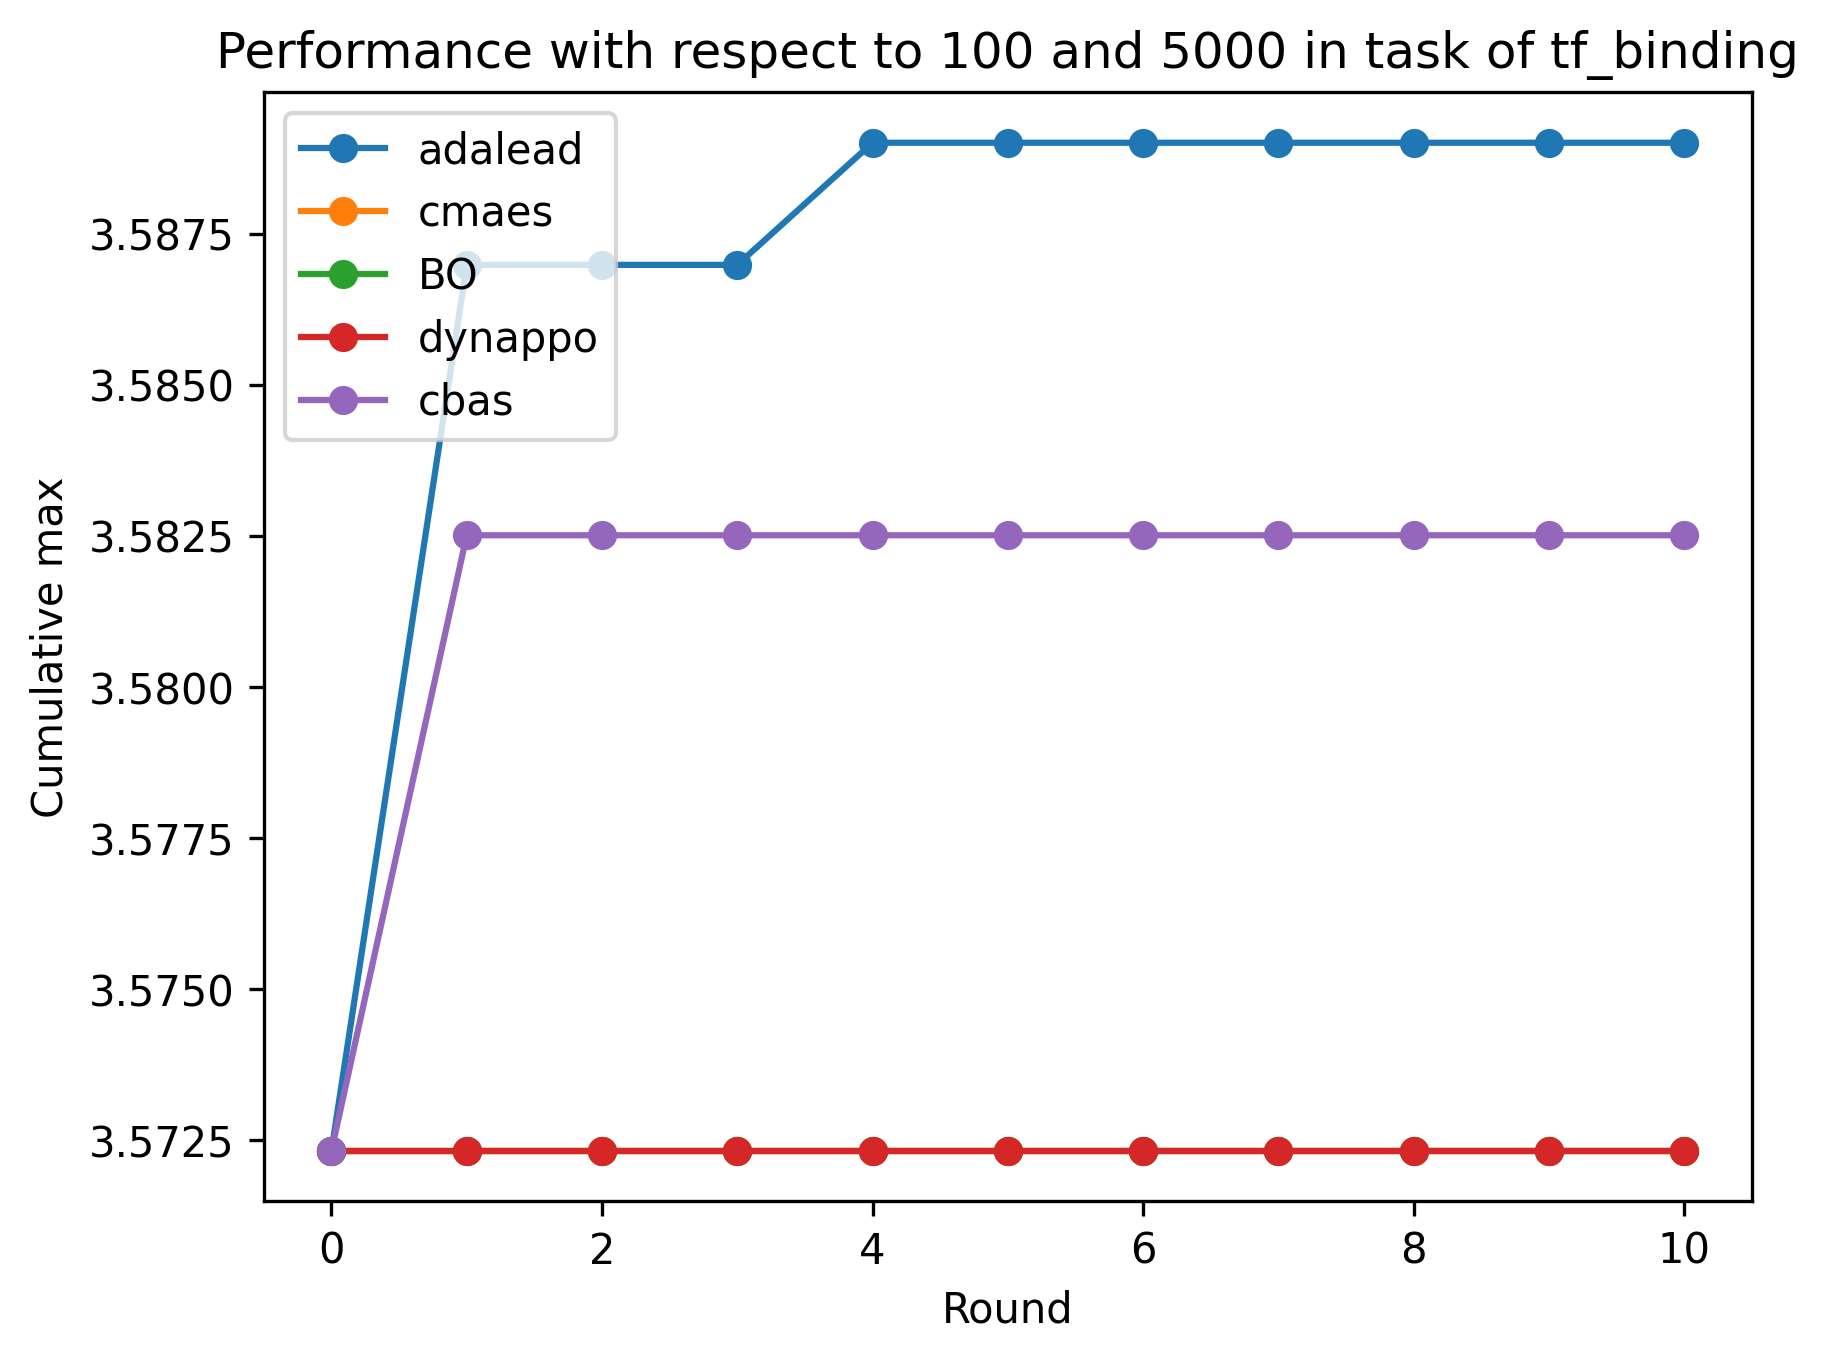

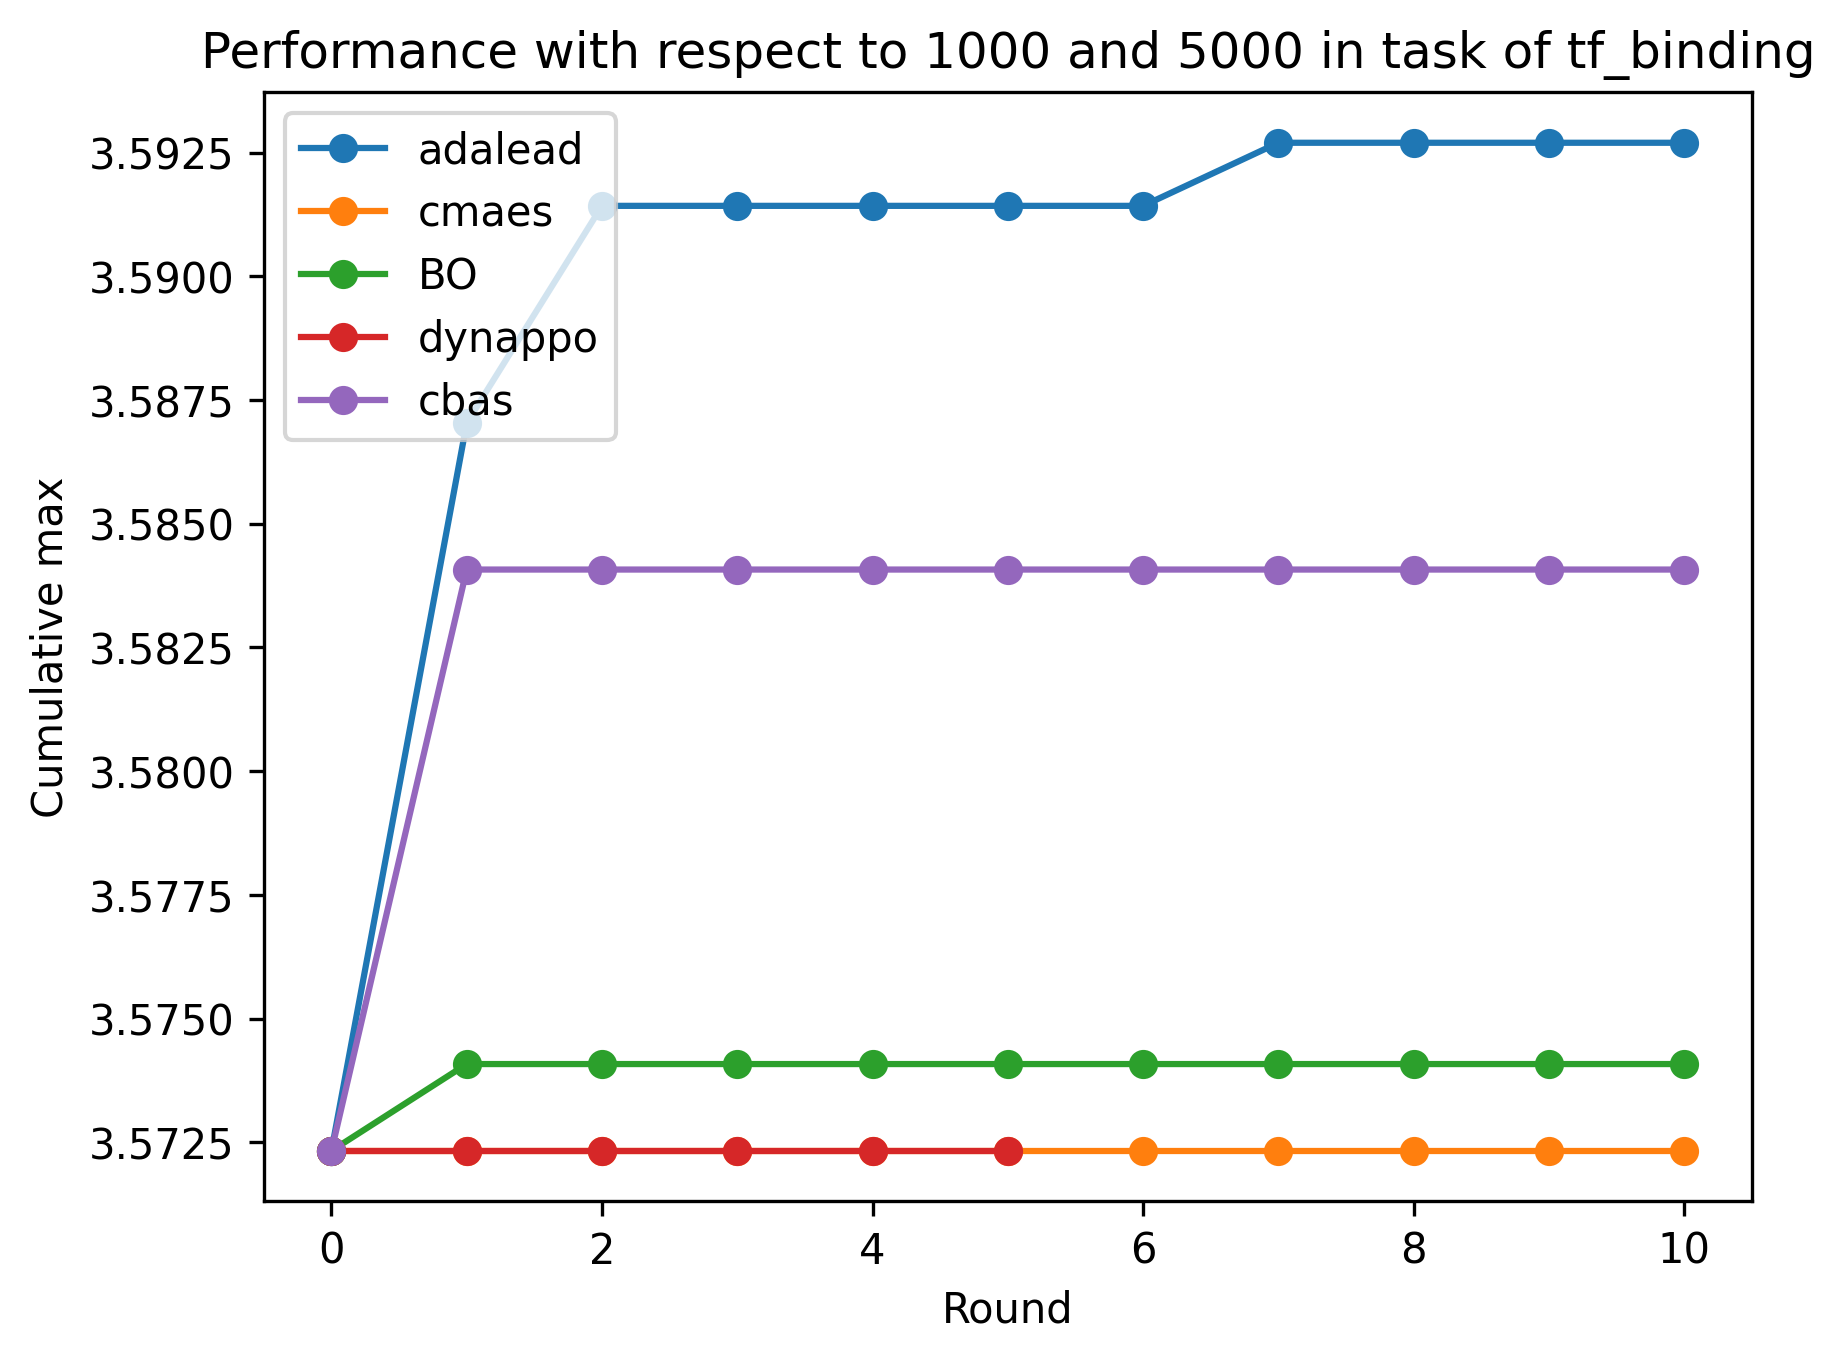

In [8]:
import matplotlib.pyplot as plt
import json
import pandas as pd
import numpy as np


def cumulative_max_per_round(sequences):
    num_rounds = sequences['round'].max() + 1
    max_per_round = [sequences['true_score'][sequences['round'] == r].max()
                     for r in range(num_rounds)]

    return np.maximum.accumulate(max_per_round)


for sequences_batch_size, model_queries_per_batch in [(100, 5000), (1000, 5000)]:
    plt.figure(dpi=300)
    plt.title(f'Performance with respect to {sequences_batch_size} and {model_queries_per_batch} in task of tf_binding')
    for method in ['adalead', 'cmaes', 'BO', 'dynappo', 'cbas']:

        with open(f'/home/v-zhaozhiyu/code/FLEXS/efficiency/{method}/gfp/{sequences_batch_size}_{model_queries_per_batch}.csv') as f:
            metadata = json.loads(next(f))
            data = pd.read_csv(f)

            rounds = data['round'].unique()
            max_per_round = cumulative_max_per_round(data)

        plt.plot(rounds, max_per_round, '-o', label=f'{method}')
        plt.ylabel("Cumulative max")
        plt.xlabel("Round")

    plt.legend()

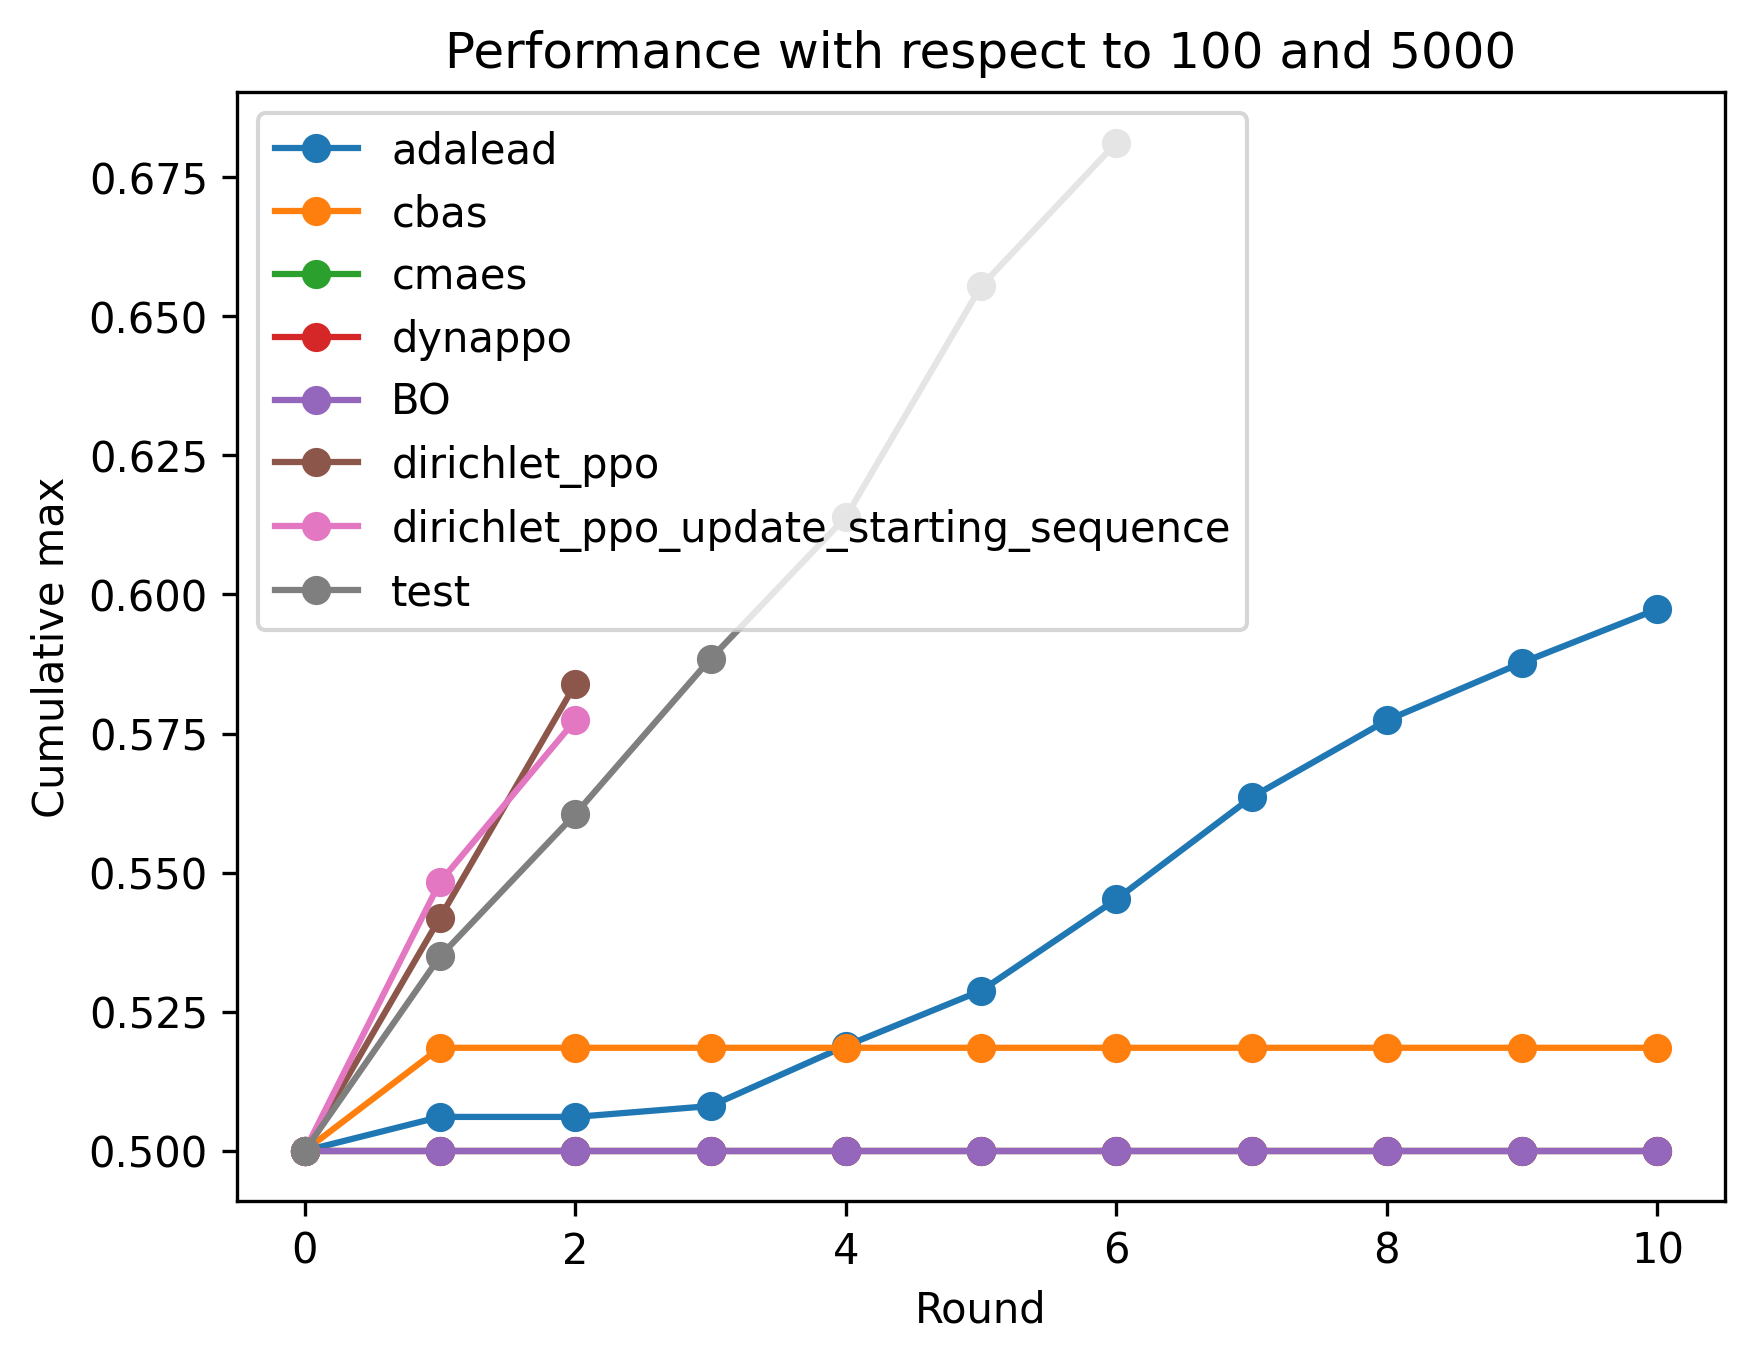

In [3]:
import matplotlib.pyplot as plt
import json
import pandas as pd
import numpy as np


def cumulative_max_per_round(sequences):
    num_rounds = sequences['round'].max() + 1
    max_per_round = [sequences['true_score'][sequences['round'] == r].max()
                     for r in range(num_rounds)]

    return np.maximum.accumulate(max_per_round)


for sequences_batch_size, model_queries_per_batch in [(100, 5000)]:
    plt.figure(dpi=300)
    plt.title(f'Performance with respect to {sequences_batch_size} and {model_queries_per_batch}')
    for method in ['adalead', 'cbas', 'cmaes', 'dynappo', 'BO', 'dirichlet_ppo', 'dirichlet_ppo_update_starting_sequence', 'test']:
        with open(f'/home/v-zhaozhiyu/code/FLEXS/efficiency/{method}/aav/{sequences_batch_size}_{model_queries_per_batch}.csv') as f:
            metadata = json.loads(next(f))
            data = pd.read_csv(f)

            rounds = data['round'].unique()
            max_per_round = cumulative_max_per_round(data)

        plt.plot(rounds, max_per_round, '-o', label=f'{method}')
        plt.ylabel("Cumulative max")
        plt.xlabel("Round")

    plt.legend()

In [2]:
3000 / 60 * 10 / 60

8.333333333333334